# Data Import and Wrangling

## Load Modules

In [1]:
#system
import warnings
import sys
import subprocess
import pkg_resources
import os
from os import path
from datetime import date

# # scikit-misc for loess smoothing
# required = {'outlier_utils','scikit-misc','scikit_posthocs'}
# installed = {pkg.key for pkg in pkg_resources.working_set}
# missing = required - installed

# if missing:
#     python = sys.executable
#     subprocess.check_call([python, '-m', 'pip', 'install', *missing], stdout=subprocess.DEVNULL)
# from scipy import misc

#stats
import pandas as pd
import numpy as np
import math
from pandas.api.types import CategoricalDtype
import outliers
from numpy import cov
from sklearn.metrics import mean_squared_error
from math import sqrt

#scale and center dataset
#https://scikit-learn.org/stable/modules/preprocessing.html 
from sklearn import preprocessing

#scipy
from scipy import stats as sci
from scipy.stats import linregress
from scipy.stats.mstats import gmean
from scipy.stats import gstd
from scipy.stats import kendalltau
from scipy.optimize import curve_fit
import scikit_posthocs as sp

#sklearn related
from sklearn.linear_model import LinearRegression
from sklearn.utils import resample as bootstrap
import skmisc

#plotting
from plotnine import *
import matplotlib
from matplotlib import cm
import matplotlib.pyplot as mplt
%matplotlib inline
from mizani.formatters import scientific_format
from pylab import * #colormap extraction
import seaborn as sns 

#scripts
from reprocess_qpcr import *
from calculations import *
from read_gsheets import *
from qa_qc import *

#sheets
rna_tab = 'sample_inventory'
ww_tab='site_lookup'
facility_lookup='site_lookup' #from Hannah: why are ww_tab and facility_lookup the same?
qpcr_results_tab = 'QuantStudio_raw_data'
qpcr_plates_tab = 'Plate_info'
cases_tab='casedata'
chem_data = 'physicochemical_data'
master="master_curves"

warnings.filterwarnings('ignore') #toggle plotnine warnings

In [2]:
#saving figures and tables
dir=os.getcwd()
dir=os.path.join(dir, "Figures")

## Local attributes

In [3]:

def augmented_dickey_fuller_statistics(time_series):
    result = adfuller(time_series.values)
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))



#made this by editing code from here https://gist.github.com/AllenDowney/818f6153ef316aee80467c51faee80f8
import statsmodels.api as sm
from contextlib import suppress
smlowess = sm.nonparametric.lowess

# from skmisc.loess import loess as loess_klass 

# import warnings
# from contextlib import suppress
# a=a.sort_values("date_sampling")

def pnlowess(y,x, **params):
    for k in ('is_sorted', 'return_sorted'):
        with suppress(KeyError):
            del params['method_args'][k]
            warnings.warn(
                "Smoothing method argument: {}, "
                "has been ignored.".format(k)
            )

    result = smlowess(y, x,
                      frac=params['span'],
                      is_sorted=True,
                      **params['method_args'])
    data = pd.DataFrame({
        'x': result[:, 0],
        'y': result[:, 1]})
    return(data)


def make_loess(series, wk):
    endog = series.values
    exog = series.index.values
    tot=len(endog)
    fr=wk/tot

    smooth = smlowess(endog, exog,frac=fr, is_sorted=True) #is_sorted needs to be true when working with dates (and need to make sure it is actually sorted before using this function)
    index, data = np.transpose(smooth)
    
    return pd.Series(data, index=pd.to_datetime(index))



#based on code from here https://stackoverflow.com/questions/25571882/pandas-columns-correlation-with-statistical-significance
def calculate_pvalues(df_full):
    final_ken=pd.DataFrame()
    for loc in locs:
      df=df_full[df_full.location==loc].copy()
      df = df._get_numeric_data()
      dfcols = pd.DataFrame(columns=df.columns)
      values = dfcols.transpose().join(dfcols, how='outer')
      for r in df.columns:
          for c in df.columns:
              values[r][c] = kendalltau(df[r], df[c], nan_policy='omit')[1]

      values=values.reset_index()[values.index.isin(row1)].drop(row1,axis=1)
      values["location"]=loc
      final_ken=final_ken.append(values)
    return final_ken

def calculate_kendall(df_full):
    final_ken=pd.DataFrame()
    for loc in locs:
      df=df_full[df_full.location==loc].copy()
      df = df._get_numeric_data()
      dfcols = pd.DataFrame(columns=df.columns)
      values = dfcols.transpose().join(dfcols, how='outer')
      for r in df.columns:
          for c in df.columns:
              values[r][c] = round(kendalltau(df[r], df[c], nan_policy='omit')[0], 4)

      values=values.reset_index()[values.index.isin(row1)].drop(row1,axis=1)
      values["location"]=loc
      final_ken=final_ken.append(values)
    return final_ken

def calculate_kendalldt(df_full):
    final_ken=pd.DataFrame()
    for loc in locs:
      df=df_full[df_full.date_type==loc].copy()
      df = df._get_numeric_data()
      dfcols = pd.DataFrame(columns=df.columns)
      values = dfcols.transpose().join(dfcols, how='outer')
      for r in df.columns:
          for c in df.columns:
              values[r][c] = round(kendalltau(df[r], df[c], nan_policy='omit')[0], 4)

      values=values.reset_index()[values.index.isin(row1)].drop(row1,axis=1)
      values["date_type"]=loc
      final_ken=final_ken.append(values)
    return final_ken


def dataframes_kendall(wBDL, woBDL, condition, lis_t2):
  def kendall_pval(x,y):
          return kendalltau(x,y)[1]

  def kendall_kval(x,y):
          return kendalltau(x,y)[0]
  wBDL_pval=wBDL.groupby(['location']).corr(method=kendall_pval).reset_index()
  wBDL_pval=wBDL_pval[wBDL_pval.level_1!= n_new_sm].drop(lis_t2, axis=1)
  wBDL_pval.columns=["location", "Target", "pval"]
  wBDL_kval=wBDL.groupby(['location']).corr(method=kendall_kval).reset_index()
  wBDL_kval=wBDL_kval[wBDL_kval.level_1!= n_new_sm].drop(lis_t2, axis=1)
  wBDL_kval.columns=["location", "Target", "kval"]
  wBDL=wBDL_kval.merge(wBDL_pval)
  wBDL["BDL"]="BLoD"
  wBDL["condition"]= wBDL["location"]+" "+condition
  woBDL_pval=woBDL.groupby(['location']).corr(method=kendall_pval).reset_index()
  woBDL_pval=woBDL_pval[woBDL_pval.level_1!= n_new_sm].drop(lis_t2, axis=1)
  woBDL_pval.columns=["location", "Target", "pval"]
  woBDL_kval=woBDL.groupby(['location']).corr(method=kendall_kval).reset_index()
  woBDL_kval=woBDL_kval[woBDL_kval.level_1!= n_new_sm].drop(lis_t2, axis=1)
  woBDL_kval.columns=["location", "Target", "kval"]
  woBDL=woBDL_kval.merge(woBDL_pval)
  woBDL["BDL"]="without  BLoD"
  woBDL["condition"]= woBDL["location"]+" "+condition
  fin=wBDL.append(woBDL).reset_index(drop=True)
  return(fin)

def dataframes_kendalldt(wBDL, woBDL, condition,lis_t2):
  def kendall_pval(x,y):
          return kendalltau(x,y)[1]

  def kendall_kval(x,y):
          return kendalltau(x,y)[0]
  wBDL_pval=wBDL.groupby(['date_type']).corr(method=kendall_pval).reset_index()
  wBDL_pval=wBDL_pval[wBDL_pval.level_1!= n_new_sm].drop(lis_t2, axis=1)
  wBDL_pval.columns=["date_type", "Target", "pval"]
  wBDL_kval=wBDL.groupby(['date_type']).corr(method=kendall_kval).reset_index()
  wBDL_kval=wBDL_kval[wBDL_kval.level_1!= n_new_sm].drop(lis_t2, axis=1)
  wBDL_kval.columns=["date_type", "Target", "kval"]
  wBDL=wBDL_kval.merge(wBDL_pval)
  wBDL["BDL"]="BLoD"
  wBDL["condition"]= wBDL["date_type"]+" "+condition
  woBDL_pval=woBDL.groupby(['date_type']).corr(method=kendall_pval).reset_index()
  woBDL_pval=woBDL_pval[woBDL_pval.level_1!= n_new_sm].drop(lis_t2, axis=1)
  woBDL_pval.columns=["date_type", "Target", "pval"]
  woBDL_kval=woBDL.groupby(['date_type']).corr(method=kendall_kval).reset_index()
  woBDL_kval=woBDL_kval[woBDL_kval.level_1!= n_new_sm].drop(lis_t2, axis=1)
  woBDL_kval.columns=["date_type", "Target", "kval"]
  woBDL=woBDL_kval.merge(woBDL_pval)
  woBDL["BDL"]="without  BLoD"
  woBDL["condition"]= woBDL["date_type"]+" "+condition
  fin=wBDL.append(woBDL).reset_index(drop=True)
  return(fin)

In [4]:
pd.set_option('display.float_format', '{:.2E}'.format)

## Load datasets

In [5]:
# metadata
sample_data = read_sample_data(rna_tab, facility_lookup)
copy_sd=sample_data.copy()

sample_data["RNA_yield_quantification"]=np.nan
sample_data["DNA_yield_quantification"]=np.nan
sample_data.loc[sample_data.RNA_ng_ul_qubit_all=='<5','RNA_yield_quantification']='below quantification limit'
sample_data.loc[(sample_data.RNA_ng_ul_qubit_all!="")&(sample_data.RNA_ng_ul_qubit_all!='<5'),'RNA_yield_quantification']='quantifiable'
sample_data.loc[sample_data.RNA_ng_ul_qubit_all=='<5','RNA_ng_ul_qubit_all']=2.5
sample_data.loc[sample_data.DNA_ng_ul_qubit_all=='<0.05','DNA_yield_quantification']='below quantification limit'
sample_data.loc[((sample_data.DNA_ng_ul_qubit_all!=""))&(sample_data.DNA_ng_ul_qubit_all!='<0.05'),'DNA_yield_quantification']='quantifiable'
sample_data.loc[sample_data.DNA_ng_ul_qubit_all=='<0.05','DNA_ng_ul_qubit_all']=0.025

#get RNA data into editable form
sample_data['elution_vol_ul']=pd.to_numeric(sample_data.elution_vol_ul)
sample_data['weight_vol_extracted_ml']=pd.to_numeric(sample_data.weight_vol_extracted_ml)
sample_data['RNA_ng_ul_qubit_all']=pd.to_numeric(sample_data.RNA_ng_ul_qubit_all)
sample_data['DNA_ng_ul_qubit_all']=pd.to_numeric(sample_data.DNA_ng_ul_qubit_all)
sample_data['RNA_yield_ext']=(sample_data.RNA_ng_ul_qubit_all*sample_data.elution_vol_ul)
sample_data['DNA_yield_ext']=(sample_data.DNA_ng_ul_qubit_all*sample_data.elution_vol_ul)
sample_data['RNA_yield']=(sample_data.RNA_ng_ul_qubit_all*sample_data.elution_vol_ul)/sample_data.weight_vol_extracted_ml
sample_data['DNA_yield']=(sample_data.DNA_ng_ul_qubit_all*sample_data.elution_vol_ul)/sample_data.weight_vol_extracted_ml
sample_data['date_sampling']=pd.to_datetime(sample_data['date_sampling'])

#Load master curve
master_curve=pd.read_csv('data_files/'+master+'.csv').dropna(how='all')
master_curve.LoD_Cq=pd.to_numeric(master_curve.LoD_Cq)
master_curve.m=pd.to_numeric(master_curve.m)
master_curve.b=pd.to_numeric(master_curve.b)
master_curve.LoD_quantity=pd.to_numeric(master_curve.LoD_quantity)
master_curve.lowest_quantity=pd.to_numeric(master_curve.lowest_quantity)

# plotting LoD lines for each plot
master_curve["LoD_gc_per_L"]= (master_curve.lowest_quantity/5)*1000*200/50
N1_LoD=master_curve.loc[master_curve.Target=="N1", "LoD_gc_per_L"].item()
S18_LoD=master_curve.loc[master_curve.Target=="18S", "LoD_gc_per_L"].item()
PMMoV_LoD=master_curve.loc[master_curve.Target=="PMMoV", "LoD_gc_per_L"].item()
C_LoD=master_curve.loc[master_curve.Target=="crAss", "LoD_gc_per_L"].item()
bact_LoD=master_curve.loc[master_curve.Target=="bact", "LoD_gc_per_L"].item()

#qpcr data
qpcr_raw = read_qpcr_data(qpcr_results_tab, qpcr_plates_tab)
plates=[ 68, 85, 86, 87,88, 91, 92, 93, 94, 95, 96,97, 99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121, 123, 124,125,126,127 ]
plates_LTM= [ 87,88,  92, 93, 94, 95, 96, 99,100,101,102,123, 124,125,126,127 ]
qpcr_raw=qpcr_raw[qpcr_raw.plate_id.isin(plates)].copy()
# qpcr_raw=qpcr_raw[qpcr_raw.LoD_testing != "Y"].copy()
qpcr_processed, std_curve_df, dilution_expts_df,raw_outliers_flagged_df, control_df = process_qpcr_raw(qpcr_raw, 'grubbs_only', master=master_curve, use_master_curve=True)

# merge with sample data
qpcr_averaged = qpcr_processed.merge(sample_data, how='left', left_on='Sample', right_on='sample_id')
qpcr_averaged = qpcr_averaged[(qpcr_averaged.Sample != 'NTC') &
                              (qpcr_averaged.Target != 'Xeno') &
                              (qpcr_averaged.inhibition_testing == "N")] # Remove spike and dilute inhibition testing from qPCR averaged

# calculations
qpcr_averaged['gc_per_L'] = calculate_gc_per_l(qpcr_averaged) # get gc/L
qpcr_averaged = normalize_to_pmmov(qpcr_averaged)
qpcr_averaged_merged= get_extraction_control(qpcr_averaged)
und_N1=qpcr_averaged_merged[qpcr_averaged_merged.Target=="N1"][["is_undetermined_count", "replicate_init_count", "Sample"]].copy()
und_N1.columns=["is_undetermined_N1", "is_undetermined_N1_total", "Sample"]
bloq_N1=qpcr_averaged_merged[qpcr_averaged_merged.Target=="N1"][["is_bloq_count", "replicate_init_count",  "gc_per_L","Sample"]].copy()
bloq_N1["is_bloq_bio_N1"]=False
bloq_N1.loc[ (bloq_N1.gc_per_L < N1_LoD ), "is_bloq_bio_N1"]=True
bloq_N1=bloq_N1.drop("gc_per_L", axis=1)
bloq_N1.columns=["is_bloq_N1", "is_bloq_N1_total","Sample","is_bloq_bio_N1"]

qpcr_averaged_merged=qpcr_averaged_merged.merge(und_N1, how='left')
qpcr_averaged_merged=qpcr_averaged_merged.merge(bloq_N1, how='left')

# test inhibition
qpcr_averaged_merged, xeno_inhib_full,xeno_control=xeno_inhibition_test(raw_outliers_flagged_df,qpcr_averaged_merged)
xeno_inhib=xeno_inhib_full.merge(sample_data, left_on='Sample', right_on='sample_id',  how='left').copy()
xeno_inhib=xeno_inhib[(xeno_inhib['batch'].str.contains("B", na=False))].copy()
x_plates=xeno_inhib.plate_id.unique()
xeno_control=xeno_control[xeno_control.plate_id.isin(x_plates)].copy()

# #remove pop up lab batches
# qpcr_averaged_merged=qpcr_averaged_merged[(qpcr_averaged_merged['batch'].str.contains("B", na=False))].copy()
# nI=["RV","SD2","SRWS","SR"]
# qpcr_averaged_merged=qpcr_averaged_merged[~qpcr_averaged_merged.interceptor.isin(nI)].copy()

#control df
control_df.loc[control_df.Task!="Negative Control", "Task"]="PBS control"
control_df=control_df[control_df.plate_id.isin(plates) ].copy()


PMMoV
   Quantity  Cq_mean  negatives  total   fr_pos
0  1.00E+02 3.64E+01          0     12 1.00E+00
1  1.00E+03 3.33E+01          0     12 1.00E+00
2  1.00E+04 2.98E+01          0     12 1.00E+00
3  1.00E+05 2.64E+01          0     12 1.00E+00
4  1.00E+06 2.26E+01          0     12 1.00E+00
5  1.00E+07 1.90E+01          0     12 1.00E+00
6  1.00E+08 1.57E+01          0     12 1.00E+00
N1
    Quantity  Cq_mean  negatives  total   fr_pos
0   3.12E-01 3.83E+01         11     12 8.33E-02
1   6.25E-01 3.83E+01         11     12 8.33E-02
2   1.25E+00 3.82E+01          9     12 2.50E-01
3   2.50E+00 3.78E+01          6     12 5.00E-01
4   5.00E+00 3.74E+01         18     53 6.60E-01
5   1.00E+01 3.64E+01          5     51 9.02E-01
6   2.00E+01 3.55E+01          1     54 9.81E-01
7   1.00E+02 3.29E+01          1     54 9.81E-01
8   1.00E+03 2.93E+01          0     54 1.00E+00
9   1.00E+04 2.59E+01          0     54 1.00E+00
10  1.00E+05 2.26E+01          1     54 9.81E-01
Xeno
    Quantity  

In [6]:
qpcr_raw.dilution.unique()


array([ 1,  2, 10])

## Load case and chemical data

In [7]:
#import tab
cases=pd.read_csv('data_files/'+cases_tab+'.csv').dropna(how='all')
cases.date_sampling=pd.to_datetime(cases.date_sampling)
cases.total_tests=pd.to_numeric(cases.total_tests)
cases.new_cases=pd.to_numeric(cases.new_cases)
cases.seven_day_moving_total_new_cases=pd.to_numeric(cases.seven_day_moving_total_new_cases)
cases.fourteen_day_moving_total_new_cases=pd.to_numeric(cases.fourteen_day_moving_total_new_cases)
cases['moving_average_new_cases']=cases.seven_day_moving_total_new_cases/7
cases.loc[cases.sample_code=="C_C_N49",'moving_average_new_cases' ]=  cases.loc[cases.sample_code=="C_C_N49",'fourteen_day_moving_total_new_cases']/14
cases.seven_day_moving_total_active_cases=pd.to_numeric(cases.seven_day_moving_total_active_cases)
cases['moving_average_active_cases']=cases.seven_day_moving_total_active_cases/7
cases.active_cases=pd.to_numeric(cases.active_cases)
cases.total_tests=pd.to_numeric(cases.total_tests)
cases['fraction_positive']=np.nan
cases.loc[cases.sample_code=="C_C_N49","new_cases"]=1

#convert to long format
cases_long=cases.rename(columns = {'fraction_positive': 'value-fraction_positive', 'new_cases': 'value-new_cases', 'total_tests': 'value-total_tests', 'active_cases': 'value-active_cases',  'released_while_active': 'value-released_while_active', 'active_cases': 'value-active_cases',  'resolved': 'value-resolved',  'deaths': 'value-deaths',  'deaths': 'value-deaths', 'fraction_positive': 'value-fraction_positive'}, inplace = False)
cases_long=pd.wide_to_long(cases_long, stubnames="value", i=["date_sampling","utility","interceptor","sample_code"], j="Target", sep='-', suffix='\w+').reset_index()
cases_long.value = pd.to_numeric(cases_long.value, errors='coerce')
cases_long["replicate"]="not applicable"
cases_long["Storage_conditions"]="not applicable"
cases_long["data_type"]="case data"

#load chem data
chem_data_wide= pd.read_csv('data_files/'+chem_data+'.csv').dropna(how='all')
chem_data_wide['date'] = pd.to_datetime(chem_data_wide['date'], format = '%m/%d/%Y')
chem_data_wide.TSS_mgL = pd.to_numeric(chem_data_wide.TSS_mgL, errors='coerce')
chem_data_wide.COD_mgL = pd.to_numeric(chem_data_wide.COD_mgL, errors='coerce')
chem_data_wide.BOD_mgL = pd.to_numeric(chem_data_wide.BOD_mgL, errors='coerce')
chem_data_wide.cBOD_mgL = pd.to_numeric(chem_data_wide.cBOD_mgL, errors='coerce')
chem_data_wide.flow_MGD = pd.to_numeric(chem_data_wide.flow_MGD, errors='coerce')
chem_data_wide.NH4_mgL = pd.to_numeric(chem_data_wide.NH4_mgL, errors='coerce') 
chem_data_wide=chem_data_wide.rename(columns = {'date': 'date_sampling'})
chem_data_long= chem_data_wide[["date_sampling","utility","interceptor","flow_MGD","TSS_mgL","COD_mgL", "cBOD_mgL","NH4_mgL"]].melt(id_vars= ["date_sampling", "utility", "interceptor"], var_name= "Target" )
chem_data_long.value = pd.to_numeric(chem_data_long.value, errors='coerce')
chem_data_long["Storage_conditions"]="not applicable"
chem_data_long["replicate"]="not applicable"
chem_data_long["data_type"]="chem data"

# merge case data & chem data with qpcr_averaged_merged
qpcr_averaged_merged= qpcr_averaged_merged.merge(cases, how='outer', on=["date_sampling","utility","interceptor", "sample_code"])
qpcr_averaged_merged= qpcr_averaged_merged.merge(chem_data_wide, how='outer', on=["date_sampling","utility","interceptor"])
blod_N1_samps=qpcr_averaged_merged.loc[(qpcr_averaged_merged.Target=="N1")&(qpcr_averaged_merged.blod_master_curve==True),"Sample"]
qpcr_averaged_merged_wide= qpcr_averaged_merged.pivot(index=['Sample',"date_sampling","sample_code","utility","interceptor","population",'is_undetermined_N1','is_bloq_N1','is_undetermined_N1_total', 'is_bloq_N1_total',"is_bloq_bio_N1","replicate","flow_MGD","TSS_mgL","BOD_mgL","cBOD_mgL","COD_mgL","NH4_mgL", "total_tests","fraction_positive","new_cases","active_cases","released_while_active","resolved","deaths", "moving_average_new_cases", "moving_average_active_cases"], columns='Target', values='gc_per_L').reset_index()

qpcr_averaged_merged_wide["average_flow_MGD"]= np.nan
qpcr_averaged_merged_wide.loc[qpcr_averaged_merged_wide.sample_code=="C_C_ADA", "population"]=82818
qpcr_averaged_merged_wide.loc[qpcr_averaged_merged_wide.sample_code=="C_C_ADA", "average_flow_MGD"]=6
qpcr_averaged_merged_wide.loc[qpcr_averaged_merged_wide.sample_code=="C_C_S68", "population"]=469344
qpcr_averaged_merged_wide.loc[qpcr_averaged_merged_wide.sample_code=="C_C_S68", "average_flow_MGD"]=35
qpcr_averaged_merged_wide.loc[qpcr_averaged_merged_wide.sample_code=="C_C_N49", "population"]=139037
qpcr_averaged_merged_wide.loc[qpcr_averaged_merged_wide.sample_code=="C_C_N49", "average_flow_MGD"]=10
qpcr_averaged_merged_wide.loc[qpcr_averaged_merged_wide.sample_code=="K_K_INF", "population"]=483600
qpcr_averaged_merged_wide.loc[qpcr_averaged_merged_wide.sample_code=="K_K_INF", "average_flow_MGD"]=33.33
qpcr_averaged_merged_wide.loc[qpcr_averaged_merged_wide.sample_code=="B_B_SQ", "average_flow_MGD"]=0.41
qpcr_averaged_merged_wide.loc[qpcr_averaged_merged_wide.sample_code=="B_B_SQ", "population"] = qpcr_averaged_merged_wide.loc[qpcr_averaged_merged_wide.sample_code=="B_B_SQ", "population"].fillna(method='pad')
qpcr_averaged_merged_wide.loc[qpcr_averaged_merged_wide.sample_code=="E_E_INF", "population"]=15000000
qpcr_averaged_merged_wide.loc[qpcr_averaged_merged_wide.sample_code=="E_E_INF", "average_flow_MGD"]=103.5

#long version with more targets to include case data and chem data
qpcr_averaged_merged_long=qpcr_averaged_merged.rename(columns = {'gc_per_L': 'value'})
qpcr_averaged_merged_long=qpcr_averaged_merged_long[["date_sampling","interceptor","utility","replicate","Target","value"]].copy()
qpcr_averaged_merged_long["data_type"]="qpcr data"
qpcr_averaged_merged_long=qpcr_averaged_merged_long.append(chem_data_long).reset_index()
qpcr_averaged_merged_long=qpcr_averaged_merged_long.append(cases_long).reset_index()
qpcr_averaged_merged_long['date_sampling'] = pd.to_datetime(qpcr_averaged_merged_long['date_sampling'])
qpcr_averaged_merged_long=qpcr_averaged_merged_long.drop(["level_0","index"], axis=1)


## Biomarker data

In [8]:
# Loading control full analysis

# r=['2','3']
# i=["INF","SQ","S68","ADA","N49"]
# wfsc_norm=qpcr_averaged_merged_wide[~((qpcr_averaged_merged_wide.utility=="K") & (qpcr_averaged_merged_wide.replicate.isin(r))) ].copy()
# wfsc_norm=qpcr_averaged_merged_wide[~((wfsc_norm.utility=="E") & (wfsc_norm.replicate.isin(r))) ].copy()
# wfsc_norm=wfsc_norm[wfsc_norm.interceptor.isin(i)].copy()
wfsc_norm=qpcr_averaged_merged_wide.copy()
loc = ["E", "K", "B", "C"]
cut= ["SR"]
wfsc_norm= wfsc_norm[(wfsc_norm.utility.isin(loc)) & (~wfsc_norm.interceptor.isin(cut))]

#set a column with the median of each fcc for each interceptor
wfsc_norm['PMMoV_med'] = wfsc_norm.groupby(['utility','interceptor'])["PMMoV"].transform('median')
wfsc_norm['crAss_med'] = wfsc_norm.groupby(['utility','interceptor'])["crAss"].transform('median')
wfsc_norm['crAss_med_all'] = wfsc_norm.crAss.median()
wfsc_norm['18S_med'] = wfsc_norm.groupby(['utility','interceptor'])["18S"].transform('median')
wfsc_norm['bact_med'] = wfsc_norm.groupby(['utility','interceptor'])["bact"].transform('median')

wfsc_norm['crAss_Q3'] = wfsc_norm.groupby(['utility','interceptor'])["crAss"].transform(lambda x: x.quantile(0.75)) #per interceptor
# wfsc_norm['crAss_Q3'] = wfsc_norm.crAss.quantile(0.75) #per assay, same LoD for all interceptors
wfsc_norm['PMMoV_Q3'] = wfsc_norm.groupby(['utility','interceptor'])["PMMoV"].transform(lambda x: x.quantile(0.75)) #per interceptor
wfsc_norm['bact_Q3'] = wfsc_norm.groupby(['utility','interceptor'])["bact"].transform(lambda x: x.quantile(0.75)) #per interceptor
wfsc_norm['18S_Q3'] = wfsc_norm.groupby(['utility','interceptor'])["18S"].transform(lambda x: x.quantile(0.75)) #per interceptor


#find the medians of each fcc without considering controls
# m= wfsc_norm[~wfsc_norm.Sample.str.contains("control")]
# wfsc_groupby= m.groupby(["utility", "interceptor"]).agg(PMMoV_med= ('PMMoV', 'median'), crAss_med= ('crAss', 'median'), med_18S= ('18S', 'median'), bact_med= ('bact', 'median')).reset_index()

# #normalize N1 by each loading control / median for that loading control for that interceptor 
wfsc_norm["N1_18S"] =wfsc_norm["N1"]/(wfsc_norm["18S"]/wfsc_norm["18S_med"]) #same units as N1
# #replace the fcc measurement with the median for that assay (so the ratio becomes 1) if N1 is undetermined(set to the LoD) so that they all have a consistent value
wfsc_norm.loc[(wfsc_norm.Sample.isin(blod_N1_samps)) & (~np.isnan(wfsc_norm["18S"])), "N1_18S" ]= wfsc_norm.N1/1

wfsc_norm["N1_bact"] =wfsc_norm["N1"]/(wfsc_norm["bact"]/wfsc_norm["bact_med"])
wfsc_norm.loc[(wfsc_norm.Sample.isin(blod_N1_samps)) & (~np.isnan(wfsc_norm.bact)), "N1_bact" ]= wfsc_norm.N1/1

wfsc_norm["N1_PMMoV"] =wfsc_norm["N1"]/(wfsc_norm["PMMoV"]/wfsc_norm["PMMoV_med"])
wfsc_norm.loc[(wfsc_norm.Sample.isin(blod_N1_samps)) & (~np.isnan(wfsc_norm.PMMoV)), "N1_PMMoV" ]= wfsc_norm.N1/1

wfsc_norm["N1_crAss"] =wfsc_norm["N1"]/(wfsc_norm["crAss"]/wfsc_norm["crAss_med"])
wfsc_norm.loc[(wfsc_norm.Sample.isin(blod_N1_samps)) & (~np.isnan(wfsc_norm.crAss)), "N1_crAss"]= wfsc_norm.N1/1

# wfsc_norm["N1_crAss_reg"] =wfsc_norm["N1"]/(wfsc_norm["crAss"]/wfsc_norm["crAss_med_all"])
# wfsc_norm.loc[(wfsc_norm.Sample.isin(blod_N1_samps)) & (~np.isnan(wfsc_norm.crAss)), "N1_crAss_reg"]= wfsc_norm.N1/1
wfsc_norm["N1_crAss_reg"] =wfsc_norm["N1"]/wfsc_norm["crAss"]
wfsc_norm.loc[(wfsc_norm.Sample.isin(blod_N1_samps)) & (~np.isnan(wfsc_norm.crAss)), "N1_crAss_reg"]= wfsc_norm["N1"]/wfsc_norm["crAss_Q3"]
N1_crAss_LoD_full=wfsc_norm.groupby(['sample_code'])["crAss_Q3"].agg(lambda x: N1_LoD/max(x)).reset_index()


wfsc_norm["N1_flow"]= wfsc_norm["N1"]*wfsc_norm["flow_MGD"]/pd.to_numeric(wfsc_norm["population"]) #units end up as copies/day/person
wfsc_norm["N1_TSS"] =wfsc_norm["N1"]/wfsc_norm["TSS_mgL"]
wfsc_norm["N1_cBOD"] = wfsc_norm["N1"]/wfsc_norm["cBOD_mgL"]
wfsc_norm["N1_NH4"]= wfsc_norm["N1"]/wfsc_norm["NH4_mgL"]
wfsc_norm["N1_COD"]= wfsc_norm["N1"]/wfsc_norm["COD_mgL"]


wfsc_norm_long= wfsc_norm.melt(id_vars= ["date_sampling", "utility", "interceptor", "population"], 
                               value_vars= ["N1", "N1_PMMoV", "N1_18S", "N1_bact", "N1_crAss", "N1_TSS", "N1_cBOD", "N1_COD","N1_flow"], #,"total_tests","fraction_positive","new_cases","active_cases","released_while_active","resolved","deaths", "moving_average_new_cases",  "moving_average_active_cases"], 
                               var_name= "Target" )

wfsc_norm_long.value = pd.to_numeric(wfsc_norm_long.value, errors='coerce')
wfsc_norm_long = wfsc_norm_long.dropna()

qpcr_averaged_merged_long['normalized']="N"
wfsc_norm_long["normalized"]="Y"

qpcr_averaged_merged_long=qpcr_averaged_merged_long.append(wfsc_norm_long)

## Generate dictionaries of dataframes by location

In [9]:
# interpolation and time series datasets
cols_wfsc= ["N1","N1_crAss","new_cases","moving_average_new_cases","moving_average_active_cases",  "total_tests", "fraction_positive", "active_cases", "population"]
cols_fill= ["moving_average_new_cases","moving_average_active_cases",  "total_tests", "fraction_positive", "active_cases", "population","new_cases"]
cols=["N1_int", "N1C_int", "N1Cr_int"]
cols_fcc=["N1_int", "N1C_int", "N1Cr_int","N1b_int", "N1P_int", "N1S_int"]
id_list=["K_K_INF", 'B_B_SQ', 'C_C_S68', 'C_C_N49', 'C_C_ADA' ]
g_id=["K_K_INF" ]
gb_list=["date_sampling","utility","interceptor", "sample_code" ]


wfsc_norm_int=wfsc_norm.loc[~pd.isnull(wfsc_norm.sample_code)].copy()
wfsc_norm_int=wfsc_norm_int.loc[wfsc_norm.sample_code.isin(id_list)].copy()
wfsc_norm_int=wfsc_norm_int.dropna(how="all", subset=cols_wfsc) #drop if they all are NA

# drop=["E_Inf_060220_2", "E_Inf_062820_2", "E_Inf_071220_3","E_Inf_080420_3","E_Inf_081120_2"] #visual outliers
# drop=["E_Inf_060420_1", "E_Inf_071920_1", "E_Inf_072820_1", "E_Inf_080420_1"] #based on 18S
# wfsc_norm_int=wfsc_norm_int[~wfsc_norm_int.Sample.isin(drop)].copy()
# reps=["2","3"]
# wfsc_norm_int=wfsc_norm_int[~((wfsc_norm_int.utility=="E") &(wfsc_norm_int.replicate.isin(reps))) ].copy()



# #find which bio triplicates pass grubbs
# test=wfsc_norm_int[["date_sampling","utility","interceptor", "sample_code", "N1"]].copy().dropna()
# test=test[test.sample_code.isin(g_id)].copy()
# test=get_pass_grubbs_test(test,gb_list, col='N1' )


# # #merge that column onnto orig
# # wfsc_norm_int=wfsc_norm_int.merge(test, how='left')
# # wfsc_norm_int=wfsc_norm_int[~(wfsc_norm_int.grubbs_test==False)].copy()
# # wfsc_norm_int=wfsc_norm_int.drop("grubbs_test", axis=1)

wfsc_norm_int.loc[:, cols_fill]=wfsc_norm_int.loc[:, cols_fill].fillna(-1) #to keep during groupby

qpcr_int=wfsc_norm_int.groupby(["date_sampling","utility","interceptor", "sample_code" ,"new_cases","total_tests", "fraction_positive", "active_cases", "population", "average_flow_MGD","moving_average_new_cases","moving_average_active_cases" ]).agg(
                                                                          N1_int=("N1", lambda x: sci.gmean(x,axis=0)),
                                                                          N1_gstd=('N1', lambda x: np.nan if ( (len(x.dropna()) <2 )| all(np.isnan(x)) | any(x==0) ) else (sci.gstd(x.dropna(),axis=0))),
                                                                          N1_n= ("N1",'count'),
                                                                          N1C_int=("N1_crAss", lambda x: sci.gmean(x,axis=0)),
                                                                          N1C_gstd=("N1_crAss", lambda x: np.nan if ( (len(x.dropna()) <2 )| all(np.isnan(x)) | any(x==0) ) else (sci.gstd(x.dropna(),axis=0))),
                                                                          NC1_n= ("N1_crAss",'count'),
                                                                          N1Cr_int=("N1_crAss_reg", lambda x: sci.gmean(x,axis=0)),
                                                                          N1Cr_gstd=("N1_crAss_reg", lambda x: np.nan if ( (len(x.dropna()) <2 )| all(np.isnan(x)) | any(x==0) ) else (sci.gstd(x.dropna(),axis=0))),
                                                                          NC1r_n= ("N1_crAss_reg",'count'),
                                                                          N1P_int=("N1_PMMoV", 'max'),
                                                                          N1P_gstd=("N1_PMMoV", lambda x: np.nan ),
                                                                          N1P_n= ("N1_PMMoV",'count'),
                                                                          N1b_int=("N1_bact", 'max'),
                                                                          N1b_gstd=("N1_bact", lambda x: np.nan ),
                                                                          N1b_n= ("N1_bact",'count'),
                                                                          N1S_int=("N1_18S", 'max'),
                                                                          N1S_gstd=("N1_18S", lambda x: np.nan ),
                                                                          N1S_n= ("N1_18S",'count'),
                                                                          N1_raw= ("N1", list),
                                                                          N1C_raw= ("N1_crAss", list),
                                                                          N1b_raw= ("N1_bact", list),
                                                                          N1_und=("is_undetermined_N1", 'sum'),
                                                                          N1_bloq=("is_bloq_N1", 'sum'),
                                                                          N1_und_total=("is_undetermined_N1_total", 'sum'),
                                                                          N1_bloq_total=("is_bloq_N1_total", 'sum'),
                                                                          N1_bloq_bio=("is_bloq_bio_N1", 'sum'),
                                                                          N1_bloq_bio_total=("is_bloq_bio_N1", 'count'),
                                                                          rep= ("replicate", list)
                                                                         ).reset_index()
                                                                      
qpcr_int=qpcr_int.replace(to_replace=-1, value=np.nan) #undo the nan fill with -1
qpcr_int['population']= pd.to_numeric(qpcr_int['population'])
qpcr_int['average_flow_MGD']= pd.to_numeric(qpcr_int['average_flow_MGD'])
qpcr_int.N1_und= qpcr_int.N1_und.astype(object)

# need to limit each interpolation for N1 andf N1C so it doesn't extendpast the final sample data & general limit
qpcr_int.date_sampling=pd.to_datetime(qpcr_int.date_sampling)
qpcr_int=qpcr_int[(qpcr_int.date_sampling>pd.to_datetime('2020-04-01')) & (qpcr_int.date_sampling<pd.to_datetime('2020-11-01'))].copy()

start_dict={"K_K_INF": pd.to_datetime('2020-06-12'), 'E_E_INF': pd.to_datetime('2020-05-29'),  'B_B_SQ':pd.to_datetime('2020-05-29'), 'C_C_S68':pd.to_datetime('2020-04-21'), 'C_C_N49': pd.to_datetime('2020-04-21'), 'C_C_ADA':pd.to_datetime('2020-05-28')}
end_dict={"K_K_INF": pd.to_datetime('2020-09-04'), 'E_E_INF': pd.to_datetime('2020-09-14'),  'B_B_SQ':pd.to_datetime('2020-09-15'), 'C_C_S68':pd.to_datetime('2020-09-15'), 'C_C_N49': pd.to_datetime('2020-09-15'), 'C_C_ADA':pd.to_datetime('2020-09-09')}
nam_dict={"K_K_INF": "K", 'E_E_INF': "E",  'B_B_SQ':"Q", 'C_C_S68':"S", 'C_C_N49': "N", 'C_C_ADA':"A"}
flow_dict={"K_K_INF": 33, 'E_E_INF': 103,  'C_C_S68':35, 'C_C_N49': 10, 'C_C_ADA':6, "B_B_SQ": 0.41} #for Sq, max
pop_dict={"K_K_INF": 483600, 'E_E_INF': 150000,  'C_C_S68':469344, 'C_C_N49': 139037, 'C_C_ADA':82818, "B_B_SQ": 3587}
residuals_dict={"K_K_INF": 5, 'E_E_INF': 7,  'B_B_SQ':6, 'C_C_S68':8, 'C_C_N49': 6, 'C_C_ADA':5}
fcc_list=["K_K_INF", "E_E_INF", "B_B_SQ"]

qpcr_long_dict = {}
qpcr_pchip_dict = {}
qpcr_dict = {}
qpcr_loess_dict= {}



for i in id_list:
    qpcr_K= qpcr_int.loc[qpcr_int.sample_code== i,].copy()
    qpcr_K.loc[:,"location"]=nam_dict[i]
    qpcr_K['new_cases_per_capita']=qpcr_K["new_cases"]/pd.to_numeric(qpcr_K['population'])
    qpcr_K['active_cases_per_capita']=qpcr_K["active_cases"]/pd.to_numeric(qpcr_K['population'])
    if i == "B_B_SQ":
      qpcr_K.loc[qpcr_K.new_cases_per_capita==0, "new_cases_per_capita"]=(1/7/pop_dict[i])/2
      qpcr_K.loc[qpcr_K.active_cases_per_capita==0, "active_cases_per_capita"]=(1/7/pop_dict[i])/2    
    else:
      qpcr_K.loc[qpcr_K.new_cases_per_capita==0, "new_cases_per_capita"]=(11/7/pop_dict[i])/2
      qpcr_K.loc[qpcr_K.active_cases_per_capita==0, "active_cases_per_capita"]=(11/7/pop_dict[i])/2
    
    qpcr_K_c=qpcr_K.sort_values("date_sampling")
    qpcr_K=qpcr_K.set_index("date_sampling", drop=False)
    qpcr_K_int=qpcr_K.drop("date_sampling", axis=1)
    qpcr_K_int=qpcr_K_int[cols].copy()
    
    #loess
    if i in fcc_list:
        qpcr_K_loess_N1=qpcr_K[cols_fcc].copy().dropna().sort_index()
    else:
        qpcr_K_loess_N1=qpcr_K[cols].copy().dropna().sort_index()

    qpcr_K_loess_N1["Target"]="N1"
    qpcr_K_loess_C=qpcr_K_loess_N1.copy()
    qpcr_K_loess_C["Target"]="N1_crAss"
    qpcr_K_loess_Cr=qpcr_K_loess_N1.copy()
    qpcr_K_loess_Cr["Target"]="N1_crAss_reg"
    qpcr_K_loess_b=qpcr_K_loess_N1.copy()
    qpcr_K_loess_b["Target"]="N1_bact"
    qpcr_K_loess_P=qpcr_K_loess_N1.copy()
    qpcr_K_loess_P["Target"]="N1_PMMoV"
    qpcr_K_loess_S=qpcr_K_loess_N1.copy()
    qpcr_K_loess_S["Target"]="N1_18S"
    value_N1=[]
    value_C=[]
    value_Cr=[]
    value_b=[]
    value_P=[]
    value_S=[]

    for j in range(0, len(qpcr_K_loess_N1.N1_int)):
        wk=j+1
        wk_str=str(wk)
        wk_str_pred="y_pred_"+wk_str
        qpcr_K_loess_N1[wk_str_pred]=np.nan
        qpcr_K_loess_N1[ wk_str_pred]=make_loess(qpcr_K_loess_N1["N1_int"],wk)
        qpcr_K_loess_N1[wk_str]=qpcr_K_loess_N1["N1_int"]- qpcr_K_loess_N1[wk_str_pred]
        value_N1=value_N1 + [wk_str]
        
        qpcr_K_loess_C[wk_str_pred]=make_loess(qpcr_K_loess_C["N1C_int"],wk)
        qpcr_K_loess_C[wk_str]=qpcr_K_loess_C["N1C_int"]- qpcr_K_loess_C[wk_str_pred]
        value_C=value_C + [wk_str]

        qpcr_K_loess_Cr[wk_str_pred]=make_loess(qpcr_K_loess_Cr["N1Cr_int"],wk)
        qpcr_K_loess_Cr[wk_str]=qpcr_K_loess_C["N1Cr_int"]- qpcr_K_loess_Cr[wk_str_pred]
        value_Cr=value_Cr + [wk_str]
        
        if i in fcc_list:
            qpcr_K_loess_b[wk_str_pred]=make_loess(qpcr_K_loess_b["N1b_int"],wk)
            qpcr_K_loess_b[wk_str]=qpcr_K_loess_b["N1b_int"]- qpcr_K_loess_b[wk_str_pred]
            value_b=value_b + [wk_str]
            
            qpcr_K_loess_P[wk_str_pred]=make_loess(qpcr_K_loess_P["N1P_int"],wk)
            qpcr_K_loess_P[wk_str]=qpcr_K_loess_P["N1P_int"]- qpcr_K_loess_P[wk_str_pred]
            value_P=value_P + [wk_str]
            
            qpcr_K_loess_S[wk_str_pred]=make_loess(qpcr_K_loess_S["N1S_int"],wk)
            qpcr_K_loess_S[wk_str]=qpcr_K_loess_S["N1S_int"]- qpcr_K_loess_S[wk_str_pred]
            value_S=value_S + [wk_str]

    qpcr_K_loess_C=qpcr_K_loess_C.reset_index()
    qpcr_K_loess_C1=qpcr_K_loess_C.melt(id_vars= ["date_sampling", "Target"], 
                                   value_vars= value_C,
                                   var_name= "points", 
                                   value_name="residuals")
    qpcr_K_loess_C2=qpcr_K_loess_C.melt(id_vars= ["date_sampling", "Target"], 
                                   value_vars= ["y_pred_" + s for s in value_C],
                                   var_name= "points", 
                                   value_name="y_pred")
    qpcr_K_loess_C2['points']=qpcr_K_loess_C2['points'].apply(lambda x: x.replace("y_pred_",""))
    qpcr_K_loess_C= qpcr_K_loess_C1.merge(qpcr_K_loess_C2)

    qpcr_K_loess_Cr=qpcr_K_loess_Cr.reset_index()
    qpcr_K_loess_C1r=qpcr_K_loess_Cr.melt(id_vars= ["date_sampling", "Target"], 
                                   value_vars= value_Cr,
                                   var_name= "points", 
                                   value_name="residuals")
    qpcr_K_loess_C2r=qpcr_K_loess_Cr.melt(id_vars= ["date_sampling", "Target"], 
                                   value_vars= ["y_pred_" + s for s in value_C],
                                   var_name= "points", 
                                   value_name="y_pred")
    qpcr_K_loess_C2r['points']=qpcr_K_loess_C2r['points'].apply(lambda x: x.replace("y_pred_",""))
    qpcr_K_loess_Cr= qpcr_K_loess_C1r.merge(qpcr_K_loess_C2r)

    qpcr_K_loess_N1=qpcr_K_loess_N1.reset_index()
    qpcr_K_loess_N11=qpcr_K_loess_N1.melt(id_vars= ["date_sampling", "Target"], 
                                   value_vars= value_C,
                                   var_name= "points", 
                                   value_name="residuals")
    qpcr_K_loess_N12=qpcr_K_loess_N1.melt(id_vars= ["date_sampling", "Target"], 
                                   value_vars= ["y_pred_" + s for s in value_C],
                                   var_name= "points", 
                                   value_name="y_pred")
    qpcr_K_loess_N12['points']=qpcr_K_loess_N12['points'].apply(lambda x: x.replace("y_pred_",""))
    qpcr_K_loess_N1= qpcr_K_loess_N11.merge(qpcr_K_loess_N12)
    qpcr_K_loess=qpcr_K_loess_N1.append(qpcr_K_loess_C)
    qpcr_K_loess=qpcr_K_loess.append(qpcr_K_loess_Cr)

    if i in fcc_list:
            qpcr_K_loess_P=qpcr_K_loess_P.reset_index()
            qpcr_K_loess_P1=qpcr_K_loess_P.melt(id_vars= ["date_sampling", "Target"], 
                                           value_vars= value_C,
                                           var_name= "points", 
                                           value_name="residuals")
            qpcr_K_loess_P2=qpcr_K_loess_P.melt(id_vars= ["date_sampling", "Target"], 
                                           value_vars= ["y_pred_" + s for s in value_C],
                                           var_name= "points", 
                                           value_name="y_pred")
            qpcr_K_loess_P2['points']=qpcr_K_loess_P2['points'].apply(lambda x: x.replace("y_pred_",""))
            qpcr_K_loess_P= qpcr_K_loess_P1.merge(qpcr_K_loess_P2)
            
            qpcr_K_loess_b=qpcr_K_loess_b.reset_index()
            qpcr_K_loess_b1=qpcr_K_loess_b.melt(id_vars= ["date_sampling", "Target"], 
                                           value_vars= value_C,
                                           var_name= "points", 
                                           value_name="residuals")
            qpcr_K_loess_b2=qpcr_K_loess_b.melt(id_vars= ["date_sampling", "Target"], 
                                           value_vars= ["y_pred_" + s for s in value_C],
                                           var_name= "points", 
                                           value_name="y_pred")
            qpcr_K_loess_b2['points']=qpcr_K_loess_b2['points'].apply(lambda x: x.replace("y_pred_",""))
            qpcr_K_loess_b= qpcr_K_loess_b1.merge(qpcr_K_loess_b2)
            
            qpcr_K_loess_S=qpcr_K_loess_S.reset_index()
            qpcr_K_loess_S1=qpcr_K_loess_S.melt(id_vars= ["date_sampling", "Target"], 
                                           value_vars= value_C,
                                           var_name= "points", 
                                           value_name="residuals")
            qpcr_K_loess_S2=qpcr_K_loess_S.melt(id_vars= ["date_sampling", "Target"], 
                                           value_vars= ["y_pred_" + s for s in value_C],
                                           var_name= "points", 
                                           value_name="y_pred")
            qpcr_K_loess_S2['points']=qpcr_K_loess_S2['points'].apply(lambda x: x.replace("y_pred_",""))
            qpcr_K_loess_S= qpcr_K_loess_S1.merge(qpcr_K_loess_S2)
            qpcr_K_loess=qpcr_K_loess.append(qpcr_K_loess_P)
            qpcr_K_loess=qpcr_K_loess.append(qpcr_K_loess_b)
            qpcr_K_loess=qpcr_K_loess.append(qpcr_K_loess_S)
    
    
    
  
    #no interpolation
    Kd=end_dict[i]
    qpcr_K.loc[qpcr_K.date_sampling>Kd, "N1_int"]=np.nan
    qpcr_K.loc[qpcr_K.date_sampling>Kd, "N1C_int"]=np.nan
    qpcr_K.loc[qpcr_K.date_sampling>Kd, "N1Cr_int"]=np.nan
    qpcr_K['blod_N1']=np.nan
    qpcr_K.loc[qpcr_K.N1_int<N1_LoD, "blod_N1"]="Y"
    qpcr_K.loc[qpcr_K.N1_int>=N1_LoD, "blod_N1"]="N"
    qpcr_K['N1_1diff']=np.nan
    qpcr_K['N1_2diff']=np.nan
    qpcr_K['N1C_1diff']=np.nan
    qpcr_K['N1C_2diff']=np.nan
    qpcr_K['cases_1diff']=np.nan
    qpcr_K['cases_2diff']=np.nan
    qpcr_K['casesP_1diff']=np.nan
    qpcr_K['casesP_2diff']=np.nan
    qpcr_K.loc[~np.isnan(qpcr_K.N1_int), 'N1_1diff' ]= qpcr_K.loc[~np.isnan(qpcr_K.N1_int), "N1_int"].diff()
    qpcr_K.loc[~np.isnan(qpcr_K.N1_1diff), 'N1_2diff' ]= qpcr_K.loc[~np.isnan(qpcr_K.N1_1diff), "N1_1diff"].diff()
    qpcr_K.loc[~np.isnan(qpcr_K.N1C_int), 'N1C_1diff' ]= qpcr_K.loc[~np.isnan(qpcr_K.N1C_int), "N1C_int"].diff()
    qpcr_K.loc[~np.isnan(qpcr_K.N1C_1diff), 'N1C_2diff' ]= qpcr_K.loc[~np.isnan(qpcr_K.N1C_1diff), "N1C_1diff"].diff()
    qpcr_K.loc[~np.isnan(qpcr_K.new_cases), 'cases_1diff' ]= qpcr_K.loc[~np.isnan(qpcr_K.new_cases), "new_cases"].diff()
    qpcr_K.loc[~np.isnan(qpcr_K.cases_1diff), 'cases_2diff' ]= qpcr_K.loc[~np.isnan(qpcr_K.cases_1diff), "cases_1diff"].diff()
    qpcr_K.loc[~np.isnan(qpcr_K.new_cases), 'casesP_1diff' ]= qpcr_K.loc[~np.isnan(qpcr_K.new_cases_per_capita), "new_cases_per_capita"].diff()
    qpcr_K.loc[~np.isnan(qpcr_K.cases_1diff), 'casesP_2diff' ]= qpcr_K.loc[~np.isnan(qpcr_K.casesP_1diff), "casesP_1diff"].diff()
    
#     qpcr_K_long3= qpcr_K.melt(id_vars= ["date_sampling","location"], 
#                                    value_vars= ["loess_N1", "loess_N1C" ], 
#                                    var_name= "loess_target",
#                                    value_name= "loess")
    qpcr_K_long2=qpcr_K[["date_sampling", "N1_gstd","N1C_gstd","N1Cr_gstd"]].copy()
    qpcr_K_long2.columns=["date_sampling", "N1_int","N1C_int", "N1Cr_int"]
    qpcr_K_long2= qpcr_K_long2.melt(id_vars= ["date_sampling"], 
                                   value_vars= ["N1_int", "N1C_int", "N1Cr_int" ], 
                                   var_name= "Target",
                                   value_name="gstd"
                             )
    
    qpcr_K_long1= qpcr_K.melt(id_vars= ["date_sampling","location", "blod_N1", "N1_und", "N1_bloq","N1_und_total", "N1_bloq_total", "N1_bloq_bio", "N1_bloq_bio_total","population","average_flow_MGD"], 
                                   value_vars= ["N1_int", "N1C_int", "N1Cr_int",'new_cases_per_capita', 'active_cases_per_capita',"total_tests","new_cases","fraction_positive","active_cases" ], 
                                   var_name= "Target" )
    qpcr_K_long= qpcr_K_long1.merge(qpcr_K_long2, how="left")
#     qpcr_K_long= qpcr_K_long.merge(qpcr_K_long3, how="left")
    
    qpcr_long_dict[i] = qpcr_K_long
    qpcr_dict[i]=qpcr_K 
    qpcr_pchip_dict[i]=qpcr_K_int
    qpcr_loess_dict[i]=qpcr_K_loess


# RT-qPCR QA/QC 

## Individual standard curves

In [10]:
std_curve_info=std_curve_df[std_curve_df.plate_id.isin(plates_LTM)].drop(["Cq_of_lowest_sample_quantity","Cq_of_lowest_std_quantity", "lowest_std_quantity", "Cq_of_lowest_std_quantity_gsd", "intraassay_var"], axis=1)
std_curve_info=std_curve_info.sort_values(["Target", "plate_id"])
std_curve_info

,plate_id,Target,num_points,slope,intercept,r2,efficiency,ntc_result
53,1.23E+02,GFP,7,-3.63E+00,4.31E+01,9.99E-01,8.86E-01,3.83E+01
54,1.24E+02,GFP,7,-3.41E+00,4.09E+01,1.00E+00,9.65E-01,3.83E+01
5,8.70E+01,N1,6,-3.86E+00,4.05E+01,9.95E-01,8.17E-01,negative
7,8.80E+01,N1,7,-3.40E+00,3.92E+01,9.99E-01,9.67E-01,negative
11,9.20E+01,N1,7,-3.56E+00,3.97E+01,9.92E-01,9.10E-01,negative
13,9.30E+01,N1,7,-3.42E+00,4.05E+01,9.84E-01,9.62E-01,negative
15,9.40E+01,N1,7,-3.44E+00,4.06E+01,9.97E-01,9.54E-01,negative
17,9.50E+01,N1,7,-3.42E+00,3.89E+01,9.98E-01,9.62E-01,negative
19,9.60E+01,N1,7,-3.46E+00,3.93E+01,9.99E-01,9.45E-01,negative
23,9.90E+01,N1,7,-3.54E+00,4.01E+01,9.95E-01,9.15E-01,negative


## Master curves

In [11]:
master_curve_info=master_curve[master_curve.Target.isin(["N1", "GFP", "bCoV"])].drop(['tLoD_quantity', 'tLoD_Cq', "t_lowest_quantity", "t_lowest_quantity_Cq"], axis=1)
master_curve_info

,Target,m,b,LoD_quantity,LoD_Cq,lowest_quantity,lowest_quantity_Cq,highest_quantity,highest_quantity_Cq,efficiency,R2,LoD_gc_per_L
0,N1,-3.48E+00,3.98E+01,2.50E+00,3.84E+01,5,3.73E+01,100000,2.24E+01,9.38E-01,9.86E-01,4.00E+03
5,GFP,-3.52E+00,4.20E+01,5.00E+03,2.90E+01,10000,2.80E+01,10000000000,6.85E+00,9.24E-01,9.97E-01,8.00E+06
6,bCoV,-3.83E+00,4.73E+01,5.00E+01,4.08E+01,100,3.96E+01,100000000,1.66E+01,8.24E-01,9.96E-01,8.00E+04


# Data Analysis

#### Plotting

In [12]:
import datetime #needs to go here for time delta to work
#unique number of dates to expect for each interceptor
pK=13
pE=19
pSQ=10
pS=20
pA=11
pN=18

lw=1
people=1000 #case data out of how many people
case_LoD=11/7
case_LoD_N=11/14
case_LoD_sq=1/7

name_N1C_int= "N1 (gc/mL) normalized to median normalized crAss by location\nwhere Lowess alpha= {}\n"
name_N1C="N1 (gc/mL) normalized to median normalized crAss by location"
name_N1Cr_int= "N1 / crAssphage (unitless)\nwhere Lowess alpha= {}\n"
name_N1Cr="N1 / crAssphage (unitless)"
name_N1_int="N1 (gc/mL)\nwhere Lowess alpha= {}\n"
name_N1_flow="N1 (gc/person/day)\nwhere Lowess alpha= {}\n"
name_N1= "N1 (gc/mL)"
name_new_cases="New cases per day unnormalized\nwhere model is seven-day moving average\n"
name_active_cases="Active cases per day unnormalized\nwhere model is seven-day moving average\n"
name_new_cases_norm="Daily new cases per 1000 people"
name_active_cases_norm="Daily active cases per 1000 people"
legend_N1_und= "Number of wastewater N1\nqPCR technical replicates that did not amplify"
name_alpha="Bandwidth\nfraction of series\nused for smoothing\n"

#cross correlation stat
meth='kendall' #can be kendall, pearson, or spearman
name_cross_meth= "Kendall Tau value"
end_lag_days= 15 
extension_days= datetime.timedelta(days=14)
name_cross_days="Offset shifting wastewater data forward (days)"


#color formatting
ada_c="#453781"
s68_c="#287D8E"
n49_c= "#3CBB75"
k_c="#C0369D"
sq_c="#DCE319"


#font sizes
ftl=9.5
fts=8

### Location K

#### Figure S2

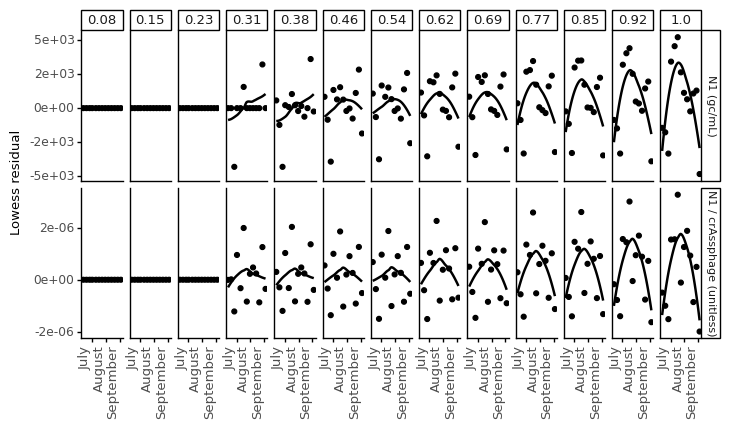

<ggplot: (-9223372036539981806)>

In [13]:
code="K_K_INF"
a=qpcr_loess_dict[code]


a.points=pd.to_numeric(a.points)
a['alpha_v']=a.points/(pK)
a['alpha_rounded']=a.alpha_v.apply(lambda x: round(x,2) ).astype(object) 
lis=["N1", "N1_crAss_reg"]
a=a[a.Target.isin(lis)].copy()

a.loc[a.Target=="N1_crAss", "Target"]= name_N1C
a.loc[a.Target=="N1_crAss_reg", "Target"]= name_N1Cr
a.loc[a.Target=="N1", "Target"]= name_N1

plt = (ggplot(a, aes(x='date_sampling', y='residuals')) + 
    geom_point()+
    geom_smooth(method='loess', span= 1, se=False)+
    facet_grid('Target~alpha_rounded ', scales='free_y')+
    xlab("")+
    scale_x_datetime(date_breaks='1 month',date_labels="%B")+
    scale_y_continuous(labels=scientific_format(digits=0))+
    ylab("Lowess residual")+
    theme_classic()+ theme( strip_text_x = element_text(size=ftl),  strip_text_y = element_text(size=fts), axis_text_x=element_text(rotation=90, hjust=1, size=ftl), figure_size=(8, 4),  axis_title=element_text(size=ftl))) #axis_text_x=element_text(rotation=45, hjust=1), figure_size=(18, 6)) )
    
#choosing points
pts_N1=6
pts_N1C=7
pts_N1Cr=7
alpha_N1=pd.to_numeric(a.loc[a.points==pts_N1, "alpha_v"].unique().item())
alpha_N1C=pd.to_numeric(a.loc[a.points==pts_N1C, "alpha_v"].unique().item())
alpha_N1Cr=pd.to_numeric(a.loc[a.points==pts_N1Cr, "alpha_v"].unique().item())



#title for the plot
n1='Figure_S2A' 
plot1=n1  +'.pdf'
#path for the plot
path=os.path.join(dir, plot1)
#save the plot
plt.save(path)


plt


In [14]:

loess=qpcr_loess_dict[code].copy()

loess_N1=loess[loess.Target=="N1"].copy()
loess_N1["Target"]="N1_int"
loess_N1_int= loess_N1.loc[loess_N1.alpha_v==alpha_N1,].copy().set_index("date_sampling").drop(["points", "alpha_v", "residuals", "Target", "alpha_rounded"], axis=1)
loess_N1_int=loess_N1_int.resample('D').max() #max just places nans because adding dates not subtracting
loess_N1_int["y_pred_int"]=loess_N1_int["y_pred"].interpolate(method='linear')


loess_N1C=loess[loess.Target=="N1_crAss"].copy()
loess_N1C["Target"]="N1C_int"
loess_N1C_int= loess_N1C.loc[loess_N1C.alpha_v==alpha_N1C,].copy().set_index("date_sampling").drop(["points", "alpha_v", "residuals", "Target", "alpha_rounded"], axis=1)
loess_N1C_int=loess_N1C_int.resample('D').max() #max just places nans because adding dates not subtracting
loess_N1C_int["y_pred_int"]=loess_N1C_int["y_pred"].interpolate(method='linear')

loess_N1Cr=loess[loess.Target=="N1_crAss_reg"].copy()
loess_N1Cr["Target"]="N1Cr_int"
loess_N1Cr_int= loess_N1Cr.loc[loess_N1Cr.alpha_v==alpha_N1Cr,].copy().set_index("date_sampling").drop(["points", "alpha_v", "residuals", "Target", "alpha_rounded"], axis=1)
loess_N1Cr_int=loess_N1Cr_int.resample('D').max() #max just places nans because adding dates not subtracting
loess_N1Cr_int["y_pred_int"]=loess_N1Cr_int["y_pred"].interpolate(method='linear')

loess_N1=loess_N1.reset_index(drop=True)
loess_N1C=loess_N1C.reset_index(drop=True)
loess_N1Cr=loess_N1Cr.reset_index(drop=True)
pt=loess_N1.alpha_v.unique()


#merge lowess and case data models to create a dataframe of models
case_model_lookup=qpcr_int[qpcr_int.sample_code==code][["date_sampling","moving_average_new_cases", "moving_average_active_cases","population", "average_flow_MGD"]].copy()
case_model_lookup["mvga_7D_new_cases"]= case_model_lookup["moving_average_new_cases"]
case_model_lookup["mvga_7D_active_cases"]= case_model_lookup["moving_average_active_cases"]
case_model_lookup["mvga_7D_new_cases_norm"]= case_model_lookup["mvga_7D_new_cases"] / case_model_lookup["population"]
case_model_lookup["mvga_7D_active_cases_norm"]= case_model_lookup["mvga_7D_active_cases"] / case_model_lookup["population"]
case_model_lookup=case_model_lookup.copy().drop(["moving_average_new_cases", "moving_average_active_cases"], axis=1)

models_merge= loess_N1C_int.copy().reset_index().drop(["y_pred" ],axis=1)
models_merge.columns=["date_sampling", "N1C_int"]

models_merge2= loess_N1Cr_int.copy().reset_index().drop(["y_pred" ],axis=1)
models_merge2.columns=["date_sampling", "N1Cr_int"]

models_int=loess_N1_int.reset_index().merge(case_model_lookup, how='outer', on='date_sampling')
models_int=models_int.drop("y_pred", axis=1)
models_int.columns=["date_sampling","N1_int", "population", "average_flow_MGD", "new_cases", "active_cases", "new_cases_per_capita", "active_cases_per_capita"]
models_int=models_int.merge(models_merge, how='left', on='date_sampling')
models_int=models_int.merge(models_merge2, how='left', on='date_sampling')

# models_int_long=models_int.copy().melt(id_vars="date_sampling", value_vars=["N1_int", "new_cases", "active_cases","N1C_int"], var_name="Target", value_name="model")
models_int_long=models_int.copy().melt(id_vars="date_sampling", value_vars=["N1_int", "new_cases_per_capita", "active_cases_per_capita","N1C_int", "N1Cr_int"], var_name="Target", value_name="model")


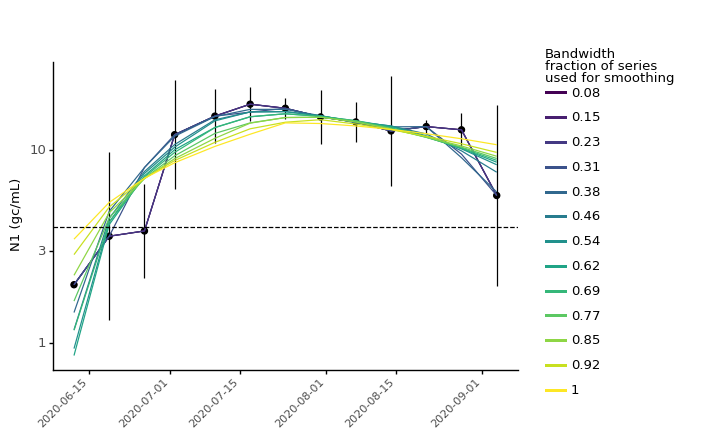

<ggplot: (-9223372036528279541)>

In [15]:
a=qpcr_long_dict[code].copy()
a=a[~np.isnan(a.value)]
b=loess_N1.copy()

t=["N1_int"]

a=a[a.Target.isin(t)]
a.loc[a.Target== "N1_int", "value"]= a.loc[a.Target== "N1_int", "value"]/1000 #convert to gc/mL
a.loc[a.Target=="N1_int", "Target"]= name_N1

b.loc[b.Target== "N1_int", "y_pred"]= b.loc[b.Target== "N1_int", "y_pred"]/1000 #convert to gc/mL
b.loc[b.Target=="N1_int", "Target"]= name_N1

a['ymax']=a.value * a.gstd
a['ymin']=a.value / a.gstd
# 

plt = (ggplot() + 
geom_point(a, aes(x='date_sampling', y='value'))+
geom_pointrange(a, aes(x='date_sampling', y='value', ymin='ymin', ymax='ymax')) +
geom_line(b,aes(x='date_sampling', y='y_pred', color='alpha_rounded'))+
scale_color_cmap_d('viridis')+
geom_hline(yintercept=N1_LoD/1000, linetype='dashed')+
xlab("")+
ylab(name_N1)+
labs(color=name_alpha)+
scale_y_log10()+ 
theme_classic()+ theme(legend_title=element_text(size=ftl),axis_title=element_text(size=ftl), strip_text=element_text(size=ftl), legend_text=element_text(size=ftl),axis_text_x=element_text(rotation=45, hjust=1, size=fts), axis_text_y=element_text(size=ftl), figure_size=(6,4)) )

#title for the plot
n1='Figure_S2B' 
plot1=n1  +'.pdf'
#path for the plot
path=os.path.join(dir, plot1)
#save the plot
plt.save(path)


plt


#### save updated df

In [16]:
N1_crAss_LoD=N1_crAss_LoD_full.loc[N1_crAss_LoD_full.sample_code==code, "crAss_Q3"].copy().item()

a=qpcr_long_dict[code].copy()
a=a[~np.isnan(a.value)]
a=models_int_long.merge(a, how='outer', on=["date_sampling", "Target"])
a=a[(a.date_sampling >= start_dict[code]) & (a.date_sampling <= end_dict[code] + extension_days)]


#conversions
a.loc[a.Target== "N1_int", "value"]= a.loc[a.Target== "N1_int", "value"]/1000 #convert to gc/mL
a.loc[a.Target== "N1_int", "model"]= a.loc[a.Target== "N1_int", "model"]/1000 #convert to gc/mL
a.loc[a.Target== "N1C_int", "value"]= a.loc[a.Target== "N1C_int", "value"]/1000 #convert to gc/mL
a.loc[a.Target== "N1C_int", "model"]= a.loc[a.Target== "N1C_int", "model"]/1000 #convert to gc/mL
# a.loc[a.Target== "N1Cr_int", "value"]= a.loc[a.Target== "N1Cr_int", "value"]/1000 #convert to gc/mL
# a.loc[a.Target== "N1Cr_int", "model"]= a.loc[a.Target== "N1Cr_int", "model"]/1000 #convert to gc/mL
a.loc[a.Target== "new_cases_per_capita", "value"]= a.loc[a.Target== "new_cases_per_capita", "value"]*1000 #convert to per 1000 people
a.loc[a.Target== "new_cases_per_capita", "model"]= a.loc[a.Target== "new_cases_per_capita", "model"]*1000 #convert to per 1000 people

# N1_targs=["N1_int", "N1C_int","N1Cr_int"]
# a["blod_N1"]=np.nan
# a.loc[(a.Target=="N1_int"), "blod_N1"]="N"
# a.loc[(a.Target=="N1_int") & (a.value< (N1_LoD/1000)), "blod_N1"]="Y"
a.loc[np.isnan(a.value), "blod_N1"]= "Not applicable"

t=["N1_int", "N1Cr_int","new_cases_per_capita"]
a=a[a.Target.isin(t)]
a.loc[a.Target=="new_cases_per_capita","N1_und"]="Not applicable"
a.loc[(np.isnan(a.value)),"N1_und"]="Not applicable"
a['Number of amplified technical replicates']= "Not applicable"
a.loc[(a.N1_und != "Not applicable") & (~np.isnan(a.N1_und_total)),'Number of amplified technical replicates']= pd.to_numeric(a.loc[(a.N1_und != "Not applicable") & (~np.isnan(a.N1_und_total)),"N1_und_total"])- pd.to_numeric(a.loc[(a.N1_und != "Not applicable") & (~np.isnan(a.N1_und_total)),"N1_und"])
a['Number of amplified technical replicates']= a['Number of amplified technical replicates'].astype('category')
dates=a.loc[(~np.isnan(a.gstd))&(a.gstd!=1), "date_sampling"]. unique()

a["Target_p"]=a.Target
a.loc[a.Target=="N1C_int", "Target"]= name_N1C_int.format(round(alpha_N1C,2))
a.loc[a.Target=="N1Cr_int", "Target"]= name_N1Cr_int.format(round(alpha_N1Cr,2))
a.loc[a.Target=="N1_int", "Target"]= name_N1_int.format(round(alpha_N1,2))
a.loc[a.Target=="new_cases_per_capita", "Target"]= name_new_cases_norm

a.loc[(a.Target_p=="N1_int") & (a.model< N1_LoD/1000), "model"]= 0.5*(N1_LoD/1000)
a.loc[(a.Target_p=="N1C_int") & (a.model< N1_LoD/1000), "model"]= 0.5*(N1_LoD/1000)
# a.loc[(a.Target_p=="N1Cr_int") & (a.model< N1_LoD/1000), "model"]= 0.5*(N1_LoD/1000)
a.loc[(a.Target_p=="N1Cr_int") & (a.model< N1_crAss_LoD), "model"]= 0.5*(N1_crAss_LoD)


a['ymax']=a.value * a.gstd
a['ymin']=a.value / a.gstd

hlinedf= pd.DataFrame({'Target': [name_N1_int.format(round(alpha_N1,2)),name_N1Cr_int.format(round(alpha_N1Cr,2)),name_new_cases_norm],
        'h_val': [N1_LoD/1000,N1_crAss_LoD,((5.5/pop_dict[code]))*1000], 'color':['black','black','black']
        }, columns = ['Target', 'h_val', 'color'])

# plt = (ggplot() + 
# geom_point(a, aes(x='date_sampling', y='value', shape='Number of amplified technical replicates'), color='black')+
# geom_pointrange(a, aes(x='date_sampling', y='value', ymin='ymin', ymax='ymax', shape='Number of amplified technical replicates'), color='black') +
# geom_line(a, aes(x='date_sampling', y='model', color='Target'), size=lw)+
# geom_hline(hlinedf,aes(yintercept='h_val'), linetype='dashed', color=hlinedf.color)+
# guides(color=False)+
# # labs(shape=legend_N1_und)+
# ylab('')+
# xlab("")+
# scale_color_cmap_d('viridis')+
# scale_y_log10()+
# facet_wrap('~Target', ncol=1, scales="free_y")+ #, 
# theme_classic()+ theme(legend_position='right', strip_text_x = element_text(margin={'t': 15}), axis_text_x=element_text(rotation=45, hjust=1), figure_size=(6, 10)) )

kinf=a.copy()
kinf["lod"]=np.nan
kinf.loc[kinf.Target_p=="N1_int", "lod"]= N1_LoD/1000
kinf.loc[kinf.Target_p=="N1Cr_int", "lod"]= N1_crAss_LoD
kinf.loc[kinf.Target_p=="new_cases_per_capita", "lod"]= (case_LoD/pop_dict[code])*1000
kinf.loc[kinf.Target_p=="active_cases_per_capita", "lod"]= (case_LoD/pop_dict[code])*1000
kinf["location"]="K"


### Location Q

####  Figure S4

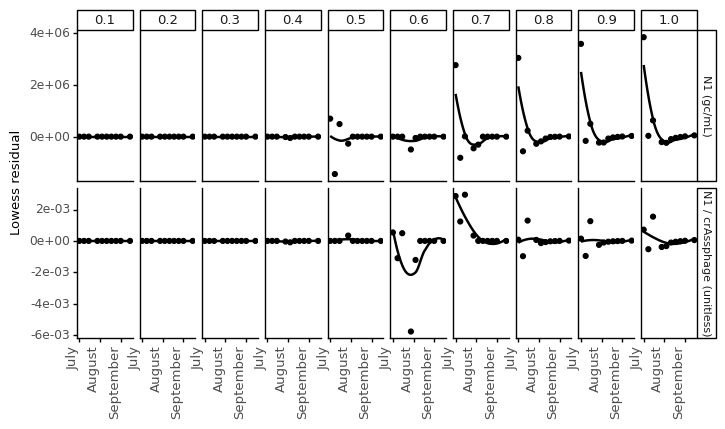

<ggplot: (-9223372036528098984)>

In [17]:
code="B_B_SQ"
a=qpcr_loess_dict[code]

a.points=pd.to_numeric(a.points)
a['alpha_v']=a.points/(pSQ)
a['alpha_rounded']=a.alpha_v.apply(lambda x: round(x,2) ).astype(object)
lis=["N1", "N1_crAss_reg"]
a=a[a.Target.isin(lis)].copy()

a.loc[a.Target=="N1_crAss", "Target"]= name_N1C
a.loc[a.Target=="N1_crAss_reg", "Target"]= name_N1Cr
a.loc[a.Target=="N1", "Target"]= name_N1

plt = (ggplot(a, aes(x='date_sampling', y='residuals')) + 
    geom_point()+
    geom_smooth(method='loess', span= 1, se=False)+
    facet_grid('Target~alpha_rounded ', scales='free_y')+
    xlab("")+
    scale_x_datetime(date_breaks='1 month',date_labels="%B")+
    scale_y_continuous(labels=scientific_format(digits=0))+
    ylab("Lowess residual")+
    theme_classic()+ theme( strip_text_x = element_text(size=ftl),  strip_text_y = element_text(size=fts), axis_text_x=element_text(rotation=90, hjust=1, size=ftl), figure_size=(8, 4),  axis_title=element_text(size=ftl))) 
    
#choosing points
pts_N1=6
pts_N1C=5
pts_N1Cr=5
alpha_N1=pd.to_numeric(a.loc[a.points==pts_N1, "alpha_v"].unique().item())
alpha_N1C=pd.to_numeric(a.loc[a.points==pts_N1C, "alpha_v"].unique().item())
alpha_N1Cr=pd.to_numeric(a.loc[a.points==pts_N1Cr, "alpha_v"].unique().item())



#title for the plot
n1='Figure_S4A' 
plot1=n1  +'.pdf'
#path for the plot
path=os.path.join(dir, plot1)
#save the plot
plt.save(path)


plt

In [18]:

loess=qpcr_loess_dict[code].copy()

loess_N1=loess[loess.Target=="N1"].copy()
loess_N1["Target"]="N1_int"
loess_N1_int= loess_N1.loc[loess_N1.alpha_v==alpha_N1,].copy().set_index("date_sampling").drop(["points", "alpha_v", "residuals", "Target", "alpha_rounded"], axis=1)
loess_N1_int=loess_N1_int.resample('D').max() #max just places nans because adding dates not subtracting
loess_N1_int["y_pred_int"]=loess_N1_int["y_pred"].interpolate(method='linear')


loess_N1C=loess[loess.Target=="N1_crAss"].copy()
loess_N1C["Target"]="N1C_int"
loess_N1C_int= loess_N1C.loc[loess_N1C.alpha_v==alpha_N1C,].copy().set_index("date_sampling").drop(["points", "alpha_v", "residuals", "Target", "alpha_rounded"], axis=1)
loess_N1C_int=loess_N1C_int.resample('D').max() #max just places nans because adding dates not subtracting
loess_N1C_int["y_pred_int"]=loess_N1C_int["y_pred"].interpolate(method='linear')

loess_N1Cr=loess[loess.Target=="N1_crAss_reg"].copy()
loess_N1Cr["Target"]="N1Cr_int"
loess_N1Cr_int= loess_N1Cr.loc[loess_N1Cr.alpha_v==alpha_N1Cr,].copy().set_index("date_sampling").drop(["points", "alpha_v", "residuals", "Target", "alpha_rounded"], axis=1)
loess_N1Cr_int=loess_N1Cr_int.resample('D').max() #max just places nans because adding dates not subtracting
loess_N1Cr_int["y_pred_int"]=loess_N1Cr_int["y_pred"].interpolate(method='linear')

loess_N1=loess_N1.reset_index(drop=True)
loess_N1C=loess_N1C.reset_index(drop=True)
loess_N1Cr=loess_N1Cr.reset_index(drop=True)
pt=loess_N1.alpha_v.unique()


#merge lowess and case data models to create a dataframe of models
case_model_lookup=qpcr_int[qpcr_int.sample_code==code][["date_sampling","moving_average_new_cases", "moving_average_active_cases","population", "average_flow_MGD"]].copy()
case_model_lookup["mvga_7D_new_cases"]= case_model_lookup["moving_average_new_cases"]
case_model_lookup["mvga_7D_active_cases"]= case_model_lookup["moving_average_active_cases"]
case_model_lookup["mvga_7D_new_cases_norm"]= case_model_lookup["mvga_7D_new_cases"] / case_model_lookup["population"]
case_model_lookup["mvga_7D_active_cases_norm"]= case_model_lookup["mvga_7D_active_cases"] / case_model_lookup["population"]
case_model_lookup=case_model_lookup.copy().drop(["moving_average_new_cases", "moving_average_active_cases"], axis=1)

models_merge= loess_N1C_int.copy().reset_index().drop(["y_pred" ],axis=1)
models_merge.columns=["date_sampling", "N1C_int"]

models_merge2= loess_N1Cr_int.copy().reset_index().drop(["y_pred" ],axis=1)
models_merge2.columns=["date_sampling", "N1Cr_int"]

models_int=loess_N1_int.reset_index().merge(case_model_lookup, how='outer', on='date_sampling')
models_int=models_int.drop("y_pred", axis=1)
models_int.columns=["date_sampling","N1_int", "population", "average_flow_MGD", "new_cases", "active_cases", "new_cases_per_capita", "active_cases_per_capita"]
models_int=models_int.merge(models_merge, how='left', on='date_sampling')
models_int=models_int.merge(models_merge2, how='left', on='date_sampling')

# models_int_long=models_int.copy().melt(id_vars="date_sampling", value_vars=["N1_int", "new_cases", "active_cases","N1C_int"], var_name="Target", value_name="model")
models_int_long=models_int.copy().melt(id_vars="date_sampling", value_vars=["N1_int", "new_cases_per_capita", "active_cases_per_capita","N1C_int", "N1Cr_int"], var_name="Target", value_name="model")


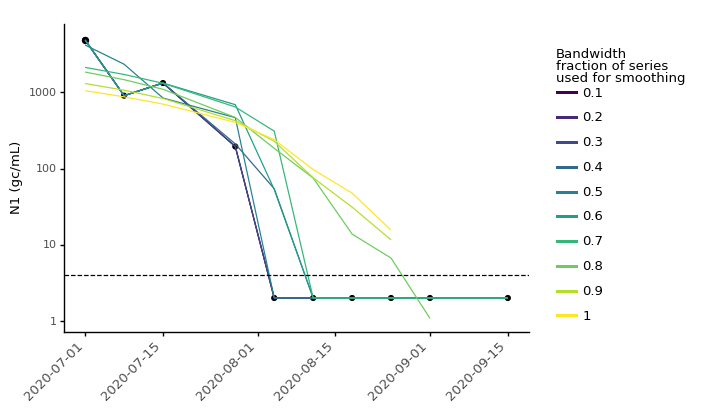

<ggplot: (314943734)>

In [19]:
a=qpcr_long_dict[code].copy()
a=a[~np.isnan(a.value)]
b=loess_N1.copy()

t=["N1_int"]

a=a[a.Target.isin(t)]
a.loc[a.Target== "N1_int", "value"]= a.loc[a.Target== "N1_int", "value"]/1000 #convert to gc/mL
a.loc[a.Target=="N1_int", "Target"]= name_N1

b.loc[b.Target== "N1_int", "y_pred"]= b.loc[b.Target== "N1_int", "y_pred"]/1000 #convert to gc/mL
b.loc[b.Target=="N1_int", "Target"]= name_N1

a['ymax']=a.value * a.gstd
a['ymin']=a.value / a.gstd
# 

plt = (ggplot() + 
geom_point(a, aes(x='date_sampling', y='value'))+
geom_pointrange(a, aes(x='date_sampling', y='value', ymin='ymin', ymax='ymax')) +
geom_line(b,aes(x='date_sampling', y='y_pred', color='alpha_rounded'))+
scale_color_cmap_d('viridis')+
geom_hline(yintercept=N1_LoD/1000, linetype='dashed')+
xlab("")+
ylab(name_N1)+
labs(color=name_alpha)+
scale_y_log10()+ 
theme_classic()+ theme(legend_title=element_text(size=ftl),axis_title=element_text(size=ftl), strip_text=element_text(size=ftl), legend_text=element_text(size=ftl),axis_text_x=element_text(rotation=45, hjust=1, size=ftl), axis_text_y=element_text(size=fts), figure_size=(6,4)) )

#title for the plot
n1='Figure_S4B' 
plot1=n1  +'.pdf'
#path for the plot
path=os.path.join(dir, plot1)
#save the plot
plt.save(path)


plt


#### Figure 5

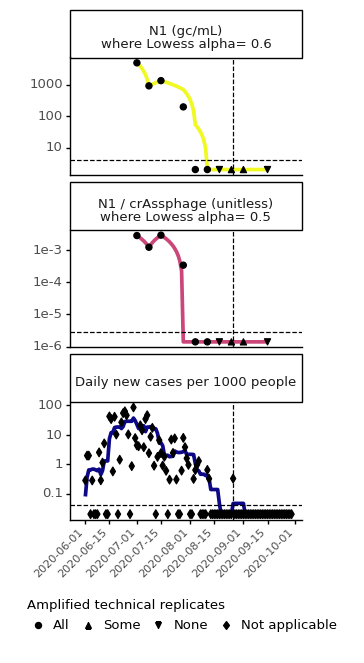

<ggplot: (-9223372036529382645)>

In [20]:
N1_crAss_LoD=N1_crAss_LoD_full.loc[N1_crAss_LoD_full.sample_code==code, "crAss_Q3"].copy().item()


a=qpcr_long_dict[code].copy()
a=a[~np.isnan(a.value)]
a=models_int_long.merge(a, how='outer', on=["date_sampling", "Target"])
a=a[(a.date_sampling >= start_dict[code]) & (a.date_sampling <= end_dict[code] + extension_days)]

#conversions
a.loc[a.Target== "N1_int", "value"]= a.loc[a.Target== "N1_int", "value"]/1000 #convert to gc/mL
a.loc[a.Target== "N1_int", "model"]= a.loc[a.Target== "N1_int", "model"]/1000 #convert to gc/mL
a.loc[a.Target== "N1C_int", "value"]= a.loc[a.Target== "N1C_int", "value"]/1000 #convert to gc/mL
a.loc[a.Target== "N1C_int", "model"]= a.loc[a.Target== "N1C_int", "model"]/1000 #convert to gc/mL
a.loc[a.Target== "new_cases_per_capita", "value"]= a.loc[a.Target== "new_cases_per_capita", "value"]*1000 #convert to per 1000 people
a.loc[a.Target== "new_cases_per_capita", "model"]= a.loc[a.Target== "new_cases_per_capita", "model"]*1000 #convert to per 1000 people
a.loc[a.Target== "active_cases_per_capita", "value"]= a.loc[a.Target== "active_cases_per_capita", "value"]*people #convert to per 1000 people
a.loc[a.Target== "active_cases_per_capita", "model"]= a.loc[a.Target== "active_cases_per_capita", "value"] #because it looks like this is a smoothed model

b=a[a.Target=="N1_int"].copy()
b.Target= "flow"
b.loc[b.Target=="flow", "value"]= b.loc[b.Target=="flow", "value"]*1000*3785411.78*(flow_dict[code]/pop_dict[code])
b.loc[b.Target=="flow", "model"]= b.loc[b.Target=="flow", "model"]*1000*3785411.78*(flow_dict[code]/pop_dict[code])
a=a.append(b)
a.model=pd.to_numeric(a.model)
a.value=pd.to_numeric(a.value)

a.loc[np.isnan(a.value), "blod_N1"]= "Not applicable"
# t=["N1_int", "N1Cr_int","flow","new_cases_per_capita","active_cases_per_capita"]
t=["N1_int", "N1Cr_int","new_cases_per_capita"]
a=a[a.Target.isin(t)]

a["num_amp"] =pd.to_numeric( a['N1_und'])/a['N1_und_total'] #percentage unamplified!!
a.loc[(a.num_amp > 0) & (a.num_amp <1), "num_amp"]= "Some"
a.loc[a.num_amp == 0, "num_amp"]= "All"
a.loc[a.num_amp == 1, "num_amp"]= "None"
a.loc[a.Target=="new_cases_per_capita","num_amp"]="Not applicable"
# a.loc[a.Target=="active_cases_per_capita","num_amp"]="Not applicable"
a.loc[(np.isnan(a.value)),"num_amp"]="Not applicable"
a.num_amp=a.num_amp.astype('category')
a.num_amp=a.num_amp.cat.reorder_categories(["All", "Some", "None", "Not applicable"])

a.loc[a.Target=="new_cases_per_capita","N1_und"]="Not applicable"
# a.loc[a.Target=="active_cases_per_capita","N1_un d"]="Not applicable"
a.loc[(np.isnan(a.value)),"N1_und"]="Not applicable"
a['Number of amplified technical replicates']='Not applicable'
a.loc[(a.N1_und != "Not applicable") & (~np.isnan(a.N1_und_total)),'Number of amplified technical replicates']= pd.to_numeric(a.loc[(a.N1_und != "Not applicable") & (~np.isnan(a.N1_und_total)),"N1_und_total"])- pd.to_numeric(a.loc[(a.N1_und != "Not applicable") & (~np.isnan(a.N1_und_total)),"N1_und"])
a['Number of amplified technical replicates']= a['Number of amplified technical replicates'].astype('category')
dates=a.loc[(~np.isnan(a.gstd))&(a.gstd!=1), "date_sampling"]. unique()

a["Target_p"]=a.Target
a.loc[a.Target=="N1C_int", "Target"]= name_N1C_int.format(round(alpha_N1C,2)) +"\n"
a.loc[a.Target=="N1Cr_int", "Target"]= name_N1Cr_int.format(round(alpha_N1Cr,2))+"\n"
a.loc[a.Target=="N1_int", "Target"]= name_N1_int.format(round(alpha_N1,2))+"\n"
# a.loc[a.Target=="flow", "Target"]= name_N1_flow.format(round(alpha_N1,2))+"\n"
a.loc[a.Target=="new_cases_per_capita", "Target"]= name_new_cases_norm + "\n\n"
# a.loc[a.Target=="active_cases_per_capita", "Target"]= name_active_cases_norm +"\n\n"
a.Target=a.Target.astype('category')
a.Target=a.Target.cat.reorder_categories([name_N1_int.format(round(alpha_N1,2))+"\n",name_N1Cr_int.format(round(alpha_N1Cr,2))+"\n",name_new_cases_norm+ "\n\n"])
# a.Target=a.Target.cat.reorder_categories([name_N1_int.format(round(alpha_N1,2))+"\n",name_N1_flow.format(round(alpha_N1,2))+"\n",name_N1Cr_int.format(round(alpha_N1Cr,2))+"\n",name_new_cases_norm + "\n\n",name_active_cases_norm +"\n\n"])
# *3785411.78*(flow_dict["K_K_INF"]/pop_dict["K_K_INF"])
cases_LoD=(case_LoD_sq/pop_dict[code])*people
a.loc[(a.Target_p=="new_cases_per_capita") & (a.model< cases_LoD), "model"]=((case_LoD_sq/pop_dict[code])/2)*people
a.loc[(a.Target_p=="N1_int") & (a.model< N1_LoD/1000), "model"]= 0.5*(N1_LoD/1000)
a.loc[(a.Target_p=="N1C_int") & (a.model< N1_LoD/1000), "model"]= 0.5*(N1_LoD/1000)
# a.loc[(a.Target_p=="flow") & (a.model< N1_LoD*3785411.78*(flow_dict[code]/pop_dict[code])), "model"]= 0.5*N1_LoD*3785411.78*(flow_dict[code]/pop_dict[code])
a.loc[(a.Target_p=="N1Cr_int") & (a.model< N1_crAss_LoD), "model"]= 0.5*(N1_crAss_LoD)

a['ymax']=a.value * a.gstd
a['ymin']=a.value / a.gstd

# hlinedf= pd.DataFrame({'Target': [name_N1_int.format(round(alpha_N1,2))+"\n", name_N1_flow.format(round(alpha_N1,2))+"\n",name_N1Cr_int.format(round(alpha_N1Cr,2))+"\n",name_new_cases_norm + "\n\n", name_active_cases_norm +"\n\n"],
#         'h_val': [N1_LoD/1000,N1_LoD*3785411.78*(flow_dict[code]/pop_dict[code]),N1_crAss_LoD,((case_LoD_sq/pop_dict[code]))*1000,((case_LoD_sq/pop_dict[code]))*1000], 'color':['black','black','black','black','black']
#         }, columns = ['Target', 'h_val', 'color'])
hlinedf= pd.DataFrame({'Target': [name_N1_int.format(round(alpha_N1,2))+"\n",name_N1Cr_int.format(round(alpha_N1Cr,2))+"\n",name_new_cases_norm + "\n\n"],
        'h_val': [N1_LoD/1000,N1_crAss_LoD,((case_LoD_sq/pop_dict[code]))*1000], 'color':['black','black','black']
        }, columns = ['Target', 'h_val', 'color'])

hlinedf.Target=hlinedf.Target.astype('category')
# hlinedf.Target=hlinedf.Target.cat.reorder_categories([name_N1_int.format(round(alpha_N1,2))+"\n",name_N1_flow.format(round(alpha_N1,2))+"\n",name_N1Cr_int.format(round(alpha_N1Cr,2))+"\n",name_new_cases_norm + "\n\n",name_active_cases_norm +"\n\n"])
hlinedf.Target=hlinedf.Target.cat.reorder_categories([name_N1_int.format(round(alpha_N1,2))+"\n",name_N1Cr_int.format(round(alpha_N1Cr,2))+"\n",name_new_cases_norm + "\n\n"])

plt = (ggplot() + 
geom_line(a, aes(x='date_sampling', y='model', color='Target'), size=1.5)+
geom_point(a, aes(x='date_sampling', y='value', shape='num_amp'),size=2, color='black')+
geom_hline(hlinedf,aes(yintercept='h_val'), linetype='dashed', color=hlinedf.color)+
geom_vline(xintercept=pd.to_datetime('2020-08-26'), linetype='dashed', color='black')+
guides(color=False)+
ylab('')+
xlab("")+
scale_color_cmap_d('plasma_r')+
scale_y_log10()+
labs(shape="Amplified technical replicates")+
facet_wrap('~Target', ncol=1, scales="free_y")+ #, 
scale_shape_manual(["o","^","v","d" ])+
theme_classic()+
theme(legend_position=(.5, -.05),legend_direction='horizontal', strip_text_x = element_text(margin={'t': 25}), legend_title=element_text(size=ftl),axis_title=element_text(size=ftl), strip_text=element_text(size=ftl), legend_text=element_text(size=ftl),axis_text_x=element_text(rotation=45, hjust=1, size=fts), axis_text_y=element_text(size=ftl), figure_size=(3,6)))


#title for the plot
n1='Figure_5' 
plot1=n1  +'.pdf'
#path for the plot
path=os.path.join(dir, plot1)
#save the plot
plt.save(path)


plt



#### save updated df

In [21]:
N1_crAss_LoD=N1_crAss_LoD_full.loc[N1_crAss_LoD_full.sample_code==code, "crAss_Q3"].copy().item()


a=qpcr_long_dict[code].copy()
a=a[~np.isnan(a.value)]
a=models_int_long.merge(a, how='outer', on=["date_sampling", "Target"])
a=a[(a.date_sampling >= start_dict[code]) & (a.date_sampling <= end_dict[code] + extension_days)]

#conversions
a.loc[a.Target== "N1_int", "value"]= a.loc[a.Target== "N1_int", "value"]/1000 #convert to gc/mL
a.loc[a.Target== "N1_int", "model"]= a.loc[a.Target== "N1_int", "model"]/1000 #convert to gc/mL
a.loc[a.Target== "N1C_int", "value"]= a.loc[a.Target== "N1C_int", "value"]/1000 #convert to gc/mL
a.loc[a.Target== "N1C_int", "model"]= a.loc[a.Target== "N1C_int", "model"]/1000 #convert to gc/mL
a.loc[a.Target== "new_cases_per_capita", "value"]= a.loc[a.Target== "new_cases_per_capita", "value"]*1000 #convert to per 1000 people
a.loc[a.Target== "new_cases_per_capita", "model"]= a.loc[a.Target== "new_cases_per_capita", "model"]*1000 #convert to per 1000 people
a.loc[a.Target== "active_cases_per_capita", "value"]= a.loc[a.Target== "active_cases_per_capita", "value"]*people #convert to per 1000 people
a.loc[a.Target== "active_cases_per_capita", "model"]= a.loc[a.Target== "active_cases_per_capita", "value"] #because it looks like this is a smoothed model

b=a[a.Target=="N1_int"].copy()
b.Target= "flow"
b.loc[b.Target=="flow", "value"]= b.loc[b.Target=="flow", "value"]*1000*3785411.78*(flow_dict[code]/pop_dict[code])
b.loc[b.Target=="flow", "model"]= b.loc[b.Target=="flow", "model"]*1000*3785411.78*(flow_dict[code]/pop_dict[code])
a=a.append(b)
a.model=pd.to_numeric(a.model)
a.value=pd.to_numeric(a.value)

a.loc[np.isnan(a.value), "blod_N1"]= "Not applicable"
# t=["N1_int", "N1Cr_int","flow","new_cases_per_capita","active_cases_per_capita"]
t=["N1_int", "N1Cr_int","new_cases_per_capita","active_cases_per_capita"]
a=a[a.Target.isin(t)]

a["num_amp"] =pd.to_numeric( a['N1_und'])/a['N1_und_total'] #percentage unamplified!!
a.loc[(a.num_amp > 0) & (a.num_amp <1), "num_amp"]= "Some"
a.loc[a.num_amp == 0, "num_amp"]= "All"
a.loc[a.num_amp == 1, "num_amp"]= "None"
a.loc[a.Target=="new_cases_per_capita","num_amp"]="Not applicable"
a.loc[a.Target=="active_cases_per_capita","num_amp"]="Not applicable"
a.loc[(np.isnan(a.value)),"num_amp"]="Not applicable"
a.num_amp=a.num_amp.astype('category')
a.num_amp=a.num_amp.cat.reorder_categories(["All", "Some", "None", "Not applicable"])

a.loc[a.Target=="new_cases_per_capita","N1_und"]="Not applicable"
a.loc[a.Target=="active_cases_per_capita","N1_und"]="Not applicable"
a.loc[(np.isnan(a.value)),"N1_und"]="Not applicable"
a['Number of amplified technical replicates']='Not applicable'
a.loc[(a.N1_und != "Not applicable") & (~np.isnan(a.N1_und_total)),'Number of amplified technical replicates']= pd.to_numeric(a.loc[(a.N1_und != "Not applicable") & (~np.isnan(a.N1_und_total)),"N1_und_total"])- pd.to_numeric(a.loc[(a.N1_und != "Not applicable") & (~np.isnan(a.N1_und_total)),"N1_und"])
a['Number of amplified technical replicates']= a['Number of amplified technical replicates'].astype('category')
dates=a.loc[(~np.isnan(a.gstd))&(a.gstd!=1), "date_sampling"]. unique()

a["Target_p"]=a.Target
a.loc[a.Target=="N1C_int", "Target"]= name_N1C_int.format(round(alpha_N1C,2)) +"\n"
a.loc[a.Target=="N1Cr_int", "Target"]= name_N1Cr_int.format(round(alpha_N1Cr,2))+"\n"
a.loc[a.Target=="N1_int", "Target"]= name_N1_int.format(round(alpha_N1,2))+"\n"
# a.loc[a.Target=="flow", "Target"]= name_N1_flow.format(round(alpha_N1,2))+"\n"
a.loc[a.Target=="new_cases_per_capita", "Target"]= name_new_cases_norm + "\n\n"
a.loc[a.Target=="active_cases_per_capita", "Target"]= name_active_cases_norm +"\n\n"
a.Target=a.Target.astype('category')
a.Target=a.Target.cat.reorder_categories([name_N1_int.format(round(alpha_N1,2))+"\n",name_N1Cr_int.format(round(alpha_N1Cr,2))+"\n",name_new_cases_norm + "\n\n",name_active_cases_norm +"\n\n"])
# a.Target=a.Target.cat.reorder_categories([name_N1_int.format(round(alpha_N1,2))+"\n",name_N1_flow.format(round(alpha_N1,2))+"\n",name_N1Cr_int.format(round(alpha_N1Cr,2))+"\n",name_new_cases_norm + "\n\n",name_active_cases_norm +"\n\n"])
# *3785411.78*(flow_dict["K_K_INF"]/pop_dict["K_K_INF"])
cases_LoD=(case_LoD_sq/pop_dict[code])*people
a.loc[(a.Target_p=="new_cases_per_capita") & (a.model< cases_LoD), "model"]=((case_LoD_sq/pop_dict[code])/2)*people
a.loc[(a.Target_p=="N1_int") & (a.model< N1_LoD/1000), "model"]= 0.5*(N1_LoD/1000)
a.loc[(a.Target_p=="N1C_int") & (a.model< N1_LoD/1000), "model"]= 0.5*(N1_LoD/1000)
# a.loc[(a.Target_p=="flow") & (a.model< N1_LoD*3785411.78*(flow_dict[code]/pop_dict[code])), "model"]= 0.5*N1_LoD*3785411.78*(flow_dict[code]/pop_dict[code])
a.loc[(a.Target_p=="N1Cr_int") & (a.model< N1_crAss_LoD), "model"]= 0.5*(N1_crAss_LoD)

a['ymax']=a.value * a.gstd
a['ymin']=a.value / a.gstd

# hlinedf= pd.DataFrame({'Target': [name_N1_int.format(round(alpha_N1,2))+"\n", name_N1_flow.format(round(alpha_N1,2))+"\n",name_N1Cr_int.format(round(alpha_N1Cr,2))+"\n",name_new_cases_norm + "\n\n", name_active_cases_norm +"\n\n"],
#         'h_val': [N1_LoD/1000,N1_LoD*3785411.78*(flow_dict[code]/pop_dict[code]),N1_crAss_LoD,((case_LoD_sq/pop_dict[code]))*1000,((case_LoD_sq/pop_dict[code]))*1000], 'color':['black','black','black','black','black']
#         }, columns = ['Target', 'h_val', 'color'])
hlinedf= pd.DataFrame({'Target': [name_N1_int.format(round(alpha_N1,2))+"\n",name_N1Cr_int.format(round(alpha_N1Cr,2))+"\n",name_new_cases_norm + "\n\n", name_active_cases_norm +"\n\n"],
        'h_val': [N1_LoD/1000,N1_crAss_LoD,((case_LoD_sq/pop_dict[code]))*1000,((case_LoD_sq/pop_dict[code]))*1000], 'color':['black','black','black','black']
        }, columns = ['Target', 'h_val', 'color'])

hlinedf.Target=hlinedf.Target.astype('category')
# hlinedf.Target=hlinedf.Target.cat.reorder_categories([name_N1_int.format(round(alpha_N1,2))+"\n",name_N1_flow.format(round(alpha_N1,2))+"\n",name_N1Cr_int.format(round(alpha_N1Cr,2))+"\n",name_new_cases_norm + "\n\n",name_active_cases_norm +"\n\n"])
hlinedf.Target=hlinedf.Target.cat.reorder_categories([name_N1_int.format(round(alpha_N1,2))+"\n",name_N1Cr_int.format(round(alpha_N1Cr,2))+"\n",name_new_cases_norm + "\n\n",name_active_cases_norm +"\n\n"])

# plt = (ggplot() + 
# geom_line(a, aes(x='date_sampling', y='model', color='Target'), size=1.5)+
# geom_point(a, aes(x='date_sampling', y='value', shape='num_amp'),size=2, color='black')+
# geom_hline(hlinedf,aes(yintercept='h_val'), linetype='dashed', color=hlinedf.color)+
# geom_vline(xintercept=pd.to_datetime('2020-08-26'), linetype='dashed', color='black')+
# guides(color=False)+
# ylab('')+
# xlab("")+
# scale_color_cmap_d('plasma_r')+
# scale_y_log10()+
# labs(shape="Amplified technical replicates")+
# facet_wrap('~Target', ncol=1, scales="free_y")+ #, 
# scale_shape_manual(["o","^","v","d" ])+
# theme_classic()+
# theme(legend_position=(.5, -.005),legend_direction='horizontal', strip_text_x = element_text(margin={'t': 25}), axis_text_x=element_text(rotation=45, hjust=1), figure_size=(3, 9),  axis_title=element_text(size=10)) )

sq=a.copy()
sq=sq[sq.Target_p!="flow"].copy()
sq["lod"]=np.nan
sq.loc[sq.Target_p=="N1_int", "lod"]= N1_LoD/1000
sq.loc[sq.Target_p=="N1Cr_int", "lod"]= N1_crAss_LoD
sq.loc[sq.Target_p=="new_cases_per_capita", "lod"]= (case_LoD_sq/pop_dict[code])*1000
sq.loc[sq.Target_p=="active_cases_per_capita", "lod"]= (case_LoD_sq/pop_dict[code])*1000
sq["location"]="Q"



### Location S

#### Figure S3

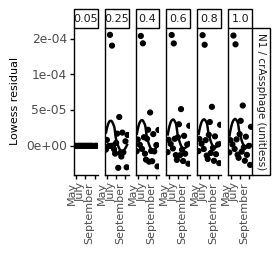

<ggplot: (327097983)>

In [22]:
code="C_C_S68"
a=qpcr_loess_dict[code]



a.points=pd.to_numeric(a.points)
a['alpha_v']=a.points/(pS)
a['alpha_rounded']=a.alpha_v.apply(lambda x: round(x,2) ).astype(object)
lis=["N1", "N1_crAss", "N1_crAss_reg"]
lis=["N1", "N1_crAss_reg"]
a=a[a.Target.isin(lis)].copy()

a.loc[a.Target=="N1_crAss", "Target"]= name_N1C
a.loc[a.Target=="N1_crAss_reg", "Target"]= name_N1Cr
a.loc[a.Target=="N1", "Target"]= name_N1

b=a
b=b[b.Target==name_N1Cr]

alp=[0.05,0.25, 0.4,0.6, 0.8,1]
b=b[b.alpha_rounded.isin(alp)]
plt = (ggplot(b, aes(x='date_sampling', y='residuals')) + 
    geom_point()+
    geom_smooth(method='loess', span= 1, se=False)+
    facet_grid('Target~alpha_rounded ', scales='free_y')+
    xlab("")+
    scale_x_datetime(date_breaks='2 month',date_labels="%B")+
    scale_y_continuous(labels=scientific_format(digits=0))+
    ylab("Lowess residual")+
    theme_classic()+ theme( strip_text_x = element_text(size=fts),  strip_text_y = element_text(size=7.5), axis_text_x=element_text(rotation=90, hjust=1, size=fts), figure_size=(2.3, 1.9),  axis_title=element_text(size=fts)))


#title for the plot
n1='Figure_S3C' 
plot1=n1  +'.pdf'
#path for the plot
path=os.path.join(dir, plot1)
#save the plot
plt.save(path)


plt

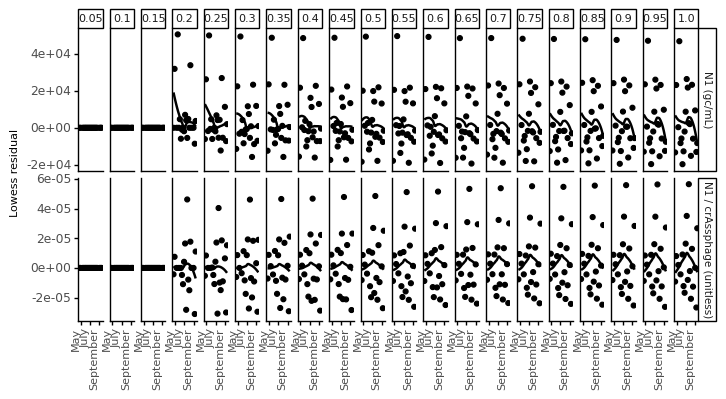

<ggplot: (-9223372036528180771)>

In [23]:
a.loc[(a.Target==name_N1Cr)& (a.residuals>0.00010), "residuals"]=np.nan

plt = (ggplot(a, aes(x='date_sampling', y='residuals')) + 
    geom_point()+
    geom_smooth(method='loess', span= 1, se=False)+
    facet_grid('Target~alpha_rounded ', scales='free_y')+
    xlab("")+
    scale_x_datetime(date_breaks='2 month',date_labels="%B")+
    scale_y_continuous(labels=scientific_format(digits=0))+
    ylab("Lowess residual")+
    theme_classic()+ theme( strip_text_x = element_text(size=fts),  strip_text_y = element_text(size=7.5), axis_text_x=element_text(rotation=90, hjust=1, size=fts), figure_size=(8, 3.8),  axis_title=element_text(size=fts))) 
    
#choosing points
pts_N1=9
pts_N1C=5
pts_N1Cr=5
alpha_N1=pd.to_numeric(a.loc[a.points==pts_N1, "alpha_v"].unique().item())
alpha_N1C=pd.to_numeric(a.loc[a.points==pts_N1C, "alpha_v"].unique().item())
alpha_N1Cr=pd.to_numeric(a.loc[a.points==pts_N1Cr, "alpha_v"].unique().item())


#title for the plot
n1='Figure_S3A' 
plot1=n1  +'.pdf'
#path for the plot
path=os.path.join(dir, plot1)
#save the plot
plt.save(path)


plt

In [24]:

loess=qpcr_loess_dict[code].copy()

loess_N1=loess[loess.Target=="N1"].copy()
loess_N1["Target"]="N1_int"
loess_N1_int= loess_N1.loc[loess_N1.alpha_v==alpha_N1,].copy().set_index("date_sampling").drop(["points", "alpha_v", "residuals", "Target", "alpha_rounded"], axis=1)
loess_N1_int=loess_N1_int.resample('D').max() #max just places nans because adding dates not subtracting
loess_N1_int["y_pred_int"]=loess_N1_int["y_pred"].interpolate(method='linear')


loess_N1C=loess[loess.Target=="N1_crAss"].copy()
loess_N1C["Target"]="N1C_int"
loess_N1C_int= loess_N1C.loc[loess_N1C.alpha_v==alpha_N1C,].copy().set_index("date_sampling").drop(["points", "alpha_v", "residuals", "Target", "alpha_rounded"], axis=1)
loess_N1C_int=loess_N1C_int.resample('D').max() #max just places nans because adding dates not subtracting
loess_N1C_int["y_pred_int"]=loess_N1C_int["y_pred"].interpolate(method='linear')

loess_N1Cr=loess[loess.Target=="N1_crAss_reg"].copy()
loess_N1Cr["Target"]="N1Cr_int"
loess_N1Cr_int= loess_N1Cr.loc[loess_N1Cr.alpha_v==alpha_N1Cr,].copy().set_index("date_sampling").drop(["points", "alpha_v", "residuals", "Target", "alpha_rounded"], axis=1)
loess_N1Cr_int=loess_N1Cr_int.resample('D').max() #max just places nans because adding dates not subtracting
loess_N1Cr_int["y_pred_int"]=loess_N1Cr_int["y_pred"].interpolate(method='linear')

loess_N1=loess_N1.reset_index(drop=True)
loess_N1C=loess_N1C.reset_index(drop=True)
loess_N1Cr=loess_N1Cr.reset_index(drop=True)
pt=loess_N1.alpha_v.unique()


#merge lowess and case data models to create a dataframe of models
case_model_lookup=qpcr_int[qpcr_int.sample_code==code][["date_sampling","moving_average_new_cases", "moving_average_active_cases","population", "average_flow_MGD"]].copy()
case_model_lookup["mvga_7D_new_cases"]= case_model_lookup["moving_average_new_cases"]
case_model_lookup["mvga_7D_active_cases"]= case_model_lookup["moving_average_active_cases"]
case_model_lookup["mvga_7D_new_cases_norm"]= case_model_lookup["mvga_7D_new_cases"] / case_model_lookup["population"]
case_model_lookup["mvga_7D_active_cases_norm"]= case_model_lookup["mvga_7D_active_cases"] / case_model_lookup["population"]
case_model_lookup=case_model_lookup.copy().drop(["moving_average_new_cases", "moving_average_active_cases"], axis=1)

models_merge= loess_N1C_int.copy().reset_index().drop(["y_pred" ],axis=1)
models_merge.columns=["date_sampling", "N1C_int"]

models_merge2= loess_N1Cr_int.copy().reset_index().drop(["y_pred" ],axis=1)
models_merge2.columns=["date_sampling", "N1Cr_int"]

models_int=loess_N1_int.reset_index().merge(case_model_lookup, how='outer', on='date_sampling')
models_int=models_int.drop("y_pred", axis=1)
models_int.columns=["date_sampling","N1_int", "population", "average_flow_MGD", "new_cases", "active_cases", "new_cases_per_capita", "active_cases_per_capita"]
models_int=models_int.merge(models_merge, how='left', on='date_sampling')
models_int=models_int.merge(models_merge2, how='left', on='date_sampling')

# models_int_long=models_int.copy().melt(id_vars="date_sampling", value_vars=["N1_int", "new_cases", "active_cases","N1C_int"], var_name="Target", value_name="model")
models_int_long=models_int.copy().melt(id_vars="date_sampling", value_vars=["N1_int", "new_cases_per_capita", "active_cases_per_capita","N1C_int", "N1Cr_int"], var_name="Target", value_name="model")


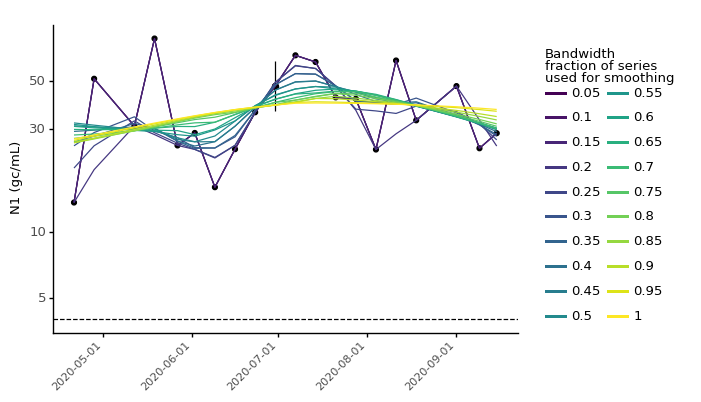

<ggplot: (-9223372036527962252)>

In [25]:
a=qpcr_long_dict[code].copy()
a=a[~np.isnan(a.value)]
b=loess_N1.copy()

t=["N1_int"]

a=a[a.Target.isin(t)]
a.loc[a.Target== "N1_int", "value"]= a.loc[a.Target== "N1_int", "value"]/1000 #convert to gc/mL
a.loc[a.Target=="N1_int", "Target"]= name_N1

b.loc[b.Target== "N1_int", "y_pred"]= b.loc[b.Target== "N1_int", "y_pred"]/1000 #convert to gc/mL
b.loc[b.Target=="N1_int", "Target"]= name_N1

a['ymax']=a.value * a.gstd
a['ymin']=a.value / a.gstd
# 

plt = (ggplot() + 
geom_point(a, aes(x='date_sampling', y='value'))+
geom_pointrange(a, aes(x='date_sampling', y='value', ymin='ymin', ymax='ymax')) +
geom_line(b,aes(x='date_sampling', y='y_pred', color='alpha_rounded'))+
scale_color_cmap_d('viridis')+
geom_hline(yintercept=N1_LoD/1000, linetype='dashed')+
xlab("")+
ylab(name_N1)+
labs(color=name_alpha)+
guides(color=guide_legend(ncol=2))+
scale_y_log10()+
theme_classic()+ theme(legend_title=element_text(size=ftl),axis_title=element_text(size=ftl), strip_text=element_text(size=ftl), legend_text=element_text(size=ftl),axis_text_x=element_text(rotation=45, hjust=1, size=fts), axis_text_y=element_text(size=ftl), figure_size=(6,4)) )

#title for the plot
n1='Figure_S3B' 
plot1=n1  +'.pdf'
#path for the plot
path=os.path.join(dir, plot1)
#save the plot
plt.save(path)


plt

#### save updated df

In [26]:
N1_crAss_LoD=N1_crAss_LoD_full.loc[N1_crAss_LoD_full.sample_code==code, "crAss_Q3"].copy().item()

a=qpcr_long_dict[code].copy()
a=a[~np.isnan(a.value)]
a=models_int_long.merge(a, how='outer', on=["date_sampling", "Target"])
a=a[(a.date_sampling >= start_dict[code]) & (a.date_sampling <= end_dict[code] + extension_days)]


#conversions
a.loc[a.Target== "N1_int", "value"]= a.loc[a.Target== "N1_int", "value"]/1000 #convert to gc/mL
a.loc[a.Target== "N1_int", "model"]= a.loc[a.Target== "N1_int", "model"]/1000 #convert to gc/mL
a.loc[a.Target== "N1C_int", "value"]= a.loc[a.Target== "N1C_int", "value"]/1000 #convert to gc/mL
a.loc[a.Target== "N1C_int", "model"]= a.loc[a.Target== "N1C_int", "model"]/1000 #convert to gc/mL
# a.loc[a.Target== "N1Cr_int", "value"]= a.loc[a.Target== "N1Cr_int", "value"]/1000 #convert to gc/mL
# a.loc[a.Target== "N1Cr_int", "model"]= a.loc[a.Target== "N1Cr_int", "model"]/1000 #convert to gc/mL
a.loc[a.Target== "new_cases_per_capita", "value"]= a.loc[a.Target== "new_cases_per_capita", "value"]*1000 #convert to per 1000 people
a.loc[a.Target== "new_cases_per_capita", "model"]= a.loc[a.Target== "new_cases_per_capita", "model"]*1000 #convert to per 1000 people



# N1_targs=["N1_int", "N1C_int"]
# a["blod_N1"]=np.nan
# a.loc[(a.Target.isin(N1_targs)), "blod_N1"]="N"
# a.loc[(a.Target.isin(N1_targs)) & (a.value< (N1_LoD/1000)), "blod_N1"]="Y"
a.loc[np.isnan(a.value), "blod_N1"]= "Not applicable"

t=["N1_int", "N1Cr_int","new_cases_per_capita"]
a=a[a.Target.isin(t)]
a.loc[a.Target=="new_cases_per_capita","N1_und"]="Not applicable"
a.loc[(np.isnan(a.value)),"N1_und"]="Not applicable"
a['Number of amplified technical replicates']= "Not applicable"
a.loc[(a.N1_und != "Not applicable") & (~np.isnan(a.N1_und_total)),'Number of amplified technical replicates']= pd.to_numeric(a.loc[(a.N1_und != "Not applicable") & (~np.isnan(a.N1_und_total)),"N1_und_total"])- pd.to_numeric(a.loc[(a.N1_und != "Not applicable") & (~np.isnan(a.N1_und_total)),"N1_und"])
a['Number of amplified technical replicates']= a['Number of amplified technical replicates'].astype('category')
dates=a.loc[(~np.isnan(a.gstd))&(a.gstd!=1), "date_sampling"]. unique()

a["Target_p"]=a.Target
a.loc[a.Target=="N1C_int", "Target"]= name_N1C_int.format(round(alpha_N1C,2))
a.loc[a.Target=="N1Cr_int", "Target"]= name_N1Cr_int.format(round(alpha_N1Cr,2))
a.loc[a.Target=="N1_int", "Target"]= name_N1_int.format(round(alpha_N1,2))
a.loc[a.Target=="new_cases_per_capita", "Target"]= name_new_cases_norm

cases_LoD=(case_LoD/pop_dict[code])*people
a.loc[(a.Target_p=="new_cases_per_capita") & (a.model< cases_LoD), "model"]=((case_LoD/pop_dict[code])/2)*people
a.loc[(a.Target_p=="N1_int") & (a.model< N1_LoD/1000), "model"]= 0.5*(N1_LoD/1000)
a.loc[(a.Target_p=="N1C_int") & (a.model< N1_LoD/1000), "model"]= 0.5*(N1_LoD/1000)
# a.loc[(a.Target_p=="N1Cr_int") & (a.model< N1_LoD/1000), "model"]= 0.5*(N1_LoD/1000)
a.loc[(a.Target_p=="N1Cr_int") & (a.model< N1_crAss_LoD), "model"]= 0.5*(N1_crAss_LoD)


a['ymax']=a.value * a.gstd
a['ymin']=a.value / a.gstd

hlinedf= pd.DataFrame({'Target': [name_N1_int.format(round(alpha_N1,2)), name_N1Cr_int.format(round(alpha_N1Cr,2)),name_new_cases_norm],
        'h_val': [N1_LoD/1000,N1_crAss_LoD,((case_LoD/pop_dict[code]))*1000], 'color':['black','black','black']
        }, columns = ['Target', 'h_val', 'color'])

# plt = (ggplot() + 
# geom_point(a, aes(x='date_sampling', y='value', shape='Number of amplified technical replicates'), color='black')+
# geom_line(a, aes(x='date_sampling', y='model', color='Target'), size=lw)+
# geom_hline(hlinedf,aes(yintercept='h_val'), linetype='dashed', color=hlinedf.color)+
# guides(color=False)+
# # labs(shape=legend_N1_und)+
# ylab('')+
# xlab("")+
# scale_color_cmap_d('viridis')+
# scale_y_log10()+
# facet_wrap('~Target', ncol=1, scales="free_y")+ #, 
# theme_classic()+ theme(legend_position='right', strip_text_x = element_text(margin={'t': 15}), axis_text_x=element_text(rotation=45, hjust=1), figure_size=(6, 10)) )

s68=a.copy()
s68["lod"]=np.nan
s68.loc[s68.Target_p=="N1_int", "lod"]= N1_LoD/1000
s68.loc[s68.Target_p=="N1Cr_int", "lod"]= N1_crAss_LoD
s68.loc[s68.Target_p=="new_cases_per_capita", "lod"]= (case_LoD/pop_dict[code])*1000
s68.loc[s68.Target_p=="active_cases_per_capita", "lod"]= (case_LoD/pop_dict[code])*1000
s68["location"]="S"


### Location N

#### Figure 3

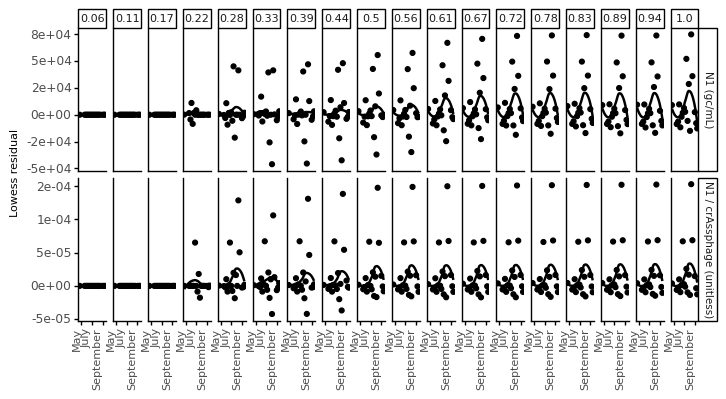

<ggplot: (-9223372036529218970)>

In [27]:
code="C_C_N49"
a=qpcr_loess_dict[code]


a.points=pd.to_numeric(a.points)
a['alpha_v']=a.points/(pN)
a['alpha_rounded']=a.alpha_v.apply(lambda x: round(x,2) ).astype(object)
lis=["N1", "N1_crAss_reg"]
a=a[a.Target.isin(lis)].copy()

a.loc[a.Target=="N1_crAss", "Target"]= name_N1C
a.loc[a.Target=="N1_crAss_reg", "Target"]= name_N1Cr
a.loc[a.Target=="N1", "Target"]= name_N1

plt = (ggplot(a, aes(x='date_sampling', y='residuals')) + 
    geom_point()+
    geom_smooth(method='loess', span= 1, se=False)+
    facet_grid('Target~alpha_rounded ', scales='free_y')+
    xlab("")+
    scale_x_datetime(date_breaks='2 month',date_labels="%B")+
    scale_y_continuous(labels=scientific_format(digits=0))+
    ylab("Lowess residual")+
    theme_classic()+ theme( strip_text_x = element_text(size=fts),  strip_text_y = element_text(size=7.5), axis_text_x=element_text(rotation=90, hjust=1, size=fts), figure_size=(8, 3.8),  axis_title=element_text(size=fts))) 
    
#choosing points
pts_N1=7
pts_N1C=6
pts_N1Cr=6
alpha_N1=pd.to_numeric(a.loc[a.points==pts_N1, "alpha_v"].unique().item())
alpha_N1C=pd.to_numeric(a.loc[a.points==pts_N1C, "alpha_v"].unique().item())
alpha_N1Cr=pd.to_numeric(a.loc[a.points==pts_N1Cr, "alpha_v"].unique().item())




#title for the plot
n1='Figure_3A' 
plot1=n1  +'.pdf'
#path for the plot
path=os.path.join(dir, plot1)
#save the plot
plt.save(path)


plt

In [28]:

loess=qpcr_loess_dict[code].copy()

loess_N1=loess[loess.Target=="N1"].copy()
loess_N1["Target"]="N1_int"
loess_N1_int= loess_N1.loc[loess_N1.alpha_v==alpha_N1,].copy().set_index("date_sampling").drop(["points", "alpha_v", "residuals", "Target", "alpha_rounded"], axis=1)
loess_N1_int=loess_N1_int.resample('D').max() #max just places nans because adding dates not subtracting
loess_N1_int["y_pred_int"]=loess_N1_int["y_pred"].interpolate(method='linear')


loess_N1C=loess[loess.Target=="N1_crAss"].copy()
loess_N1C["Target"]="N1C_int"
loess_N1C_int= loess_N1C.loc[loess_N1C.alpha_v==alpha_N1C,].copy().set_index("date_sampling").drop(["points", "alpha_v", "residuals", "Target", "alpha_rounded"], axis=1)
loess_N1C_int=loess_N1C_int.resample('D').max() #max just places nans because adding dates not subtracting
loess_N1C_int["y_pred_int"]=loess_N1C_int["y_pred"].interpolate(method='linear')

loess_N1Cr=loess[loess.Target=="N1_crAss_reg"].copy()
loess_N1Cr["Target"]="N1Cr_int"
loess_N1Cr_int= loess_N1Cr.loc[loess_N1Cr.alpha_v==alpha_N1Cr,].copy().set_index("date_sampling").drop(["points", "alpha_v", "residuals", "Target", "alpha_rounded"], axis=1)
loess_N1Cr_int=loess_N1Cr_int.resample('D').max() #max just places nans because adding dates not subtracting
loess_N1Cr_int["y_pred_int"]=loess_N1Cr_int["y_pred"].interpolate(method='linear')

loess_N1=loess_N1.reset_index(drop=True)
loess_N1C=loess_N1C.reset_index(drop=True)
loess_N1Cr=loess_N1Cr.reset_index(drop=True)
pt=loess_N1.alpha_v.unique()


#merge lowess and case data models to create a dataframe of models
case_model_lookup=qpcr_int[qpcr_int.sample_code==code][["date_sampling","moving_average_new_cases", "moving_average_active_cases","population", "average_flow_MGD"]].copy()
case_model_lookup["mvga_7D_new_cases"]= case_model_lookup["moving_average_new_cases"]
case_model_lookup["mvga_7D_active_cases"]= case_model_lookup["moving_average_active_cases"]
case_model_lookup["mvga_7D_new_cases_norm"]= case_model_lookup["mvga_7D_new_cases"] / case_model_lookup["population"]
case_model_lookup["mvga_7D_active_cases_norm"]= case_model_lookup["mvga_7D_active_cases"] / case_model_lookup["population"]
case_model_lookup=case_model_lookup.copy().drop(["moving_average_new_cases", "moving_average_active_cases"], axis=1)

models_merge= loess_N1C_int.copy().reset_index().drop(["y_pred" ],axis=1)
models_merge.columns=["date_sampling", "N1C_int"]

models_merge2= loess_N1Cr_int.copy().reset_index().drop(["y_pred" ],axis=1)
models_merge2.columns=["date_sampling", "N1Cr_int"]

models_int=loess_N1_int.reset_index().merge(case_model_lookup, how='outer', on='date_sampling')
models_int=models_int.drop("y_pred", axis=1)
models_int.columns=["date_sampling","N1_int", "population", "average_flow_MGD", "new_cases", "active_cases", "new_cases_per_capita", "active_cases_per_capita"]
models_int=models_int.merge(models_merge, how='left', on='date_sampling')
models_int=models_int.merge(models_merge2, how='left', on='date_sampling')

# models_int_long=models_int.copy().melt(id_vars="date_sampling", value_vars=["N1_int", "new_cases", "active_cases","N1C_int"], var_name="Target", value_name="model")
models_int_long=models_int.copy().melt(id_vars="date_sampling", value_vars=["N1_int", "new_cases_per_capita", "active_cases_per_capita","N1C_int", "N1Cr_int"], var_name="Target", value_name="model")


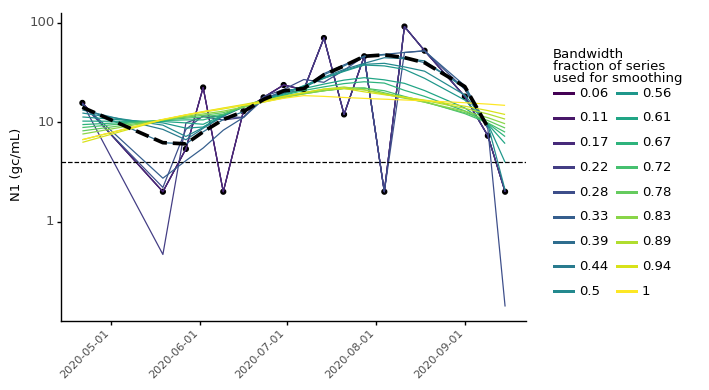

<ggplot: (326890437)>

In [29]:
a=qpcr_long_dict[code].copy()
a=a[~np.isnan(a.value)]
b=loess_N1.copy()

t=["N1_int"]

a=a[a.Target.isin(t)]
a.loc[a.Target== "N1_int", "value"]= a.loc[a.Target== "N1_int", "value"]/1000 #convert to gc/mL
a.loc[a.Target=="N1_int", "Target"]= name_N1

b.loc[b.Target== "N1_int", "y_pred"]= b.loc[b.Target== "N1_int", "y_pred"]/1000 #convert to gc/mL
b.loc[b.Target=="N1_int", "Target"]= name_N1

c=b[b.alpha_rounded==0.39]

a['ymax']=a.value * a.gstd
a['ymin']=a.value / a.gstd
# 

plt = (ggplot() + 

geom_point(a, aes(x='date_sampling', y='value'))+
geom_pointrange(a, aes(x='date_sampling', y='value', ymin='ymin', ymax='ymax')) +
geom_line(b,aes(x='date_sampling', y='y_pred', color='alpha_rounded'))+
geom_line(c,aes(x='date_sampling', y='y_pred'), color='black', linetype='dashed', size=1.5)+
scale_color_cmap_d('viridis')+
geom_hline(yintercept=N1_LoD/1000, linetype='dashed')+
xlab("")+
ylab(name_N1)+
labs(color=name_alpha)+
guides(color=guide_legend(ncol=2))+
scale_y_log10()+ 
theme_classic()+ theme(legend_title=element_text(size=ftl),axis_title=element_text(size=ftl), strip_text=element_text(size=ftl), legend_text=element_text(size=ftl),axis_text_x=element_text(rotation=45, hjust=1, size=fts), axis_text_y=element_text(size=ftl), figure_size=(6,4)) )

#title for the plot
n1='Figure_3B' 
plot1=n1  +'.pdf'
#path for the plot
path=os.path.join(dir, plot1)
#save the plot
plt.save(path)


plt


#### save updated df

In [30]:
N1_crAss_LoD=N1_crAss_LoD_full.loc[N1_crAss_LoD_full.sample_code==code, "crAss_Q3"].copy().item()

a=qpcr_long_dict[code].copy()
a=a[~np.isnan(a.value)]
a=models_int_long.merge(a, how='outer', on=["date_sampling", "Target"])
a=a[(a.date_sampling >= start_dict[code]) & (a.date_sampling <= end_dict[code] + extension_days)]


#conversions
a.loc[a.Target== "N1_int", "value"]= a.loc[a.Target== "N1_int", "value"]/1000 #convert to gc/mL
a.loc[a.Target== "N1_int", "model"]= a.loc[a.Target== "N1_int", "model"]/1000 #convert to gc/mL
a.loc[a.Target== "N1C_int", "value"]= a.loc[a.Target== "N1C_int", "value"]/1000 #convert to gc/mL
a.loc[a.Target== "N1C_int", "model"]= a.loc[a.Target== "N1C_int", "model"]/1000 #convert to gc/mL
# a.loc[a.Target== "N1Cr_int", "value"]= a.loc[a.Target== "N1Cr_int", "value"]/1000 #convert to gc/mL
# a.loc[a.Target== "N1Cr_int", "model"]= a.loc[a.Target== "N1Cr_int", "model"]/1000 #convert to gc/mL
a.loc[a.Target== "new_cases_per_capita", "value"]= a.loc[a.Target== "new_cases_per_capita", "value"]*1000 #convert to per 1000 people
a.loc[a.Target== "new_cases_per_capita", "model"]= a.loc[a.Target== "new_cases_per_capita", "model"]*1000 #convert to per 1000 people



# N1_targs=["N1_int", "N1C_int"]
# a["blod_N1"]=np.nan
# a.loc[(a.Target.isin(N1_targs)), "blod_N1"]="N"
# a.loc[(a.Target.isin(N1_targs)) & (a.value< (N1_LoD/1000)), "blod_N1"]="Y"
a.loc[np.isnan(a.value), "blod_N1"]= "Not applicable"

t=["N1_int","N1Cr_int", "new_cases_per_capita"]
a=a[a.Target.isin(t)]
a.loc[a.Target=="new_cases_per_capita", "value"]=np.nan
a.loc[a.Target=="new_cases_per_capita","N1_und"]="Not applicable"
a.loc[(np.isnan(a.value)),"N1_und"]="Not applicable"
a['Number of amplified technical replicates']= "Not applicable"
a.loc[(a.N1_und != "Not applicable") & (~np.isnan(a.N1_und_total)),'Number of amplified technical replicates']= pd.to_numeric(a.loc[(a.N1_und != "Not applicable") & (~np.isnan(a.N1_und_total)),"N1_und_total"])- pd.to_numeric(a.loc[(a.N1_und != "Not applicable") & (~np.isnan(a.N1_und_total)),"N1_und"])
a['Number of amplified technical replicates']= a['Number of amplified technical replicates'].astype('category')
dates=a.loc[(~np.isnan(a.gstd))&(a.gstd!=1), "date_sampling"]. unique()

a["Target_p"]=a.Target
a.loc[a.Target=="N1C_int", "Target"]= name_N1C_int.format(round(alpha_N1C,2))
a.loc[a.Target=="N1Cr_int", "Target"]= name_N1Cr_int.format(round(alpha_N1Cr,2))
a.loc[a.Target=="N1_int", "Target"]= name_N1_int.format(round(alpha_N1,2))
a.loc[a.Target=="new_cases_per_capita", "Target"]= name_new_cases_norm

cases_LoD=(case_LoD_N/pop_dict[code])*people
a.loc[(a.Target_p=="new_cases_per_capita") & (a.model< cases_LoD), "model"]=((case_LoD_N/pop_dict[code])/2)*people
a.loc[(a.Target_p=="N1_int") & (a.model< N1_LoD/1000), "model"]= 0.5*(N1_LoD/1000)
a.loc[(a.Target_p=="N1C_int") & (a.model< N1_LoD/1000), "model"]= 0.5*(N1_LoD/1000)
# a.loc[(a.Target_p=="N1Cr_int") & (a.model< N1_LoD/1000), "model"]= 0.5*(N1_LoD/1000)
a.loc[(a.Target_p=="N1Cr_int") & (a.model< N1_crAss_LoD), "model"]= 0.5*(N1_crAss_LoD)


a['ymax']=a.value * a.gstd
a['ymin']=a.value / a.gstd

# hlinedf= pd.DataFrame({'Target': [name_N1_int.format(round(alpha_N1,2)), name_new_cases_norm],
#         'h_val': [N1_LoD/1000,((case_LoD_N/pop_dict[code]))*1000], 'color':['black','black']
#         }, columns = ['Target', 'h_val', 'color'])

hlinedf= pd.DataFrame({'Target': [name_N1_int.format(round(alpha_N1,2)), name_N1Cr_int.format(round(alpha_N1Cr,2)),name_new_cases_norm],
        'h_val': [N1_LoD/1000,N1_crAss_LoD,((case_LoD_N/pop_dict[code]))*1000], 'color':['black','black','black']
        }, columns = ['Target', 'h_val', 'color'])

# plt = (ggplot() + 
# geom_point(a, aes(x='date_sampling', y='value', shape='Number of amplified technical replicates'), color='black')+
# geom_line(a, aes(x='date_sampling', y='model', color='Target'), size=lw)+
# geom_hline(hlinedf,aes(yintercept='h_val'), linetype='dashed', color=hlinedf.color)+
# guides(color=False)+
# # labs(shape=legend_N1_und)+
# ylab('')+
# xlab("")+
# scale_color_cmap_d('viridis')+
# scale_y_log10()+
# facet_wrap('~Target', ncol=1, scales="free_y")+ #, 
# theme_classic()+ theme(legend_position='right', strip_text_x = element_text(margin={'t': 15}), axis_text_x=element_text(rotation=45, hjust=1), figure_size=(6, 7)) )


n49=a.copy()
n49["lod"]=np.nan
n49.loc[n49.Target_p=="N1_int", "lod"]= N1_LoD/1000
n49.loc[n49.Target_p=="N1Cr_int", "lod"]= N1_crAss_LoD
n49.loc[n49.Target_p=="new_cases_per_capita", "lod"]= (case_LoD_N/pop_dict[code])*1000
n49.loc[n49.Target_p=="active_cases_per_capita", "lod"]= (case_LoD_N/pop_dict[code])*1000
n49["location"]="N"




### Location A

#### Figure S5

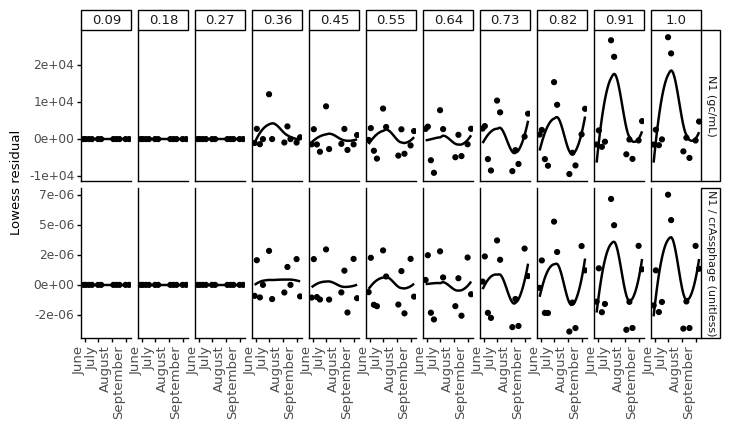

<ggplot: (-9223372036528486817)>

In [31]:
code="C_C_ADA"
a=qpcr_loess_dict[code]


a.points=pd.to_numeric(a.points)
a['alpha_v']=a.points/(pA)
a['alpha_rounded']=a.alpha_v.apply(lambda x: round(x,2) ).astype(object)
lis=["N1", "N1_crAss_reg"]
a=a[a.Target.isin(lis)].copy()

a.loc[a.Target=="N1_crAss", "Target"]= name_N1C
a.loc[a.Target=="N1_crAss_reg", "Target"]= name_N1Cr
a.loc[a.Target=="N1", "Target"]= name_N1

plt = (ggplot(a, aes(x='date_sampling', y='residuals')) + 
    geom_point()+
    geom_smooth(method='loess', span= 1, se=False)+
    facet_grid('Target~alpha_rounded ', scales='free_y')+
    xlab("")+
    scale_x_datetime(date_breaks='1 month',date_labels="%B")+
     scale_y_continuous(labels=scientific_format(digits=0))+
    ylab("Lowess residual")+
    theme_classic()+ theme( strip_text_x = element_text(size=ftl),  strip_text_y = element_text(size=fts), axis_text_x=element_text(rotation=90, hjust=1, size=ftl), figure_size=(8, 4),  axis_title=element_text(size=ftl))) #axis_text_x=element_text(rotation=45, hjust=1), figure_size=(18, 6)) )
    
#choosing points
pts_N1=5
pts_N1C=4
pts_N1Cr=4
alpha_N1=pd.to_numeric(a.loc[a.points==pts_N1, "alpha_v"].unique().item())
alpha_N1C=pd.to_numeric(a.loc[a.points==pts_N1C, "alpha_v"].unique().item())
alpha_N1Cr=pd.to_numeric(a.loc[a.points==pts_N1Cr, "alpha_v"].unique().item())




#title for the plot
n1='Figure_S5A' 
plot1=n1  +'.pdf'
#path for the plot
path=os.path.join(dir, plot1)
#save the plot
plt.save(path)


plt



In [32]:

loess=qpcr_loess_dict[code].copy()

loess_N1=loess[loess.Target=="N1"].copy()
loess_N1["Target"]="N1_int"
loess_N1_int= loess_N1.loc[loess_N1.alpha_v==alpha_N1,].copy().set_index("date_sampling").drop(["points", "alpha_v", "residuals", "Target", "alpha_rounded"], axis=1)
loess_N1_int=loess_N1_int.resample('D').max() #max just places nans because adding dates not subtracting
loess_N1_int["y_pred_int"]=loess_N1_int["y_pred"].interpolate(method='linear')


loess_N1C=loess[loess.Target=="N1_crAss"].copy()
loess_N1C["Target"]="N1C_int"
loess_N1C_int= loess_N1C.loc[loess_N1C.alpha_v==alpha_N1C,].copy().set_index("date_sampling").drop(["points", "alpha_v", "residuals", "Target", "alpha_rounded"], axis=1)
loess_N1C_int=loess_N1C_int.resample('D').max() #max just places nans because adding dates not subtracting
loess_N1C_int["y_pred_int"]=loess_N1C_int["y_pred"].interpolate(method='linear')

loess_N1Cr=loess[loess.Target=="N1_crAss_reg"].copy()
loess_N1Cr["Target"]="N1Cr_int"
loess_N1Cr_int= loess_N1Cr.loc[loess_N1Cr.alpha_v==alpha_N1Cr,].copy().set_index("date_sampling").drop(["points", "alpha_v", "residuals", "Target", "alpha_rounded"], axis=1)
loess_N1Cr_int=loess_N1Cr_int.resample('D').max() #max just places nans because adding dates not subtracting
loess_N1Cr_int["y_pred_int"]=loess_N1Cr_int["y_pred"].interpolate(method='linear')

loess_N1=loess_N1.reset_index(drop=True)
loess_N1C=loess_N1C.reset_index(drop=True)
loess_N1Cr=loess_N1Cr.reset_index(drop=True)
pt=loess_N1.alpha_v.unique()


#merge lowess and case data models to create a dataframe of models
case_model_lookup=qpcr_int[qpcr_int.sample_code==code][["date_sampling","moving_average_new_cases", "moving_average_active_cases","population", "average_flow_MGD"]].copy()
case_model_lookup["mvga_7D_new_cases"]= case_model_lookup["moving_average_new_cases"]
case_model_lookup["mvga_7D_active_cases"]= case_model_lookup["moving_average_active_cases"]
case_model_lookup["mvga_7D_new_cases_norm"]= case_model_lookup["mvga_7D_new_cases"] / case_model_lookup["population"]
case_model_lookup["mvga_7D_active_cases_norm"]= case_model_lookup["mvga_7D_active_cases"] / case_model_lookup["population"]
case_model_lookup=case_model_lookup.copy().drop(["moving_average_new_cases", "moving_average_active_cases"], axis=1)

models_merge= loess_N1C_int.copy().reset_index().drop(["y_pred" ],axis=1)
models_merge.columns=["date_sampling", "N1C_int"]

models_merge2= loess_N1Cr_int.copy().reset_index().drop(["y_pred" ],axis=1)
models_merge2.columns=["date_sampling", "N1Cr_int"]

models_int=loess_N1_int.reset_index().merge(case_model_lookup, how='outer', on='date_sampling')
models_int=models_int.drop("y_pred", axis=1)
models_int.columns=["date_sampling","N1_int", "population", "average_flow_MGD", "new_cases", "active_cases", "new_cases_per_capita", "active_cases_per_capita"]
models_int=models_int.merge(models_merge, how='left', on='date_sampling')
models_int=models_int.merge(models_merge2, how='left', on='date_sampling')

# models_int_long=models_int.copy().melt(id_vars="date_sampling", value_vars=["N1_int", "new_cases", "active_cases","N1C_int"], var_name="Target", value_name="model")
models_int_long=models_int.copy().melt(id_vars="date_sampling", value_vars=["N1_int", "new_cases_per_capita", "active_cases_per_capita","N1C_int", "N1Cr_int"], var_name="Target", value_name="model")


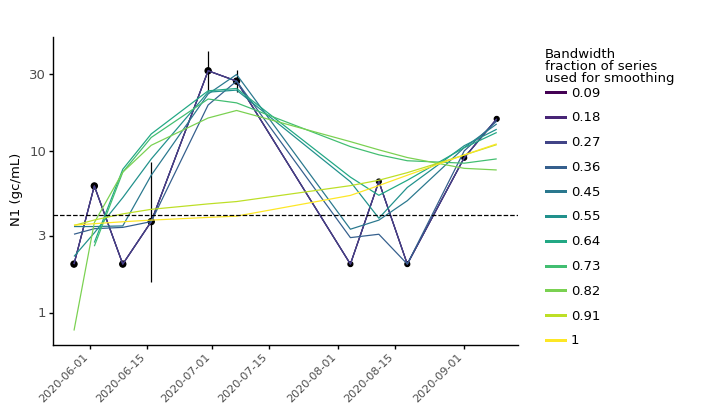

<ggplot: (-9223372036529152999)>

In [33]:
a=qpcr_long_dict[code].copy()
a=a[~np.isnan(a.value)]
b=loess_N1.copy()

t=["N1_int"]

a=a[a.Target.isin(t)]
a.loc[a.Target== "N1_int", "value"]= a.loc[a.Target== "N1_int", "value"]/1000 #convert to gc/mL
a.loc[a.Target=="N1_int", "Target"]= name_N1

b.loc[b.Target== "N1_int", "y_pred"]= b.loc[b.Target== "N1_int", "y_pred"]/1000 #convert to gc/mL
b.loc[b.Target=="N1_int", "Target"]= name_N1

a['ymax']=a.value * a.gstd
a['ymin']=a.value / a.gstd
# 

plt = (ggplot() + 
geom_point(a, aes(x='date_sampling', y='value'))+
geom_pointrange(a, aes(x='date_sampling', y='value', ymin='ymin', ymax='ymax')) +
geom_line(b,aes(x='date_sampling', y='y_pred', color='alpha_rounded'))+
scale_color_cmap_d('viridis')+
geom_hline(yintercept=N1_LoD/1000, linetype='dashed')+
xlab("")+
ylab(name_N1)+
labs(color=name_alpha)+
scale_y_log10()+ 
theme_classic()+ theme(legend_title=element_text(size=ftl),axis_title=element_text(size=ftl), strip_text=element_text(size=ftl), legend_text=element_text(size=ftl),axis_text_x=element_text(rotation=45, hjust=1, size=fts), axis_text_y=element_text(size=ftl), figure_size=(6,4)) )

#title for the plot
n1='Figure_S5B' 
plot1=n1  +'.pdf'
#path for the plot
path=os.path.join(dir, plot1)
#save the plot
plt.save(path)


plt

#### save updated df

In [34]:
N1_crAss_LoD=N1_crAss_LoD_full.loc[N1_crAss_LoD_full.sample_code==code, "crAss_Q3"].copy().item()

a=qpcr_long_dict[code].copy()
a=a[~np.isnan(a.value)]
a=models_int_long.merge(a, how='outer', on=["date_sampling", "Target"])
a=a[(a.date_sampling >= start_dict[code]) & (a.date_sampling <= end_dict[code] + extension_days)]


#conversions
a.loc[a.Target== "N1_int", "value"]= a.loc[a.Target== "N1_int", "value"]/1000 #convert to gc/mL
a.loc[a.Target== "N1_int", "model"]= a.loc[a.Target== "N1_int", "model"]/1000 #convert to gc/mL
a.loc[a.Target== "N1C_int", "value"]= a.loc[a.Target== "N1C_int", "value"]/1000 #convert to gc/mL
a.loc[a.Target== "N1C_int", "model"]= a.loc[a.Target== "N1C_int", "model"]/1000 #convert to gc/mL
# a.loc[a.Target== "N1Cr_int", "value"]= a.loc[a.Target== "N1Cr_int", "value"]/1000 #convert to gc/mL
# a.loc[a.Target== "N1Cr_int", "model"]= a.loc[a.Target== "N1Cr_int", "model"]/1000 #convert to gc/mL
a.loc[a.Target== "new_cases_per_capita", "value"]= a.loc[a.Target== "new_cases_per_capita", "value"]*1000 #convert to per 1000 people
a.loc[a.Target== "new_cases_per_capita", "model"]= a.loc[a.Target== "new_cases_per_capita", "model"]*1000 #convert to per 1000 people


# N1_targs=["N1_int", "N1C_int"]
# a["blod_N1"]=np.nan
# a.loc[(a.Target.isin(N1_targs)), "blod_N1"]="N"
# a.loc[(a.Target.isin(N1_targs)) & (a.value< (N1_LoD/1000)), "blod_N1"]="Y"
a.loc[np.isnan(a.value), "blod_N1"]= "Not applicable"

t=["N1_int","N1Cr_int","new_cases_per_capita"]
a=a[a.Target.isin(t)]
a.loc[a.Target=="new_cases_per_capita", "value"]=np.nan
a.loc[a.Target=="new_cases_per_capita","N1_und"]="Not applicable"
a.loc[(np.isnan(a.value)),"N1_und"]="Not applicable"
a['Number of amplified technical replicates']= "Not applicable"
a.loc[(a.N1_und != "Not applicable") & (~np.isnan(a.N1_und_total)),'Number of amplified technical replicates']= pd.to_numeric(a.loc[(a.N1_und != "Not applicable") & (~np.isnan(a.N1_und_total)),"N1_und_total"])- pd.to_numeric(a.loc[(a.N1_und != "Not applicable") & (~np.isnan(a.N1_und_total)),"N1_und"])
a['Number of amplified technical replicates']= a['Number of amplified technical replicates'].astype('category')
dates=a.loc[(~np.isnan(a.gstd))&(a.gstd!=1), "date_sampling"]. unique()

a["Target_p"]=a.Target
a.loc[a.Target=="N1C_int", "Target"]= name_N1C_int.format(round(alpha_N1C,2))
a.loc[a.Target=="N1Cr_int", "Target"]= name_N1Cr_int.format(round(alpha_N1Cr,2))
a.loc[a.Target=="N1_int", "Target"]= name_N1_int.format(round(alpha_N1,2))
a.loc[a.Target=="new_cases_per_capita", "Target"]= name_new_cases_norm

cases_LoD=(case_LoD/pop_dict[code])*people
a.loc[(a.Target_p=="new_cases_per_capita") & (a.model< cases_LoD), "model"]=((case_LoD/pop_dict[code])/2)*people
a.loc[(a.Target_p=="N1_int") & (a.model< N1_LoD/1000), "model"]= 0.5*(N1_LoD/1000)
a.loc[(a.Target_p=="N1C_int") & (a.model< N1_LoD/1000), "model"]= 0.5*(N1_LoD/1000)
# a.loc[(a.Target_p=="N1Cr_int") & (a.model< N1_LoD/1000), "model"]= 0.5*(N1_LoD/1000)
a.loc[(a.Target_p=="N1Cr_int") & (a.model< N1_crAss_LoD), "model"]= 0.5*(N1_crAss_LoD)


a['ymax']=a.value * a.gstd
a['ymin']=a.value / a.gstd

hlinedf= pd.DataFrame({'Target': [name_N1_int.format(round(alpha_N1,2)), name_N1Cr_int.format(round(alpha_N1Cr,2)),name_new_cases_norm],
        'h_val': [N1_LoD/1000,N1_crAss_LoD,((case_LoD/pop_dict[code]))*1000], 'color':['black','black','black']
        }, columns = ['Target', 'h_val', 'color'])

# plt = (ggplot() + 
# geom_point(a, aes(x='date_sampling', y='value', shape='Number of amplified technical replicates'), color='black')+
# geom_line(a, aes(x='date_sampling', y='model', color='Target'), size=lw)+
# geom_hline(hlinedf,aes(yintercept='h_val'), linetype='dashed', color=hlinedf.color)+
# guides(color=False)+
# # labs(shape=legend_N1_und)+
# ylab('')+
# xlab("")+
# scale_color_cmap_d('viridis')+
# scale_y_log10()+
# facet_wrap('~Target', ncol=1, scales="free_y")+ #, 
# theme_classic()+ theme(legend_position='right', strip_text_x = element_text(margin={'t': 15}), axis_text_x=element_text(rotation=45, hjust=1), figure_size=(6, 10)) )


ada=a.copy()
ada["lod"]=np.nan
ada.loc[ada.Target_p=="N1_int", "lod"]= N1_LoD/1000
ada.loc[ada.Target_p=="N1Cr_int", "lod"]= N1_crAss_LoD
ada.loc[ada.Target_p=="new_cases_per_capita", "lod"]= (case_LoD/pop_dict[code])*1000
ada.loc[ada.Target_p=="active_cases_per_capita", "lod"]= (case_LoD/pop_dict[code])*1000
ada["location"]="A"


### All locations

#### Figure 4

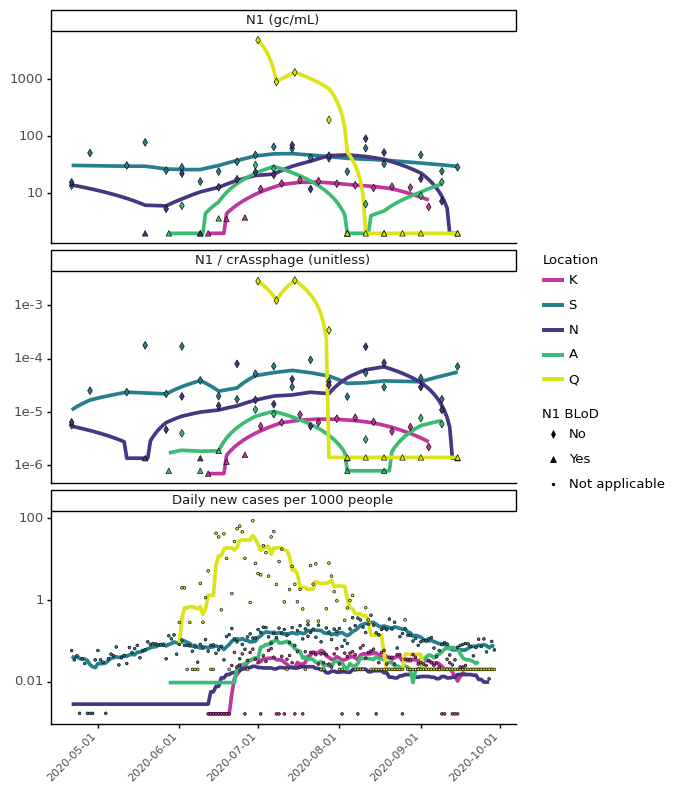

<ggplot: (-9223372036527045744)>

In [35]:
all=ada.append(s68)
all=all.append(n49)
all=all.append(sq)
all=all.append(kinf)
all.population=all.population.fillna(method='pad')
all.average_flow_MGD=all.average_flow_MGD.fillna(method='pad')
# all=all[~np.isnan(all.value)]

a=all.copy()
b=a[a.Target_p=="N1_int"].copy()
b.Target_p= "flow"
b.loc[b.Target_p=="flow", "value"]= b.loc[b.Target_p=="flow", "value"]*1000*3785411.78*(b.average_flow_MGD/b.population) #only do this for raw N1
b.loc[b.Target_p=="flow", "model"]= b.loc[b.Target_p=="flow", "model"]*1000*3785411.78*(b.average_flow_MGD/b.population)#only do this for raw N1
a=a.append(b)
a.model=pd.to_numeric(a.model)
a.value=pd.to_numeric(a.value)
all=a.copy() #add in flow


a["Normalization_strategy"]=np.nan
a.loc[a.Target_p== "N1_int", "Normalization_strategy"]= "N1 (gc/mL)" #gc/mL
a.loc[a.Target_p== "N1Cr_int", "Normalization_strategy"]= "N1 / crAssphage (unitless)" #unitless
a.loc[a.Target_p== "flow", "Normalization_strategy"]= "Mean per capita flow-normalized wastewater data (gc/person/day)" #(gc/person/day)
a.loc[a.Target_p== "new_cases_per_capita", "Normalization_strategy"]= "Daily new cases per 1000 people" #(gc/person/day)

a.Normalization_strategy=a.Normalization_strategy.astype('category')
a.Normalization_strategy=a.Normalization_strategy.cat.reorder_categories(["N1 (gc/mL)", "Mean per capita flow-normalized wastewater data (gc/person/day)" , "N1 / crAssphage (unitless)","Daily new cases per 1000 people"])
# t=["N1_int", "N1Cr_int", "flow","new_cases_per_capita"]
t=["N1_int", "N1Cr_int", "new_cases_per_capita"]
a=a[a.Target_p.isin(t)]
a.location=a.location.astype('category')
a.location=a.location.cat.reorder_categories(["K", "S",  "N", "A", "Q"])

a.loc[a.blod_N1=="Not applicable", "blod_N1"]="No"
a.loc[a.blod_N1=="N", "blod_N1"]="No"
a.loc[a.blod_N1=="Y", "blod_N1"]="Yes"
a.loc[a.Target_p=="new_cases_per_capita", "blod_N1"]="Not applicable"
a.blod_N1=a.blod_N1.astype('category')
a.blod_N1=a.blod_N1.cat.reorder_categories(["No", "Yes", "Not applicable"])

a.loc[a.Target_p=="new_cases_per_capita","value"].unique()
plt = (ggplot() + 
geom_line(a, aes(x='date_sampling', y='model', color='location'), size=1.5)+
geom_point(a, aes(x='date_sampling', y='value', fill='location',shape='blod_N1'),size=2,color='black',stroke=0.25)+
facet_wrap('~Normalization_strategy', scales='free_y', ncol=1)+
ylab('')+
xlab("")+
scale_y_log10()+
labs(shape="N1 BLoD", color="Location")+
guides(fill=None)+
scale_color_manual([k_c,s68_c, ada_c, n49_c, sq_c])+
scale_fill_manual([k_c,s68_c, ada_c, n49_c, sq_c])+
scale_shape_manual(["d","^",'.'])+
theme_classic()+ theme(legend_title=element_text(size=ftl),axis_title=element_text(size=ftl), strip_text=element_text(size=ftl), legend_text=element_text(size=ftl),axis_text_x=element_text(rotation=45, hjust=1, size=fts), axis_text_y=element_text(size=ftl), figure_size=(6,9)) )

#title for the plot
n1='Figure_4' 
plot1=n1  +'.pdf'
#path for the plot
path=os.path.join(dir, plot1)
#save the plot
plt.save(path)


plt




#### Figure S6

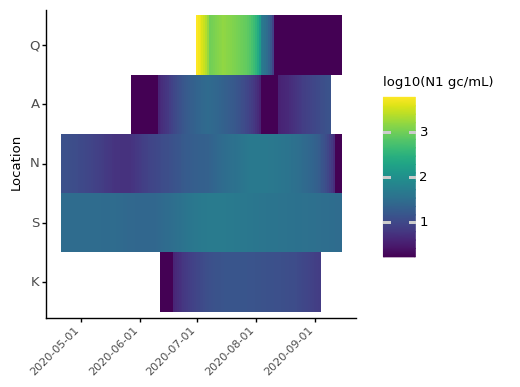

<ggplot: (-9223372036527033270)>

In [36]:

heat=a[a.Target_p=="N1_int"].copy()
heat['logmodel']=np.log10(heat.model)
heat=heat[~np.isnan(heat.logmodel)]
plt = (ggplot(heat,aes(x='date_sampling',y='location',fill='logmodel'))+
     geom_tile(na_rm=False)+
     scale_fill_cmap('viridis')+ theme_classic()+ 
     ylab("Location")+
     xlab("")+ 
     labs(fill="log10(N1 gc/mL)\n")+
    #  theme(axis_text_x=element_text(rotation=45, hjust=1),
    #        legend_position = 'right',
    #        plot_title = element_text(size=8),
    #        axis_text_y = element_text(size=f), figure_size=(4,4)))
theme(legend_title=element_text(size=ftl),axis_title=element_text(size=ftl), strip_text=element_text(size=ftl), legend_text=element_text(size=ftl),axis_text_x=element_text(rotation=45, hjust=1, size=fts), axis_text_y=element_text(size=ftl), figure_size=(4,4)) )

#title for the plot
n1='Figure_S6A' 
plot1=n1  +'.pdf'
#path for the plot
path=os.path.join(dir, plot1)
#save the plot
plt.save(path)


plt



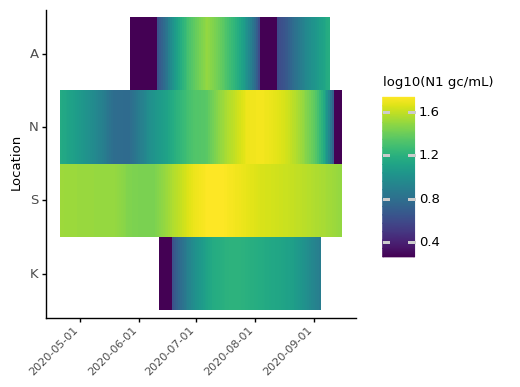

<ggplot: (326029916)>

In [37]:
heat=a[a.Target_p=="N1_int"].copy()
heat=heat[heat.location !="Q"]
heat['logmodel']=np.log10(heat.model)
heat=heat[~np.isnan(heat.logmodel)]


plt = (ggplot(heat,aes(x='date_sampling',y='location',fill='logmodel'))+
     geom_tile()+
     ylab("Location")+
     xlab("")+ 
     labs(fill="log10(N1 gc/mL)\n")+
     scale_fill_cmap('viridis')+ theme_classic()+ 
theme(legend_title=element_text(size=ftl),axis_title=element_text(size=ftl), strip_text=element_text(size=ftl), legend_text=element_text(size=ftl),axis_text_x=element_text(rotation=45, hjust=1, size=fts), axis_text_y=element_text(size=ftl), figure_size=(4,4)) )

#title for the plot
n1='Figure_S6B' 
plot1=n1  +'.pdf'
#path for the plot
path=os.path.join(dir, plot1)
#save the plot
plt.save(path)


plt
  

#### Figure S7

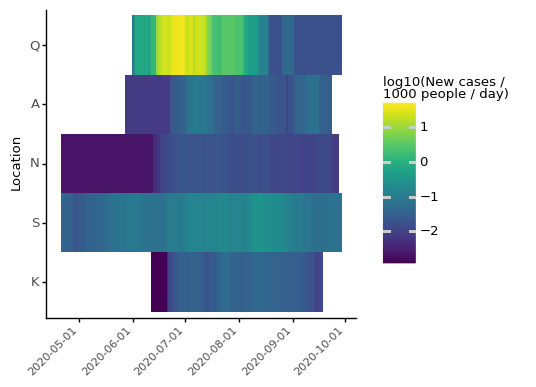

<ggplot: (-9223372036528634943)>

In [38]:
heat=a[a.Target_p=="new_cases_per_capita"].copy()
heat['logmodel']=np.log10(heat.model)
heat=heat[~np.isnan(heat.logmodel)]
plt = (ggplot(heat,aes(x='date_sampling',y='location',fill='logmodel'))+
     geom_tile(na_rm=False)+
     scale_fill_cmap('viridis')+ theme_classic()+ 
     ylab("Location")+
     xlab("")+ 
     labs(fill="log10(New cases /\n1000 people / day)\n")+
theme(legend_title=element_text(size=ftl),axis_title=element_text(size=ftl), strip_text=element_text(size=ftl), legend_text=element_text(size=ftl),axis_text_x=element_text(rotation=45, hjust=1, size=fts), axis_text_y=element_text(size=ftl), figure_size=(4,4)) )

#title for the plot
n1='Figure_S7A' 
plot1=n1  +'.pdf'
#path for the plot
path=os.path.join(dir, plot1)
#save the plot
plt.save(path)


plt

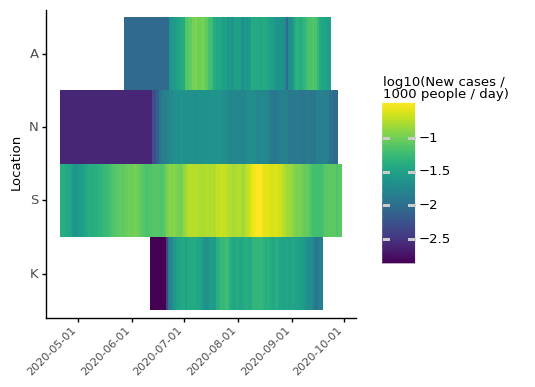

<ggplot: (326727316)>

In [39]:
heat=a[a.Target_p=="new_cases_per_capita"].copy()
heat=heat[heat.location !="Q"]
heat['logmodel']=np.log10(heat.model)
heat=heat[~np.isnan(heat.logmodel)]


plt= (ggplot(heat,aes(x='date_sampling',y='location',fill='logmodel'))+
     geom_tile()+
     ylab("Location")+
     xlab("")+ 
     labs(fill="log10(New cases /\n1000 people / day)\n")+
     scale_fill_cmap('viridis')+ theme_classic()+ 
theme(legend_title=element_text(size=ftl),axis_title=element_text(size=ftl), strip_text=element_text(size=ftl), legend_text=element_text(size=ftl),axis_text_x=element_text(rotation=45, hjust=1, size=fts), axis_text_y=element_text(size=ftl), figure_size=(4,4)) )

#title for the plot
n1='Figure_S7B' 
plot1=n1  +'.pdf'
#path for the plot
path=os.path.join(dir, plot1)
#save the plot
plt.save(path)


plt

#### Figure S15

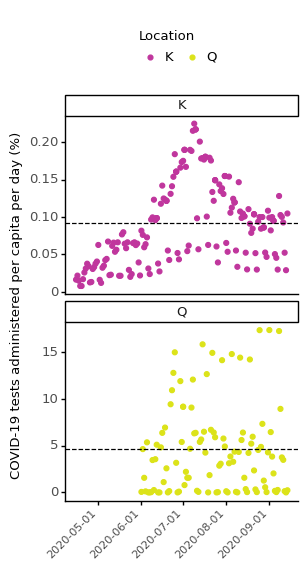

<ggplot: (326098408)>

In [40]:

a=qpcr_averaged_merged_wide[~np.isnan(qpcr_averaged_merged_wide.total_tests)].copy()
a["total_tests_per_capita"]=a["total_tests"]/pd.to_numeric(a["population"])
a["location"]= np.nan
a.loc[a.sample_code=="K_K_INF","location"]="K"
a.loc[a.sample_code=="B_B_SQ","location"]="Q"
a=a[a.date_sampling  < end_dict["C_C_S68"]].copy() #fullest range
a['percent_tested']=(pd.to_numeric(a['total_tests_per_capita']))*100
hlinedf=a.groupby(['location'])['percent_tested'].agg('mean').reset_index()


plt = (ggplot() + 
geom_point(a, aes(x='date_sampling', y='percent_tested', color='location'))+
xlab("")+
ylab("COVID-19 tests administered per capita per day (%)")+
# scale_y_log10()+
labs(color="Location")+
geom_hline(hlinedf,aes(yintercept='percent_tested'), linetype='dashed', color='black')+
facet_wrap('~location',scales='free_y', ncol=1)+
scale_color_manual([k_c, sq_c])+
theme_classic()+ theme(legend_position='top',legend_title=element_text(size=ftl),axis_title=element_text(size=ftl), strip_text=element_text(size=ftl), legend_text=element_text(size=ftl),axis_text_x=element_text(rotation=45, hjust=1, size=fts), axis_text_y=element_text(size=ftl), figure_size=(3,5)) )


#title for the plot
n1='Figure_S15' 
plot1=n1  +'.pdf'
#path for the plot
path=os.path.join(dir, plot1)
#save the plot
plt.save(path)


plt

#### create wide  df

In [41]:
all_wide_model=all.copy()

all_wide_model=all_wide_model.pivot(index=['date_sampling', 'location' ], columns='Target_p', values='model').reset_index()
all_wide_model.columns=[ "date_sampling", "location",  "Loess_N1_crAss_reg" ,"Loess_N1_gc_mL","seven-day moving average of active cases per 1000 people","Lowess_N1_gc_per_capita","seven-day moving average of new cases per 1000 people"]


all_wide_value=all.pivot(index=['date_sampling', 'location' ], columns='Target_p', values='value').reset_index()
all_wide_value=all_wide_value[~np.isnan(all_wide_value.N1_int)]

all_wide=all_wide_value.merge(all_wide_model, on=["date_sampling","location"], how ='right')

all_wide['moving average of new cases per capita'] = all_wide['seven-day moving average of new cases per 1000 people'] /1000
# # all_wide=all_wide[all_wide.N1_int < N1_LoD/1000]


#### Figure S10

In [42]:
k=all_wide.copy()

m=["K","S","N"] # have <25% BDL and >14 quantifiable remaining pts
k=k[k.location.isin(m)].copy()

n_new_sm= "smooth new cases per 1000 people" 
n_ww="N1 (gc/mL)"
nCr_ww= "N1 / crAssphage (unitless)"
n_flow="N1 (gc/person/day)"

k=k.drop(['moving average of new cases per capita' ,  'Loess_N1_gc_mL',  'Loess_N1_crAss_reg',"Lowess_N1_gc_per_capita", "new_cases_per_capita", "active_cases_per_capita","seven-day moving average of active cases per 1000 people"],axis=1)
k.columns=["date_sampling", "location",  nCr_ww,  n_ww , n_flow, n_new_sm]
k=k.dropna()

k["1lag_"+n_ww]=np.nan
k["1lag_"+nCr_ww]=np.nan
k["1lag_"+n_flow]=np.nan
k["2lag_"+n_ww]=np.nan
k["2lag_"+nCr_ww]=np.nan
k["2lag_"+n_flow]=np.nan
k=k.sort_values([ "location","date_sampling"])

k[["1lag_"+n_ww, "1lag_"+nCr_ww, "1lag_"+n_flow]]=k.groupby(['location'])[n_ww, nCr_ww,n_flow].shift(1)
k[["2lag_"+n_ww, "2lag_"+nCr_ww, "2lag_"+n_flow]]=k.groupby(['location'])[n_ww, nCr_ww,n_flow].shift(2)

lis_t=["date_sampling","location", n_new_sm, n_ww, n_flow, nCr_ww]
lis_t2=[n_ww, n_flow, nCr_ww]

condition_reg="no lead"
wBDL=k.copy()
wBDL_reg=wBDL[lis_t].copy()
woBDL=k[k[n_ww]> N1_LoD/1000].copy()
woBDL_reg=woBDL[lis_t].copy()

condition_1="one-week lead"
wBDL_1=wBDL.copy()
wBDL_1=wBDL_1[["date_sampling","location", n_new_sm, "1lag_"+n_ww, "1lag_"+n_flow, "1lag_"+nCr_ww]].copy()
wBDL_1.columns=lis_t
woBDL_1=woBDL.copy()
woBDL_1=woBDL_1[["date_sampling","location", n_new_sm, "1lag_"+n_ww, "1lag_"+n_flow, "1lag_"+nCr_ww]].copy()
woBDL_1.columns=lis_t

condition_2="two-week lead"
wBDL_2=wBDL.copy()
wBDL_2=wBDL_2[["date_sampling","location", n_new_sm, "2lag_"+n_ww, "2lag_"+n_flow, "2lag_"+nCr_ww]].copy()
wBDL_2.columns=lis_t
woBDL_2=woBDL.copy()
woBDL_2=woBDL_2[["date_sampling","location", n_new_sm, "2lag_"+n_ww, "2lag_"+n_flow, "2lag_"+nCr_ww]].copy()
woBDL_2.columns=lis_t

reg_df=dataframes_kendall(wBDL_reg, woBDL_reg, condition_reg, lis_t2)
lag1_df=dataframes_kendall(wBDL_1, woBDL_1, condition_1,lis_t2)
lag2_df=dataframes_kendall(wBDL_2, woBDL_2, condition_2,lis_t2)

full_df=reg_df.append(lag1_df).reset_index(drop=True)
full_df=full_df.append(lag2_df).reset_index(drop=True)

full_df['pval_s']=np.nan
full_df.loc[full_df.pval >0.05,"pval_s"]=''
full_df.loc[full_df.pval <=0.05,"pval_s"]='.'
full_df.loc[full_df.pval <=0.01,"pval_s"]='*'
full_df.loc[full_df.pval <=0.001,"pval_s"]='**'
full_df.loc[full_df.pval <=0.0001,"pval_s"]='***'

full_df['taup']=full_df.kval.round(decimals=2).astype(str)+full_df.pval_s.astype(str)
full_df.loc[full_df.pval_s=="",'taup']=""
full_df.head()

,location,Target,kval,pval,BDL,condition,pval_s,taup
0,K,N1 (gc/mL),5.03E-01,1.71E-02,BLoD,K no lead,.,0.5.
1,K,N1 (gc/person/day),5.03E-01,1.71E-02,BLoD,K no lead,.,0.5.
2,K,N1 / crAssphage (unitless),4.26E-01,4.37E-02,BLoD,K no lead,.,0.43.
3,N,N1 (gc/mL),3.47E-01,5.34E-02,BLoD,N no lead,,
4,N,N1 (gc/person/day),3.47E-01,5.34E-02,BLoD,N no lead,,


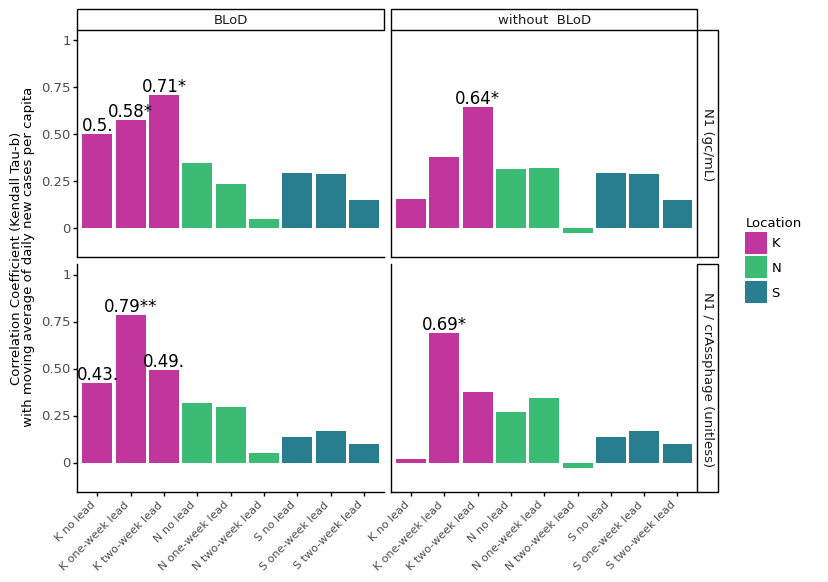

<ggplot: (-9223372036527346474)>

In [43]:
a=full_df
a=a[a.Target!=n_flow].copy()
plt = (ggplot(a, aes(x='condition', y='kval', fill='location')) + 
geom_col(stat='identity')+
geom_text(aes(label='taup'),
            #  position=position_dodge(width=0.9),
             size=12, va='bottom')+
ylab('Correlation Coefficient (Kendall Tau-b)\n with moving average of daily new cases per capita')+
xlab("")+
labs(fill='Location')+
scale_fill_manual([k_c, n49_c, s68_c])+
scale_y_continuous(limits=[-0.1,1])+
facet_grid('Target~BDL')+ #, 
theme_classic()+ theme(legend_title=element_text(size=ftl),axis_title=element_text(size=ftl), strip_text=element_text(size=ftl), legend_text=element_text(size=ftl),axis_text_x=element_text(rotation=45, hjust=1, size=fts), axis_text_y=element_text(size=ftl), figure_size=(8,6)) )


#title for the plot
n1='Figure_S10' 
plot1=n1  +'.pdf'
#path for the plot
path=os.path.join(dir, plot1)
#save the plot
plt.save(path)


plt

#### Figures S13

In [44]:
all_wide_model=all.copy()

all_wide_model=all_wide_model.pivot(index=['date_sampling', 'location' ], columns='Target_p', values='model').reset_index()
all_wide_model=all_wide_model.drop(["N1Cr_int"], axis=1)
all_wide_model.columns=[ "date_sampling", "location",  "Loess_N1_gc_mL","seven-day moving average of active cases per 1000 people","Lowess_N1_gc_per_capita","seven-day moving average of new cases per 1000 people"]


all_wide_value=all.pivot(index=['date_sampling', 'location', "N1_und", "N1_bloq", "N1_und_total", "N1_bloq_total", "N1_bloq_bio", "N1_bloq_bio_total"  ], columns='Target_p', values='value').reset_index()
all_wide_value=all_wide_value[~np.isnan(all_wide_value.N1_int)]

all_wide_case=all_wide_value.merge(all_wide_model, on=["date_sampling","location"], how ='right')

all_wide_case['moving average of new cases per capita'] = all_wide_case['seven-day moving average of new cases per 1000 people'] /1000
all_wide_case.head()

,date_sampling,location,N1_und,N1_bloq,N1_und_total,N1_bloq_total,N1_bloq_bio,N1_bloq_bio_total,N1Cr_int,N1_int,active_cases_per_capita,flow,new_cases_per_capita,Loess_N1_gc_mL,seven-day moving average of active cases per 1000 people,Lowess_N1_gc_per_capita,seven-day moving average of new cases per 1000 people,moving average of new cases per capita
0,2020-04-21,N,0.00E+00,0.00E+00,3.00E+00,3.00E+00,0.00E+00,1.00E+00,6.37E-06,1.56E+01,NAN,4.26E+06,NAN,1.41E+01,NAN,3.85E+06,2.83E-03,2.83E-06
1,2020-04-21,S,0.00E+00,0.00E+00,3.00E+00,3.00E+00,0.00E+00,1.00E+00,5.61E-06,1.37E+01,NAN,3.88E+06,NAN,3.11E+01,NAN,8.78E+06,4.14E-02,4.14E-05
2,2020-04-22,N,NaN,NAN,NAN,NAN,NAN,NAN,NAN,NAN,NAN,NAN,NAN,1.38E+01,NAN,3.77E+06,2.83E-03,2.83E-06
3,2020-04-22,S,NaN,NAN,NAN,NAN,NAN,NAN,NAN,NAN,NAN,NAN,NAN,3.10E+01,NAN,8.76E+06,3.84E-02,3.84E-05
4,2020-04-23,N,NaN,NAN,NAN,NAN,NAN,NAN,NAN,NAN,NAN,NAN,NAN,1.36E+01,NAN,3.69E+06,2.83E-03,2.83E-06


In [45]:
a=all_wide_case.copy()
a=a[~np.isnan(a.N1_int)]

a.location=a.location.astype('category')
a.location=a.location.cat.reorder_categories(["K", "S",  "N", "A", "Q"])
# a=a[a.location !="Q"]
a.loc[a.N1_und =="Not applicable", "N1_und"]= np.nan
a["num_amp"] =pd.to_numeric( a['N1_und'])/a['N1_und_total']#percentage unamplified!!
a.loc[(a.num_amp > 0) & (a.num_amp <1), "num_amp"]= "Some"
a.loc[a.num_amp == 0, "num_amp"]= "All"
a.loc[a.num_amp == 1, "num_amp"]= "None"
# a.loc[a.Target_p=="new_cases_per_capita","num_amp"]="Not applicable"
# a.loc[a.Target_p=="active_cases_per_capita","num_amp"]="Not applicable"
# a.loc[(np.isnan(a.value)),"num_amp"]="Not applicable"
# a.loc[(np.isnan(a.model)),"num_amp"]="Not applicable"
a.num_amp=a.num_amp.astype('category')
a.num_amp=a.num_amp.cat.reorder_categories(["All", "Some", "None"])
a['scale']=np.nan
a.loc[a.location=="Q", "Scale"]="Facility"
a.loc[a.location!="Q", "Scale"]="Sewershed"

# q=a[a.location=="Q"].copy()
# a=a[a.location !="Q"]
a=a.sort_values('moving average of new cases per capita', ascending =False).reset_index(drop=True)
a['cum_und']= a.N1_und.cumsum()
a['cum_tech_reps']= a.N1_und_total.cumsum()
a['cum_amp']=a['cum_tech_reps']-a['cum_und']
a['percent_amp']=a['cum_amp']/a['cum_tech_reps']*100
a['percent_amp_nonc']=(1-(a.N1_und/a.N1_und_total)) *100
# a['rank']=list(range(1,len(a.N1_und)+1))

cum_df=a[[ 'location', 'percent_amp_nonc','cum_amp', 'cum_tech_reps', 'percent_amp', 'moving average of new cases per capita']].copy()

cum_df["BLoD_clinical"]="N"
cum_df.loc[(cum_df.location=="A")&(cum_df['moving average of new cases per capita']<case_LoD/pop_dict['C_C_ADA']), "BLoD_clinical"]="Y"
cum_df.loc[(cum_df.location=="N")&(cum_df['moving average of new cases per capita']<case_LoD_N/pop_dict['C_C_N49']), "BLoD_clinical"]="Y"
cum_df.loc[(cum_df.location=="K")&(cum_df['moving average of new cases per capita']<case_LoD/pop_dict['K_K_INF']), "BLoD_clinical"]="Y"
# cum_df.loc[(cum_df.location=="Q")&(cum_df['moving average of new cases per capita']<case_LoD_sq/pop_dict['B_B_SQ']), "BLoD_clinical"]="Y"



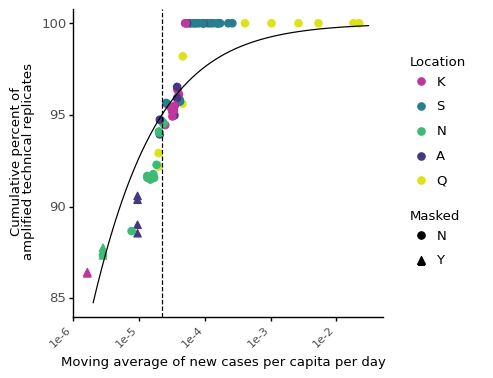

<ggplot: (326581417)>

In [46]:
#using this https://stackoverflow.com/questions/55725139/fit-sigmoid-function-s-shape-curve-to-data-using-python
def sigmoid(x, L ,x0, k, b):
    y = 1 / (1 + np.exp(-k*(x-x0)))
    return (y)


t=t=cum_df.iloc[:-7].copy() #noisy initial rows
t=t=cum_df
t=t[['moving average of new cases per capita','percent_amp']]
t.columns=['ma','p_amp']
t['log_ma']=np.log10(t.ma)
t['f_amp']=t.p_amp/100
p0 = [max(t.f_amp), np.median(t.log_ma),1,min(t.f_amp)] 
popt, pcov = curve_fit(sigmoid, t.log_ma, t.f_amp, p0, method='trf' ) 
xfull=list(np.arange(-5.7,-1.5,0.0001))
df=pd.DataFrame(xfull)
df.columns=['xfull']
df['y']=sigmoid(df.xfull, *popt)
df['per_y']=df['y']*100
df['x']=10**df.xfull

# df=df.sort_values('per_y')
# pt100=df.loc[((df['per_y']==100)&(df['x']==df['x'].min()))]
# x100=pt100["x"]
pt95=df.iloc[df['per_y'].sub(95).abs().idxmin()]
x95=pt95["x"]
v1=x95

cum_df['percent_amp']=pd.to_numeric(cum_df['percent_amp'])

plt = (ggplot() + 
geom_point(cum_df, aes(x='moving average of new cases per capita', y='percent_amp',color="location",shape="BLoD_clinical"), size=2.5)+
# geom_point(t, aes(x='ma', y='p_amp'), size=2.5)+
scale_color_cmap_d('viridis')+
geom_line(df, aes(x='x', y='per_y'),color='black')+
# geom_vline(xintercept=case_LoD_sq/pop_dict['B_B_SQ'], color=sq_c, linetype='dashed' )+
# geom_vline(xintercept=case_LoD/pop_dict['C_C_ADA'], color=ada_c, linetype='dashed' )+
# geom_vline(xintercept=case_LoD_N/pop_dict['C_C_N49'], color=n49_c, linetype='dashed' )+
# geom_vline(xintercept=case_LoD/pop_dict['K_K_INF'], color=k_c, linetype='dashed' )+
geom_vline(xintercept=x95, color='black', linetype='dashed' )+
scale_color_manual([k_c,s68_c, n49_c, ada_c,sq_c])+
 ylab('Cumulative percent of\namplified technical replicates')+
 xlab('Moving average of new cases per capita per day')+
 labs(color="Location", shape="Masked")+
scale_x_log10()+
theme_classic()+ theme(legend_title=element_text(size=ftl),axis_title=element_text(size=ftl), strip_text=element_text(size=ftl), legend_text=element_text(size=ftl),axis_text_x=element_text(rotation=45, hjust=1, size=fts), axis_text_y=element_text(size=ftl), figure_size=(4,4)) )


#title for the plot
n1='Figure_S13B' 
plot1=n1  +'.pdf'
#path for the plot
path=os.path.join(dir, plot1)
#save the plot
plt.save(path)


plt

In [47]:
x95

2.21870723719649e-05

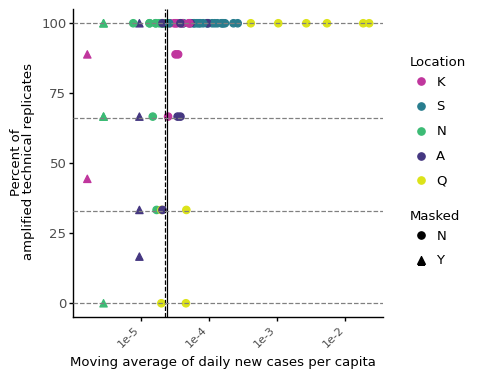

<ggplot: (-9223372036527164756)>

In [48]:

# cum_df=cum_df[cum_df.BLoD_clinical=="N"].copy()

# t=t=cum_df.iloc[:-7].copy() #noisy initial rows
t=cum_df
cum_df.BLoD_clinical.unique()
t=t[['moving average of new cases per capita','percent_amp']]
t.columns=['ma','p_amp']
t['log_ma']=np.log10(t.ma)
t['f_amp']=t.p_amp/100
p0 = [max(t.f_amp), np.median(t.log_ma),1,min(t.f_amp)] 
popt, pcov = curve_fit(sigmoid, t.log_ma, t.f_amp, p0, method='trf' ) 
xfull=list(np.arange(-5.2,-3,0.0001))
df=pd.DataFrame(xfull)
df.columns=['xfull']
df['y']=sigmoid(df.xfull, *popt)
df['per_y']=df['y']*100
df['x']=10**df.xfull

cum_df=cum_df.sort_values('percent_amp')
df100=cum_df.loc[cum_df['percent_amp']==100]
pt100=df100.loc[((df100['moving average of new cases per capita']==df100['moving average of new cases per capita'].min()))]
x100=pt100["moving average of new cases per capita"]
v2=0.000024
# pt98=df.iloc[df['per_y'].sub(popt[0]*100 -2).abs().idxmin()]
# x98=pt98["x"]

cum_df['percent_amp_nonc']=pd.to_numeric(cum_df['percent_amp_nonc'])

plt = (ggplot() + 
geom_point(cum_df, aes(x='moving average of new cases per capita', y='percent_amp_nonc',color="location", shape="BLoD_clinical"), size=2.5)+
# geom_point(t, aes(x='ma', y='p_amp'), size=2.5)+
scale_color_cmap_d('viridis')+
# geom_line(df, aes(x='x', y='per_y'),color='black')+
geom_vline(xintercept=v1, color='black', linetype='dashed' )+
geom_vline(xintercept=v2, color='black', linetype='solid' )+
geom_hline(yintercept=0, color='grey', linetype='dashed' )+
geom_hline(yintercept=33, color='grey', linetype='dashed' )+
geom_hline(yintercept=66, color='grey', linetype='dashed' )+
geom_hline(yintercept=100, color='grey', linetype='dashed' )+
scale_color_manual([k_c,s68_c, n49_c, ada_c,sq_c])+
 ylab('Percent of\namplified technical replicates')+
 xlab('Moving average of daily new cases per capita')+
 labs(color="Location", shape="Masked")+
scale_x_log10()+
theme_classic()+ theme(legend_title=element_text(size=ftl),axis_title=element_text(size=ftl), strip_text=element_text(size=ftl), legend_text=element_text(size=ftl),axis_text_x=element_text(rotation=45, hjust=1, size=fts), axis_text_y=element_text(size=ftl), figure_size=(4,4)) )



#title for the plot
n1='Figure_S13A' 
plot1=n1  +'.pdf'
#path for the plot
path=os.path.join(dir, plot1)
#save the plot
plt.save(path)


plt

#### Figure 6

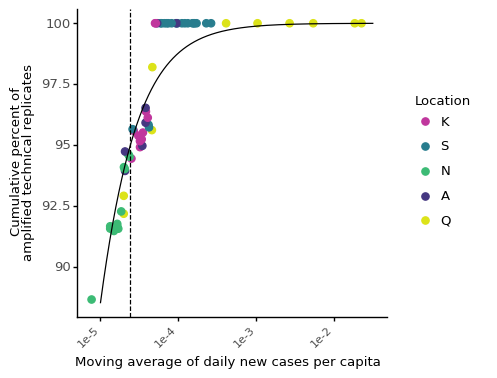

<ggplot: (-9223372036528752261)>

In [49]:
cum_df=cum_df[cum_df.BLoD_clinical=="N"].copy()

# t=t=cum_df.iloc[:-7].copy() #noisy initial rows
t=cum_df
cum_df.BLoD_clinical.unique()
t=t[['moving average of new cases per capita','percent_amp']]
t.columns=['ma','p_amp']
t['log_ma']=np.log10(t.ma)
t['f_amp']=t.p_amp/100
p0 = [max(t.f_amp), np.median(t.log_ma),1,min(t.f_amp)] 
popt, pcov = curve_fit(sigmoid, t.log_ma, t.f_amp, p0, method='trf' ) 
xfull=list(np.arange(-5,-1.5,0.0001))
df=pd.DataFrame(xfull)
df.columns=['xfull']
df['y']=sigmoid(df.xfull, *popt)
df['per_y']=df['y']*100
df['x']=10**df.xfull

# cum_df=cum_df.sort_values('percent_amp')
# df100=cum_df.loc[cum_df['percent_amp']==100]
# pt100=df100.loc[((df100['moving average of new cases per capita']==df100['moving average of new cases per capita'].min()))]
# x100=pt100["moving average of new cases per capita"]

pt95=df.iloc[df['per_y'].sub(95).abs().idxmin()]
x95=pt95["x"]
v2=x95

plt = (ggplot() + 
geom_point(cum_df, aes(x='moving average of new cases per capita', y='percent_amp',color="location"), size=2.5)+
# geom_point(t, aes(x='ma', y='p_amp'), size=2.5)+
scale_color_cmap_d('viridis')+
geom_line(df, aes(x='x', y='per_y'),color='black')+
geom_vline(xintercept=x95, color='black', linetype='dashed' )+
scale_color_manual([k_c,s68_c, n49_c, ada_c,sq_c])+
 ylab('Cumulative percent of\namplified technical replicates')+
 xlab('Moving average of daily new cases per capita')+
 labs(color="Location", shape="Below\nclinical LoD")+
scale_x_log10()+
theme_classic()+ theme(legend_title=element_text(size=ftl),axis_title=element_text(size=ftl), strip_text=element_text(size=ftl), legend_text=element_text(size=ftl),axis_text_x=element_text(rotation=45, hjust=1, size=fts), axis_text_y=element_text(size=ftl), figure_size=(4,4)) )



#title for the plot
n1='Figure_6' 
plot1=n1  +'.pdf'
#path for the plot
path=os.path.join(dir, plot1)
#save the plot
plt.save(path)


plt

#### Figure S12

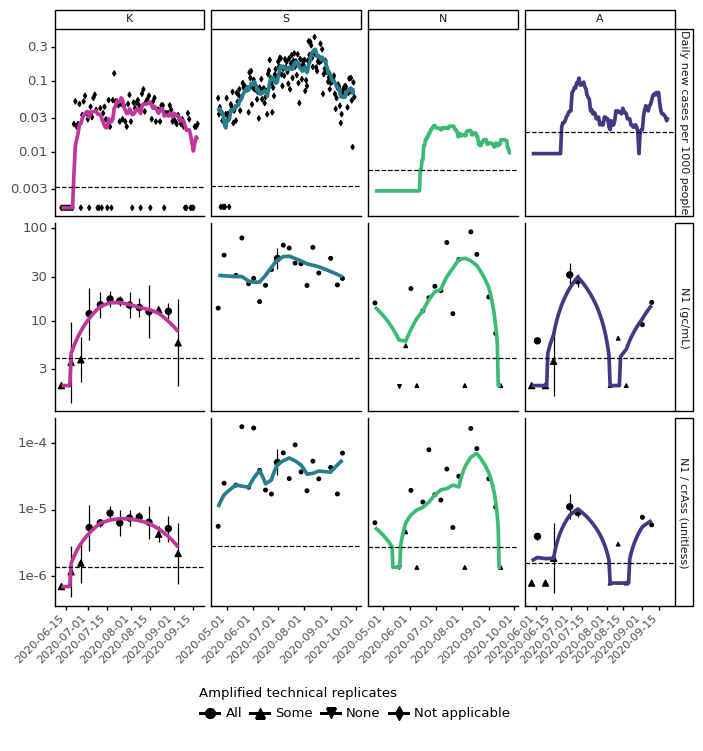

<ggplot: (314682772)>

In [50]:
a=all.copy()
large=["K", "S", "A", "N"]
a=a[a.location.isin(large)]
t=["N1_int", "N1Cr_int","new_cases_per_capita"]
a=a[a.Target_p.isin(t)]
a.loc[a.N1_und =="Not applicable", "N1_und"]= np.nan
a["num_amp"] =pd.to_numeric( a['N1_und'])/a['N1_und_total']#percentage unamplified!!
a.loc[(a.num_amp > 0) & (a.num_amp <1), "num_amp"]= "Some"
a.loc[a.num_amp == 0, "num_amp"]= "All"
a.loc[a.num_amp == 1, "num_amp"]= "None"
a.loc[a.Target_p=="new_cases_per_capita","num_amp"]="Not applicable"
a.loc[a.Target_p=="active_cases_per_capita","num_amp"]="Not applicable"
a.loc[(np.isnan(a.value)),"num_amp"]="Not applicable"
a.loc[(np.isnan(a.model)),"num_amp"]="Not applicable"
a.num_amp=a.num_amp.astype('category')
a.num_amp=a.num_amp.cat.reorder_categories(["All", "Some", "None", "Not applicable"])
a.loc[a.Target_p=="N1_int", "Target"]= name_N1
a.loc[a.Target_p=="N1Cr_int", "Target"]= "N1 / crAss (unitless)"
a.loc[a.Target_p=="new_cases_per_capita", "Target"]= name_new_cases_norm
a.loc[a.Target_p=="active_cases_per_capita", "Target"]= name_active_cases_norm

a.location=a.location.astype('category')
a.location=a.location.cat.reorder_categories(["K", "S",  "N", "A"])

plt = (ggplot() + 
geom_point(a, aes(x='date_sampling', y='value', shape='num_amp'), size=1, color='black')+
geom_pointrange(a, aes(x='date_sampling', y='value', ymin='ymin', ymax='ymax', shape='num_amp'), color='black') +
geom_line(a, aes(x='date_sampling', y='model', color='location'), size=1.5)+
geom_hline(a, aes(yintercept='lod'), linetype='dashed')+
guides(color=False)+
ylab('')+
xlab("")+
scale_color_manual([k_c,s68_c, n49_c, ada_c])+
labs(shape="Amplified technical replicates")+ 
scale_shape_manual(["o","^","v","d" ])+
scale_y_log10()+
facet_grid('Target~location', scales="free")+ #, 
theme_classic()+ theme(legend_position=(.5, -.02),legend_direction='horizontal',legend_title=element_text(size=ftl),axis_title=element_text(size=ftl), strip_text=element_text(size=fts), legend_text=element_text(size=ftl),axis_text_x=element_text(rotation=45, hjust=1, size=fts), axis_text_y=element_text(size=ftl), figure_size=(8,7.5)) )



#title for the plot
n1='Figure_S12' 
plot1=n1  +'.pdf'
#path for the plot
path=os.path.join(dir, plot1)
#save the plot
plt.save(path)


plt

#### Figure S1

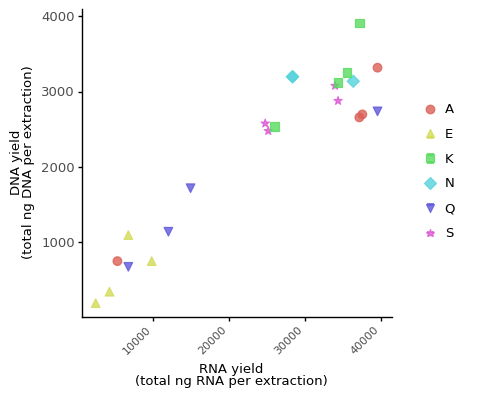

<ggplot: (-9223372036527610231)>

In [51]:
a=sample_data
a.weight_vol_extracted_ml=pd.to_numeric(a.weight_vol_extracted_ml)
a=a[~np.isnan(a.DNA_ng_ul_qubit_all)].copy()
a=a[~np.isnan(a.RNA_ng_ul_qubit_all)].copy()
a_full=a.copy()
m=["B_B_SQ","C_C_ADA","C_C_N49","C_C_S68","E_E_INF","K_K_INF"]
a=a[a.sample_code.isin(m)]
a.location=np.nan
a.loc[a.sample_code==m[0],"location"]="Q"
a.loc[a.sample_code==m[1],"location"]="A"
a.loc[a.sample_code==m[2],"location"]="N"
a.loc[a.sample_code==m[3],"location"]="S"
a.loc[a.sample_code==m[4],"location"]="E"
a.loc[a.sample_code==m[5],"location"]="K"

a['mcode']= a["sample_code"].astype('object')
a.loc[a.DNA_yield_quantification=='below quantification limit','mcode'] = "below quantification limit"
a['mcode']=a['mcode'].astype("category")
# a['mcode']=a['mcode'].cat.reorder_categories(['E_INF','milk of silica','ultrafiltration','ultrafiltration and solids', 'below quantification limit'])

plt=(ggplot(a, aes(x='RNA_yield_ext', y='DNA_yield_ext', shape='location', color='location')) + 
geom_point(size=3, alpha=0.8)+
# facet_grid('~Interceptor')+
xlab('RNA yield\n(total ng RNA per extraction)')+
ylab('DNA yield\n(total ng DNA per extraction)')+
# scale_y_log10()+
guides(shape=guide_legend(title=""), color=guide_legend(title=""))+
theme_classic()+ theme(legend_title=element_text(size=ftl),axis_title=element_text(size=ftl), strip_text=element_text(size=ftl), legend_text=element_text(size=ftl),axis_text_x=element_text(rotation=45, hjust=1, size=fts), axis_text_y=element_text(size=ftl), figure_size=(4,4)) )


#title for the plot
n1='Figure_S1' 
plot1=n1  +'.pdf'
#path for the plot
path=os.path.join(dir, plot1)
#save the plot
plt.save(path)


plt

#### Figure S11

In [52]:
case_k=cases[cases.sample_code=="K_K_INF"].copy()
case_k=case_k.drop(['new_cases','active_cases','moving_average_active_cases'], axis=1)

k_wide=all_wide[all_wide.location=="K"].copy()
k_wide['sample_code']="K_K_INF"

k_wide_case=k_wide.merge(case_k, how='left')
k_wide_case=k_wide_case[["date_sampling","seven_day_moving_total_new_cases", "seven_day_moving_total_new_cases_Ep","seven_day_moving_total_new_cases_Col", "Loess_N1_crAss_reg", "N1Cr_int","Loess_N1_gc_mL", "N1_int", "Lowess_N1_gc_per_capita","flow"]].copy()
k_wide_case[["seven_day_moving_total_new_cases", "seven_day_moving_total_new_cases_Ep","seven_day_moving_total_new_cases_Col"]]=k_wide_case[["seven_day_moving_total_new_cases", "seven_day_moving_total_new_cases_Ep","seven_day_moving_total_new_cases_Col"]].apply(pd.to_numeric)/7/pop_dict["K_K_INF"]*1000
k_wide_case.columns=["date_sampling","Clinical moving average (result date)", "Clinical moving average (episode date)","Clinical moving average (sample collection date)", "Wastewater N1/crAssphage Lowess signal (sample collection date)", "N1_crAss","Wastewater N1 Lowess signal (sample collection date)", "N1_gc_per_mL", "Wastewater N1 * flow Lowess signal (sample collection date)", "flow"]

k_long=k_wide_case.melt(id_vars=["date_sampling","N1_gc_per_mL","N1_crAss", "flow"], var_name="data_type", value_name="model")
k_long['samp']='Clinical data'
k_long.loc[k_long.data_type=="Wastewater N1 Lowess signal (sample collection date)","samp" ]= "Wastewater data unnormalized"
k_long.loc[k_long.data_type=="Wastewater N1/crAssphage Lowess signal (sample collection date)","samp" ]= "Wastewater data crAssphage normalized"
k_long.loc[k_long.data_type=="Wastewater N1 * flow Lowess signal (sample collection date)","samp" ]= "Wastewater data flow normalized"
k_long.loc[k_long.samp!="Wastewater data unnormalized","N1_gc_per_mL"]=np.nan
k_long.loc[k_long.samp!="Wastewater data crAssphage normalized","N1_crAss"]=np.nan
k_long.loc[k_long.samp!="Wastewater data flow normalized","flow"]=np.nan
k_long=k_long.melt(id_vars=["date_sampling", "model","data_type","samp"], var_name="ww")
k_long.head()

,date_sampling,model,data_type,samp,ww,value
0,2020-06-12,1.63E-03,Clinical moving average (result date),Clinical data,N1_gc_per_mL,NAN
1,2020-06-13,1.63E-03,Clinical moving average (result date),Clinical data,N1_gc_per_mL,NAN
2,2020-06-14,1.63E-03,Clinical moving average (result date),Clinical data,N1_gc_per_mL,NAN
3,2020-06-15,1.63E-03,Clinical moving average (result date),Clinical data,N1_gc_per_mL,NAN
4,2020-06-16,1.63E-03,Clinical moving average (result date),Clinical data,N1_gc_per_mL,NAN


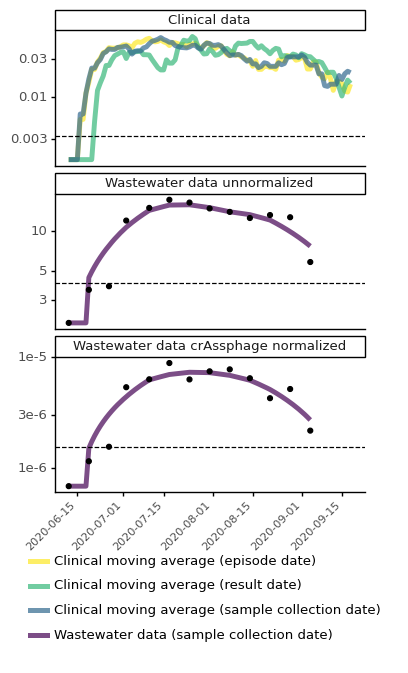

<ggplot: (-9223372036528050709)>

In [53]:
a=k_long
# hlinedf= pd.DataFrame({'samp': ["Clinical data","Wastewater data unnormalized","Wastewater data crAssphage normalized","Wastewater data flow normalized"],
#         'h_val': [case_LoD/pop_dict["K_K_INF"]*1000, N1_LoD/1000, N1_crAss_LoD, N1_LoD *3785411.78*(flow_dict["K_K_INF"]/pop_dict["K_K_INF"])], 'color':['black','black','black','black']
#         }, columns = ['samp', 'h_val','color'])

hlinedf= pd.DataFrame({'samp': ["Clinical data","Wastewater data unnormalized","Wastewater data crAssphage normalized"],
        'h_val': [case_LoD/pop_dict["K_K_INF"]*1000, N1_LoD/1000, N1_crAss_LoD], 'color':['black','black','black']
        }, columns = ['samp', 'h_val','color'])
a=a[a.samp!="Wastewater data flow normalized"].copy()

a.samp=a.samp.astype('category')
a.samp=a.samp.cat.remove_unused_categories()
# a.samp=a.samp.cat.reorder_categories(["Clinical data","Wastewater data unnormalized","Wastewater data flow normalized","Wastewater data crAssphage normalized"])
a.samp=a.samp.cat.reorder_categories(["Clinical data","Wastewater data unnormalized","Wastewater data crAssphage normalized"])

hlinedf.samp=hlinedf.samp.astype('category')
# hlinedf.samp=hlinedf.samp.cat.reorder_categories(["Clinical data","Wastewater data unnormalized","Wastewater data flow normalized","Wastewater data crAssphage normalized"])
hlinedf.samp=hlinedf.samp.cat.reorder_categories(["Clinical data","Wastewater data unnormalized","Wastewater data crAssphage normalized"])

a["lines"]=a.data_type
a.loc[a.samp!="Clinical data", "lines"]="Wastewater data (sample collection date)"

plt = (ggplot() + 
geom_line(a, aes(x='date_sampling', y='model', color='lines'), alpha=0.7, size=2)+
geom_hline(hlinedf,aes(yintercept='h_val'), linetype='dashed', color=hlinedf.color)+
geom_point(a, aes(x='date_sampling', y='value'), color='black')+
# guides(color=False)+
labs(color="")+
ylab('')+
xlab("")+
scale_color_cmap_d('viridis_r')+
scale_y_log10()+
facet_wrap('~samp', ncol=1, scales="free_y")+ #, 
theme_classic()+ theme(legend_position=(.5, -.05),legend_title=element_text(size=ftl),axis_title=element_text(size=ftl), strip_text=element_text(size=ftl), legend_text=element_text(size=ftl),axis_text_x=element_text(rotation=45, hjust=1, size=fts), axis_text_y=element_text(size=ftl), figure_size=(4,6)))


#title for the plot
n1='Figure_S11' 
plot1=n1  +'.pdf'
#path for the plot
path=os.path.join(dir, plot1)
#save the plot
plt.save(path)


plt

#### Figure S14

In [54]:
k=k_wide_case
k=k.drop(["Wastewater N1 Lowess signal (sample collection date)", "Wastewater N1/crAssphage Lowess signal (sample collection date)", "Wastewater N1 * flow Lowess signal (sample collection date)"],axis=1)
k.columns
k.columns=["date_sampling", "Result date", "Episode date", "Sample collection date", "N1_crAss", "N1_gc_per_mL","flow"]
n_new_sm= "value" 
n_ww="N1 (gc/mL)"
n_flow= "N1 (gc/person/day)"
nCr_ww= "N1 / crAssphage (unitless)"
k=k.melt(id_vars=["date_sampling", "N1_gc_per_mL", "N1_crAss", "flow" ], var_name="date")
k.columns=["date_sampling", n_ww, nCr_ww, n_flow, "date_type", n_new_sm ]
k=k.dropna()



k["1lag_"+n_ww]=np.nan
k["1lag_"+nCr_ww]=np.nan
k["1lag_"+n_flow]=np.nan
k["2lag_"+n_ww]=np.nan
k["2lag_"+nCr_ww]=np.nan
k["2lag_"+n_flow]=np.nan
k=k.sort_values([ "date_type","date_sampling"])
k[["1lag_"+n_ww, "1lag_"+nCr_ww, "1lag_"+n_flow]]=k.groupby(['date_type'])[n_ww, nCr_ww, n_flow].shift(1)
k[["2lag_"+n_ww, "2lag_"+nCr_ww,"2lag_"+n_flow]]=k.groupby(['date_type'])[n_ww, nCr_ww, n_flow].shift(2)


lis_t=["date_sampling","date_type", n_new_sm, n_ww, n_flow, nCr_ww]
lis_t2=[n_ww, n_flow, nCr_ww]

condition_reg="no lead"
wBDL=k.copy()
wBDL_reg=wBDL[lis_t].copy()
woBDL=k[k[n_ww]> N1_LoD/1000].copy()
woBDL_reg=woBDL[lis_t].copy()

condition_1="one-week lead"
wBDL_1=wBDL.copy()
wBDL_1=wBDL_1[["date_sampling","date_type", n_new_sm, "1lag_"+n_ww, "1lag_"+n_flow, "1lag_"+nCr_ww]].copy()
wBDL_1.columns=lis_t
woBDL_1=woBDL.copy()
woBDL_1=woBDL_1[["date_sampling","date_type", n_new_sm, "1lag_"+n_ww, "1lag_"+n_flow, "1lag_"+nCr_ww]].copy()
woBDL_1.columns=lis_t

condition_2="two-week lead"
wBDL_2=wBDL.copy()
wBDL_2=wBDL_2[["date_sampling","date_type", n_new_sm, "2lag_"+n_ww, "2lag_"+n_flow, "2lag_"+nCr_ww]].copy()
wBDL_2.columns=lis_t
woBDL_2=woBDL.copy()
woBDL_2=woBDL_2[["date_sampling","date_type", n_new_sm, "2lag_"+n_ww, "2lag_"+n_flow, "2lag_"+nCr_ww]].copy()
woBDL_2.columns=lis_t

reg_df=dataframes_kendalldt(wBDL_reg, woBDL_reg, condition_reg, lis_t2)
lag1_df=dataframes_kendalldt(wBDL_1, woBDL_1, condition_1,lis_t2)
lag2_df=dataframes_kendalldt(wBDL_2, woBDL_2, condition_2,lis_t2)

full_df=reg_df.append(lag1_df).reset_index(drop=True)
full_df=full_df.append(lag2_df).reset_index(drop=True)

full_df['pval_s']=np.nan
full_df.loc[full_df.pval >0.05,"pval_s"]=''
full_df.loc[full_df.pval <=0.05,"pval_s"]='.'
full_df.loc[full_df.pval <=0.01,"pval_s"]='*'
full_df.loc[full_df.pval <=0.001,"pval_s"]='**'
full_df.loc[full_df.pval <=0.0001,"pval_s"]='***'

full_df['taup']=full_df.kval.round(decimals=2).astype(str)+full_df.pval_s.astype(str)
full_df.loc[full_df.pval_s=="",'taup']=""
full_df.head()


,date_type,Target,kval,pval,BDL,condition,pval_s,taup
0,Episode date,N1 (gc/mL),5.64E-01,6.68E-03,BLoD,Episode date no lead,*,0.56*
1,Episode date,N1 (gc/person/day),5.64E-01,6.68E-03,BLoD,Episode date no lead,*,0.56*
2,Episode date,N1 / crAssphage (unitless),5.38E-01,1.01E-02,BLoD,Episode date no lead,.,0.54.
3,Result date,N1 (gc/mL),5.03E-01,1.71E-02,BLoD,Result date no lead,.,0.5.
4,Result date,N1 (gc/person/day),5.03E-01,1.71E-02,BLoD,Result date no lead,.,0.5.


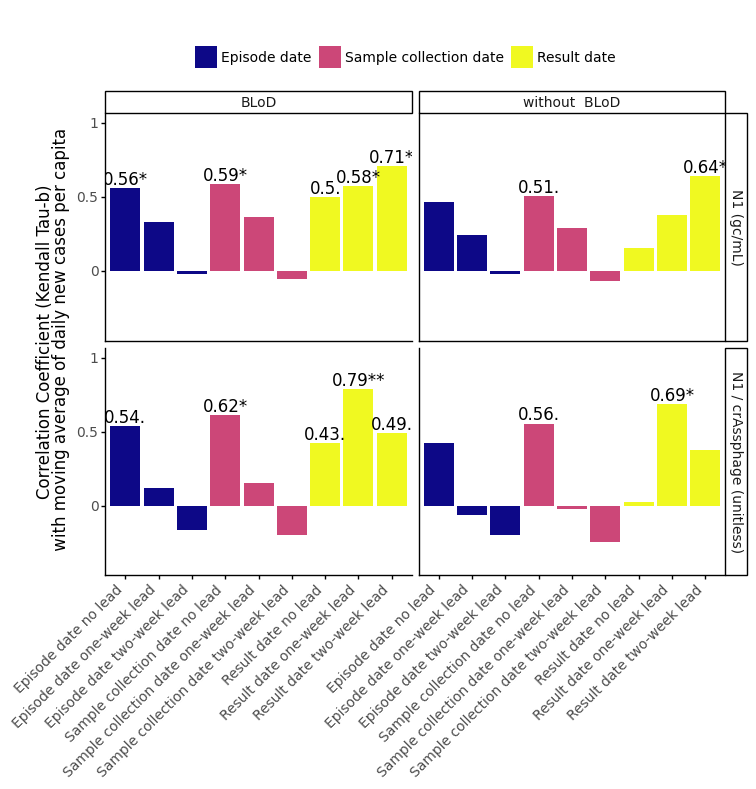

<ggplot: (-9223372036527497009)>

In [55]:

a=full_df

a.condition=a.condition.astype('category')
a.condition=a.condition.cat.reorder_categories(['Episode date no lead', 'Episode date one-week lead','Episode date two-week lead', 'Sample collection date no lead','Sample collection date one-week lead','Sample collection date two-week lead','Result date no lead', 'Result date one-week lead','Result date two-week lead']) 
a.date_type=a.date_type.astype('category')
a.date_type=a.date_type.cat.reorder_categories(['Episode date', 'Sample collection date', 'Result date'])

a=a[a.Target!=n_flow].copy()
plt = (ggplot(a, aes(x='condition', y='kval', fill='date_type')) + 
geom_col(stat='identity')+
geom_text(aes(label='taup'),
            #  position=position_dodge(width=0.9),
             size=12, va='bottom')+
ylab('Correlation Coefficient (Kendall Tau-b)\n with moving average of daily new cases per capita')+
xlab("")+
labs(fill='')+
scale_fill_cmap_d('plasma')+
scale_y_continuous(limits=[-0.4,1])+
facet_grid('Target~BDL')+ #, 
theme_classic()+ theme(legend_title=element_text(size=10),legend_position=(.5, 0.99),legend_direction='horizontal',axis_title=element_text(size=12), strip_text=element_text(size=10),  legend_text=element_text(size=10),axis_text_x=element_text(rotation=45, hjust=1, size=10), axis_text_y=element_text(size=10),figure_size=(8,6)) )


#title for the plot
n1='Figure_S14' 
plot1=n1  +'.pdf'
#path for the plot
path=os.path.join(dir, plot1)
#save the plot
plt.save(path)


plt
